### **Candidate numbers**

27515, 30384, 30855

### Imports

In [ ]:
!pip install --quiet stable_baselines3 quantstats finta
!pip install --quiet git+https://github.com/ShinyOrbThing/gym-anytrading
!pip install --quiet mplfinance
!pip install --quiet shimmy
!pip install --quiet ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.9 MB/s eta 0:00:00


In [ ]:
import quantstats as qs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv, ForexEnv, TradingEnv, Actions, Positions
from gym import spaces
from stable_baselines3 import A2C, DQN, PPO
from stable_baselines3.common.callbacks import EvalCallback, ProgressBarCallback
from stable_baselines3.common.vec_env import DummyVecEnv, make_vec_env
import shimmy
from finta import TA
from ta.trend import SMAIndicator, EMAIndicator, MACD
from sklearn.preprocessing import StandardScaler
from ta.momentum import RSIIndicator
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import datetime
import os
import pickle
from time import time
from enum import Enum
from tqdm import tqdm
from collections import Counter


# ignoring warnings for report
import warnings
warnings.filterwarnings("ignore")

seed=1

In [ ]:
from google.colab import drive

# This will prompt you to click on a link, sign in to your Google account, and copy a verification code.
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **Deep Reinforcement Learning in Simulated and Real Market Environments**


## **Table of Contents**
- [Abstract](#sec:abstract)

- [Introduction](#sec:intro)

<br>

**Part 1 (Simulation):**
- [1.1 Trading Environment](#sec:trading-env-1.1)

- [1.2 Simulated Price Data](#sec:sim-data-1.2)

  - [Simulations](#sec:simulations)

  - [ACF structure of simulations](#sec:ACF-structure)

- [1.3 Environment Setup](#sec:environment-1.3)

  - [Stock trading environment](#sec:environment-1.3)

  - [Training & Evaluation Functions](#sec:environment-1.3)

- [1.4.1 Algorithms](#sec:algorithms-1.4.1)

  - [Proximal Policy Optimisation (PPO)](#sec:algorithms-1.4.1)

  - [Advantage Actor-Critic (A2C)](#sec:algorithms-1.4.1)

  - [Deep Q-network (DQN)](#sec:algorithms-1.4.1)

- [1.4.2 Training RL Agents](#sec:training-agents-1.4.2)

- [1.4.3 Mean Reversion](#sec:mean-reversion-1.4.3)

- [1.4.4 Proof the Mean Reversion Policy is optimal for deterministic, periodic price signals](#sec:mr-proof-1.4.4)

- [1.5 Analysis](sec:analysis-1.5)

  - [Metrics](#sec:analysis-1.5)

  - [Plot functions](#sec:analysis-1.5)

- [1.5.1 Cummulative Returns](#sec:cumulative-returns-1.5.1)

- [1.5.2 Metrics](#sec:metrics-1.5.2)

- [1.5.3 Analysis Results](#analysis-results-1.5.3)

<br>

**Part 2 (Forex):**
- [2.1. DQN architecture impact in investment/trading strategy](#sec:DQN-architecture-impact-2.1)

 - [2.1.1. Custom Environment (upgrading gym_anytrading with new positions and actions)](#sec:Custom-Environment-2.1.1)

  - [2.1.2 Model Training](#sec:Training-2.1.2)

  - [2.1.3 Comparison DQN Architectures for timestep = 10000](#sec:Comparison-2.1.3)

  - [2.1.4. Comparison DQN Architectures for full timesteps](#sec:Comparison-DQN-Architectures-for-full-timesteps-2.1.4)

  - [DQN Results](#sec:DQN-Results-2.1.5)

- [2.2 PPO and A2C applied to Forex Trading (EUR_USD) with gym_anytrading environment](#sec:2.2)

- [2.2.1 A2C](#sec:A2C-2.2.1)

- [2.2.2 PPO](sec:PPO-2.2.2)

<br>

- [Conclusion](#sec:conclusion)

- [Bibliography](#sec:bibliography)



<a name="sec:abstract"></a>
## **Abstract**

This study investigates the efficacy of deep reinforcement learning (DRL) algorithms in trading a single stock within a simplified stock trading environment. In the first half, we explore the performance of Advantage Actor-Critic (A2C), Proximal Policy Optimisation (PPO), and Deep Q-Network (DQN) algorithms in navigating simulated stock signals characterized by sinusoidal waves with varying levels of noise. Our objective is to evaluate the models' resilience to noise and observe how their behavior evolves as the signals approach white noise. Additionally, we compare the performance of these DRL models against a classical benchmark strategy based on mean reversion. In the second part of the project, we extend our analysis to real market data, focusing on minutely data from the foreign exchange trading pair - EUR_USD. This real-world scenario poses greater challenges, so we make modifications to our original environment in an effort to enhance model training and adaptability. Through this comprehensive investigation, we aim to provide insights into the effectiveness of DRL algorithms in practical trading scenarios, shedding light on their strengths, limitations, and potential applications in financial markets.

<a name="sec:intro"></a>
## **Introduction**

#### **Motivation & Literature Review**
The integration of advanced computational techniques to develop trading strategies has become a key research area in quantitative finance. In recent years, DRL has emerged as a powerful tool, capable of navigating complex, dynamic environments, including financial markets. This study is divided into two parts. Firstly, we investigate the application of DRL algorithms, specifically A2C, PPO and DQN in a single-stock trading environment. Simulated trading environments offer a controlled setting to test the robustness and effectiveness of trading algorithms under various market conditions. For instance, [Nevmyvaka et al., 2006](https://www.semanticscholar.org/paper/Reinforcement-learning-for-optimized-trade-Nevmyvaka-Feng/235a9b0733accac54785ec272fcba0c07f4e8b0f) employed machine learning to optimise execution in electronic trading, using simulated environments to validate their performance in idealised versus noisy conditions, providing valuable insights into their resillience and adaptability. Our motivation to is similar, as we seek to understand the strengths and weaknesses of RL for timing buy and sell executions, but our environment differs in representation. We consider OHLCV price data, while Nevmyvaka et al. focused on limit-order books.

<br>

In several recent studies, simulated stock prices have been used for model validation. Just last year, [Taherizadeh et al., 2023](https://www.mdpi.com/2227-7072/11/2/73) explored stock market dynamics using agent-based model (ABM) simulations. Specifically, they developed a simulated stock market, where a large number of agents were deployed to select an optimal portfolio based on several technical criteria. The relative performance of different agents was studied in order to draw inference on which trading strategies are favourable. The mathematical models used to generate policies in Taherizadeh et al. do not use reinforcement learning, but in simulating the stock market, they studied the relative performance of various paradigms. In part 1 of our study, we have similar goals.

<br>

The application of RL agents to electronic trading is an emerging research area with promising developments in recent years. Both single-stock trading and portfolio optimisation problems have been tackled using RL. In the late 90's, [Moody & Saffell, 1998](https://proceedings.neurips.cc/paper_files/paper/1998/hash/4e6cd95227cb0c280e99a195be5f6615-Abstract.html) demonstrated the effectiveness of RL for trading in practice, outperforming the S&P 500 Stock Index for the 25 year period 1970 through 1994. More recently, [Liu et al., 2022](https://arxiv.org/abs/1811.07522) trained RL agents to trade 30 individual stocks, comparing model performance to the Dow Jones Industrial Average and a traditional min-variance portfolio allocation strategy. They focused on the deep deterministic policy gradient (DDPG) algorithm, which is more suited to high dimensional state-action representations (30 stocks, can buy or sell any stock at each time point). In our study, we focus on the single-stock setting, where the objective is to time our buy and sell actions on a single stock to maximise return. Also, we consider mean-reversion trading strategy as our traditional benchmark rather than min-variance which is more suited for portfolio allocation. In [Section 1.4.4](sec:mr-proof-1.4.4), we explain why the mean reversion benchmark is effectively the performance upper bound when the price is generated by a deterministic, periodic price signal.

<br>

[Usha et al., 2019](https://ieeexplore.ieee.org/abstract/document/9063807?casa_token=YzPaFEdcRQMAAAAA:10U6oainHacOgnTWKLpExoC8JJIE54_GLOl5fLgAs6p_iebk1-7pSvXTdx0Q99LglNaffegcmsMEAQ) combined simulated and real data for forex and commodity trading. The outcomes indicated that the trading agent, trained on simulated data and tested on real forex data,  outperformed the market by generating higher returns and minimizing losses, particularly in bear markets. While the model excelled in capturing short-term trends and executing profitable trades, it showed limitations in identifying long-term trends. In this project, we were interested in investigating the consistence of strategies for the model trained on real market data to complement the part with simulated data.

<br>

Regarding Deep Reinforcement Learning research for real market trading, various studies have focused on the DQN method specifically, with results of varying success. Part of this difference of the outcomes depends on the specific neural network architectures applied in the study. [Chen & Gao, 2019](https://ieeexplore.ieee.org/abstract/document/9040728?casa_token=lpF5cSyfTIQAAAAA:fdAQmkDv6_OKUTod1bPy-cVpHIfZlf4fzaP5tEPFcmVbTf_gQZ9kPtmS_KmoosPQ2UHqEbyaU9XNXQ) showcase the impact of the number of layers in the Deep Q-network (DQN) on automated stock trading strategies. They highlight how the network's depth influences the trading strategy. The study reveals that DQN can effectively learn profitable patterns from stock trading data and achieve high accumulated rewards. Additionally, introducing recurrence into the Q-learning process (DRQN) may lead to improvements in stock trading execution. These findings determine the importance of network architecture in enhancing the effectiveness of automated stock trading systems. That is why in this project, we experiment with neural net architecture design and its connection to trading strategies. Below we outline the specific research questions we tackled throughout the project.

<br>

#### **Research Questions**
We aimed to address the following research questions in this project.

**Part 1 (Simulations):**
- How do the algorithms compare in terms of profitability when trading on a periodic, deterministic price movement
- Furthermore, as we inject noise into the signal, how do the model rankings change?
- How well do the RL models generalise to new time periods, with the same data generating process?

**Part 2 (Forex):**
- Is there a relationship between the trading strategy chosen and the DQN model architecture?  (positions and actions considered to depict trading strategy)
- Does the number of training steps for the model influence the strategies learnt by DQN?
- How well are the PPO and A2C models able to generalise when trained and tested on periods of significantly different trading activity within one year?




<a name="sec:trading-env-1.1"></a>
## **1.1 Trading Environment**

Our trading envirnoment is based on [gym-anytrading](https://github.com/ShinyOrbThing/gym-anytrading), an extension to OpenAI gym library. We made changes to the environment as required for our experimets. This is a simplified version of a real stock environment with fewer degrees of freedom (More on this below).

The gym-anytrading trading environment provides a simplified framework for evaluating trading strategies using RL algorithms. Within this environment, two key positions are defined: $\text{Long}$ indicating ownership of shares in the asset, and $\text{OOM}$ (Out-of-market) indicating absence of ownership. In the original gym-anytrading documentation, the positions are instead named Long=1, Short=0, but from the source code we saw that there isn't really Short position functionality. We raised this issue with the developers [here](https://github.com/AminHP/gym-anytrading/issues/100), and we proceeed with the trading positions as we redefined above.

<br>

### **State Representation**

- Current price $P_t$,
- First-difference of current price. $D_t = P_t - P_{t-1}$
- Let $X_t$ denote position at time $t$. Then $X_t =$
\begin{cases}
     1 & \text{If position is Long,}\\
     0 & \text{If position is OOM}
\end{cases}

- Let $Y_t$ denote the %Profit value at time $t$. Then $Y_t =$
\begin{cases}
 Y_{t-1}\times(1-\text{Ask %})\times(1-\text{Bid %}) \times \frac{P_t}{P_{t-s}} & \text{If } A_t = 0 \text{ and } X_t = 1, \\
 Y_{t-1} & \text{Otherwise}
\end{cases}

<br>

Although trading indicators were considered, we found them ineffective for training RL models on the simulated sinusoidal signals so we excluded these. But for the Mean Reversion Benchmark, a 2-month moving average is included.

$\text{MA} = \frac{{\sum_{i=t-2r}^{t} P_i}}{2r}$

Where $r$ is the period of the simulated sine wave, which is set to $31$.

<br>

### **Actions**

$A_t$ the action at time t, can take two values:
- $\text{Buy}=1$
- $\text{Sell}=0$

Notably, consecutive Buy or Sell actions do not trigger trades; instead, two consecutive Buy actions correspond to a buy-and-hold strategy for the subsequent time point.

<br>

### **Reward Update**
Let $R_t$ denote the reward at time $t$, then $R_t = $
\begin{cases}
R_{t-1} + (P_t - P_{t-s}) & \text{If } A_t = 0\text{ and } X_t = 1, \\
R_{t-1} & \text{Otherwise}
\end{cases}

Where $R_{t-1}$ is the previous reward value, $P_t$ is the current price, and $P_{t-s}$ is the price at which we bought the shares, which was $s$ time steps ago. Given the conditions above, the reward function will only updagte when we are closing a position (selling held shares).

<br>

#### Difference between % Profit and the Reward function
The reward function is essentially the difference between the selling and buying price of a share. However, the profit metric is expressed as a percentage, calculated based on the current % profit multiplied by % price change (taking into account trading fees). This approach assumes an "all-in" strategy. As in, the maximum possible shares are purchased with each buy decision. As a result, the reward value and profit are not directly proportional.

For our experiments, we consider the % profit values when computing performance metrics rather than reward function values, which are used solely for training the RL models. We assume an "all-in" strategy, where the agent invests all possible shares with each buy decision. This simplification significantly reduces the action-space dimensions in the trading environment, making the model's easier to train with our compute constraints.

<a name="sec:sim-data-1.2"></a>
## **1.2 Simulated Price Data**

We use simulated sine waves to represent stock prices. These were used due their periodic, predictable pattern. Our hypothesis was that the models would learn the optimal policy for a noiseless sine-wave fairly easily, and that as noise is added the performance will degrade. Studying  the differences in behaviour as the signal gets more difficult was a particular area of interest for us. We talk more about this in the analysis.

<br>

We simulate sinusoidal prices according to the following equation:

$$P_t = \alpha + \beta \times \sin(m \times t) + \epsilon_t$$

Where $\alpha$ is the center-line (price when $sin(m\times t) = 0$), $\beta$ is the amplitude of the sine wave, and $m$ is the number of months in the dataset. $\epsilon_t \sim N(0, \sigma^2)$ is a gaussian noise parameter with standard deviation $\sigma$. This is the parameter that we vary for each experiment, such that the signal becomes increasingly hard to predict.

In [ ]:
# Simulations are formatted as daily Open, High, Low, Close prices and Volume (OHLCV) data
TRAIN_START_DATE = '2017-01-01'
TRAIN_END_DATE = '2017-12-31'
TRADE_START_DATE = '2018-01-01'
TRADE_END_DATE = '2018-12-31'

In [ ]:
np.random.seed(seed)
# Function to simulate sinusoidal stock data
def simulate_sinusoidal_stock_data(ticker, start_date=TRAIN_START_DATE,
                                   end_date=TRADE_END_DATE, frequency='B', amplitude=20,
                                   rpm=1, base_price=100,
                                   volume_mean=1000, volume_std=100, noise=0,
                                   trend=0, indicators=False, window_size=5, seed=seed):
    '''
    Simulates sinusoidal stock price data with optional noise. Volume is not used,
    and is only generated to fulfil the OHLCV (Open, High, Low, Close, Volume) data format

    Parameters:
    - ticker (str): Ticker symbol of the stock.
    - frequency (str, optional): Frequency of data points. Defaults to 'B' (business day).
    - amplitude (float, optional): Amplitude of the sinusoidal function. Defaults to 20.
    - rpm (int, optional): Wave revolutions per month. Defaults to 1.
    - base_price (float, optional): Initial price of the stock. Defaults to 100.
    - noise (float, optional): Standard deviation of Gaussian noise to add to the price data. Defaults to 0.
    - trend (float, optional): Linear trend added to the price data. Defaults to 0.
    - indicators (bool, optional): Whether to include additional technical indicators. Defaults to False.
    - window_size: window size specification for rolling window indicators
    - seed (int, optional): Seed for random number generation. Defaults to 0.


    Note that volume is not contextual in this implementation. It is included
    for data formatting in the stock environment.
    '''

    if seed:
      np.random.seed(seed)

    date_range = pd.date_range(start=start_date, end=end_date, freq=frequency)
    num_days = len(date_range)
    num_months = len(pd.date_range(start=start_date, end=end_date, freq='M'))

    # simulate time variable
    time = np.linspace(0, 2 * np.pi, num_days)

    # we want num_months revolutions in the sine wave, so period = num_months*rpm
    prices = base_price + amplitude * np.sin(num_months * rpm * time) + np.random.normal(0, noise, num_days) + time*trend

    # simulate volume (not used by our environment)
    volume = np.random.normal(volume_mean, volume_std, num_days).astype(int)

    # Create a DataFrame
    sim_df = pd.DataFrame({
        'Date': date_range,
        'Open': prices,
        'High': prices + np.random.uniform(0, amplitude, num_days),
        'Low': prices - np.random.uniform(0, amplitude, num_days),
        'Close': prices,
        'Volume': volume
    })

    sim_df.set_index('Date', inplace=True)

    # coerce data into correct format
    sim_df['tic'] = ticker.lower()
    sim_df['Date'] = sim_df.index
    sim_df['day'] = sim_df.Date.dt.dayofweek
    #sim_df.date = sim_df.Date.dt.strftime('%Y-%m-%d')

    sim_df = sim_df.sort_index()

    # including indicators shortens the series slightly
    if indicators:
      sim_df['SMA'] = TA.SMA(sim_df, window_size)
      sim_df[['MACD', 'MACD_SIG']] = TA.MACD(sim_df, window_size)
      sim_df['RSI'] = TA.RSI(sim_df)
      sim_df = sim_df.iloc[window_size+5:, :]

    return sim_df

# Define parameters
ticker_symbol = 'SINE'
start_date = TRAIN_START_DATE
end_date = TRADE_END_DATE

Open        High         Low       Close  Volume   tic  \
Date                                                                       
2017-01-16  104.786313  113.799179  102.676172  104.786313     919  sine   
2017-01-17   99.033732  105.722120   87.929226   99.033732     974  sine   
2017-01-18   93.361843   97.721222   91.462722   93.361843    1038  sine   
2017-01-19   88.244295  106.759791   76.624614   88.244295     971  sine   
2017-01-20   84.108446   97.901234   79.048844   84.108446     960  sine   

                 Date  day         SMA       MACD  MACD_SIG        RSI  
Date                                                                    
2017-01-16 2017-01-16    0  113.442789  -1.625462  1.149142  45.079044  
2017-01-17 2017-01-17    1  109.306631  -3.999533  0.043423  36.215511  
2017-01-18 2017-01-18    2  104.393292  -6.515011 -1.344570  29.960466  
2017-01-19 2017-01-19    3   99.113076  -8.943269 -2.934223  25.654944  
2017-01-20 2017-01-20    4   93.906926 -11.048759 -4.616314  22.802909

In [ ]:
# Generate simulated data
%matplotlib inline
np.random.seed(seed)

sigma_vec = np.arange(0, 21, 4)
sine_data_dict = {}
for noise in sigma_vec:
  sine_data = simulate_sinusoidal_stock_data(ticker_symbol, start_date, end_date, noise=noise, amplitude=10, indicators=False)
  sine_data_dict[noise] = sine_data

sigmas = sorted(sine_data_dict.keys())
sigmas

[0, 4, 8, 12, 16, 20]

### Train Test Split
Each full simulation consists of 521 data points, each representing a daily reported price. The dataset is divided like so.

**Training:**  
The first 50% of data is used for training the RL models. This time period isn't considered in our evaluation.


<br>

**Validation:**  
The next 25% is used for our evaluation callback (More on this later).


<br>

**Testing:**
Last 25% is used as the out-of-time test period. From this, we can evaluate how the model will perform on a new unseen time period.



In [ ]:
train_start_date = "2017-01-02"
valid_end_date = "2018-06-29"

df = sine_data_dict[0]
train_val_df = df.loc[(df.index >= train_start_date) & (df.index <= valid_end_date), :]
train_size = round(train_val_df.shape[0]*0.66)
val_size = train_val_df.shape[0] - train_size
test_size = df.shape[0] - train_val_df.shape[0]

print("Spliit sizes:", train_size, val_size, test_size)

Spliit sizes: 257 133 131


<a name="sec:simulations"></a>
### Simulations

Here we plot a sample of prices from each simulation. The noise parameter $\sigma$ is increased at intervals of 4 in the range 0 to 20.

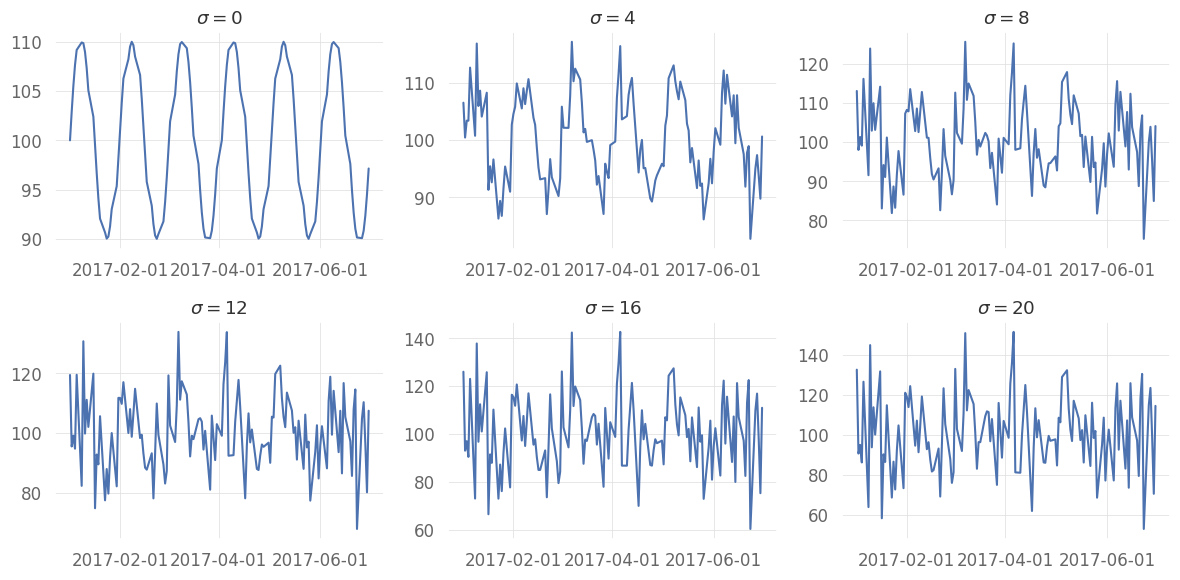

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

for i, ax in enumerate(axes.flatten()):
    df = sine_data_dict[sigmas[i]].copy()
    ax.plot(df.loc[(df.index > '2017-01-01') & (df.index < '2017-07-01'), 'Close'])
    ax.set_title(f'$\sigma = {sigmas[i]}$')

    # Set major ticks format and interval
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))


plt.tight_layout()
plt.show()


<a name="sec:ACF-structure"></a>
### **ACF structure of simulations**

Below are plots of the Autocorrelation Function (ACF) for each simulated stock. The noiseless sine wave is deterministic, as is reflected by the correlation of 1 at regular lag intervals.

As we increase the noise parameter, the ACF structure gets flatter as price approaches a white noise profile.

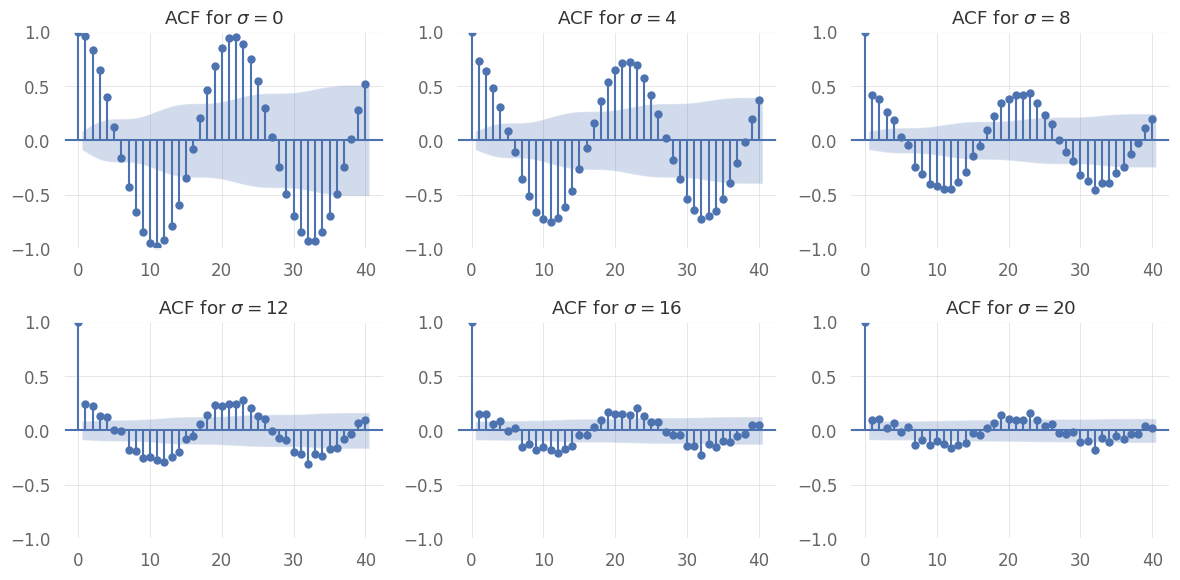

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

for i, ax in enumerate(axes.flatten()):
    # Calculate and plot ACF
    sm.graphics.tsa.plot_acf(sine_data_dict[sigmas[i]].Close, lags=40, ax=ax)
    ax.set_title(f'ACF for $\sigma = {sigmas[i]}$')

plt.tight_layout()
plt.show()


<a name="sec:environment-1.3"></a>
## **1.3 Environment Setup**


### **Stock trading environment**

This is a slightly modified version of the gym-anytrading environment. See [this fork](https://github.com/ShinyOrbThing/gym-anytrading) for the commit history of changes. We make further adjustments in this notebook by overriding functions.

In [ ]:
# Note: Short position is actually "Out-Of-Market" as described above

class Actions(Enum):
    Sell = 0
    Buy = 1


class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long


class TradingEnv(gym.Env):

    metadata = {'render_modes': ['human'], 'render_fps': 3}

    def __init__(self, df, window_size, render_mode=None):
        assert df.ndim == 2
        assert render_mode is None or render_mode in self.metadata['render_modes']

        self.render_mode = render_mode

        self.df = df
        self.window_size = window_size
        self.prices, self.signal_features = self._process_data()
        self.shape = (window_size, self.signal_features.shape[1])

        # spaces
        self.action_space = gym.spaces.Discrete(len(Actions))
        INF = 1e10
        self.observation_space = gym.spaces.Box(
            low=-INF, high=INF, shape=self.shape, dtype=np.float32,
        )

        # episode
        self._start_tick = self.window_size
        self._end_tick = len(self.prices) - 1
        self._truncated = None
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None

    def reset(self, seed=None, options=None):
        super().reset(seed=seed, options=options)
        self.action_space.seed(int((self.np_random.uniform(0, seed if seed is not None else 1))))

        self._truncated = False
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1
        self._position = Positions.Short  # initialises in Short position automatically
        self._position_history = (self.window_size * [None]) + [self._position]
        self._total_reward = 0.
        self._total_profit = 1.  # unit
        self._first_rendering = True
        self.history = {}

        observation = self._get_observation()
        info = self._get_info()

        if self.render_mode == 'human':
            self._render_frame()

        return observation, info

    def step(self, action):
        self._truncated = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._truncated = True

        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward

        self._update_profit(action)

        trade = False
        if (
            (action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)
        ):
            trade = True

        if trade:
            self._position = self._position.opposite()
            self._last_trade_tick = self._current_tick

        self._position_history.append(self._position)
        observation = self._get_observation()
        info = self._get_info()
        self._update_history(info)

        if self.render_mode == 'human':
            self._render_frame()

        return observation, step_reward, False, self._truncated, info

    def _get_info(self):
        return dict(
            total_reward=self._total_reward,
            total_profit=self._total_profit,
            position=self._position
        )

    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]

    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    def _render_frame(self):
        self.render()

    def render(self, mode='human'):

        def _plot_position(position, tick):
            color = None
            if position == Positions.Short:
                color = 'red'
            elif position == Positions.Long:
                color = 'green'
            if color:
                plt.scatter(tick, self.prices[tick], color=color)

        start_time = time()

        if self._first_rendering:
            self._first_rendering = False
            plt.cla()
            plt.plot(self.prices)
            start_position = self._position_history[self._start_tick]
            _plot_position(start_position, self._start_tick)

        _plot_position(self._position, self._current_tick)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

        end_time = time()
        process_time = end_time - start_time

        pause_time = (1 / self.metadata['render_fps']) - process_time
        assert pause_time > 0., "High FPS! Try to reduce the 'render_fps' value."

        plt.pause(pause_time)

    def render_all(self, title=None):
        window_ticks = np.arange(len(self._position_history))
        plt.plot(self.prices)

        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)

        plt.plot(short_ticks, self.prices[short_ticks], 'ro')
        plt.plot(long_ticks, self.prices[long_ticks], 'go')

        if title:
            plt.title(title)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

    def render_all_pretty(self, title=None):
        window_ticks = np.arange(len(self._position_history))
        plt.figure(figsize=(12, 6))

        # plot prices with a more subtle line color and width for dashboard aesthetics
        plt.plot(window_ticks, self.prices, color='#1f77b4', linewidth=2, label='Price', zorder=1)

        # using 'v' for short (downward pointing triangle) and '^' for long (upward pointing triangle)
        short_ticks = [tick for i, tick in enumerate(window_ticks) if self._position_history[i] == Positions.Short]
        long_ticks = [tick for i, tick in enumerate(window_ticks) if self._position_history[i] == Positions.Long]

        plt.scatter(short_ticks, np.array(self.prices)[short_ticks], color='red', marker='v', s=100, label='Short Position', zorder=4)
        plt.scatter(long_ticks, np.array(self.prices)[long_ticks], color='green', marker='^', s=100, label='Long Position', zorder=5)

        # title and subtitles with improved layout
        if title:
            plt.title(title, fontsize=16, fontweight='bold')

        #plt.suptitle("Trading Dashboard", fontsize=18, fontweight='bold')
        plt.title(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit,
            loc='left', fontsize=12, style='italic'
        )

        #plt.legend(frameon=True, facecolor='white', framealpha=0.8, fontsize=10)

        plt.xlabel('Time', fontsize=14, fontweight='bold')
        plt.ylabel('Price', fontsize=14, fontweight='bold')

        plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
        plt.gca().set_facecolor('whitesmoke')
        plt.draw()

        plt.tight_layout()

    def close(self):
        plt.close()

    def save_rendering(self, filepath):
        plt.savefig(filepath)

    def pause_rendering(self):
        plt.show()

    def _process_data(self):
        raise NotImplementedError

    def _calculate_reward(self, action):
        raise NotImplementedError

    def _update_profit(self, action):
        raise NotImplementedError

    def max_possible_profit(self):  # trade fees are ignored
        raise NotImplementedError


In [ ]:
class StocksEnv(TradingEnv):

    def __init__(self, df, window_size, frame_bound, render_mode=None):
        assert len(frame_bound) == 2

        self.frame_bound = frame_bound
        super().__init__(df, window_size, render_mode)

        self.trade_fee_bid_percent = 0.01  # unit (buying fees)
        self.trade_fee_ask_percent = 0.005  # unit (selling fees)

    def _process_data(self):
        prices = self.df.loc[:, 'Close'].to_numpy()  # use close price as current share price

        prices[self.frame_bound[0] - self.window_size]  # validate index (TODO: Improve validation)
        prices = prices[self.frame_bound[0]-self.window_size:self.frame_bound[1]]

        diff = np.insert(np.diff(prices), 0, 0)  # price difference added to features for model training
        signal_features = np.column_stack((prices, diff))  # we will include indicators by overriding this function.
        return prices.astype(np.float32), signal_features.astype(np.float32)

    def _calculate_reward(self, action):
        ''' This reward function only considers long positions,
            Long position reward calculated as expected. Reward isn't applied to long position until a sell action'''
        step_reward = 0

        trade = False
        if (
            (action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)
        ):
            trade = True

        if trade:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]
            price_diff = current_price - last_trade_price  # reward calc

            if self._position == Positions.Long:
                step_reward += price_diff  # reward updates when closing long position

        return step_reward

    def _update_profit(self, action):
        trade = False
        if (
            (action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)
        ):
            trade = True

        # update profit when closing long position
        if trade or self._truncated:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]

            # profit calculated as current profit * % price change, taking into account fees
            if self._position == Positions.Long:
                shares = (self._total_profit * (1 - self.trade_fee_ask_percent)) / last_trade_price

                self._total_profit = (shares * (1 - self.trade_fee_bid_percent)) * current_price


In [ ]:
# overriding gym-anytrading data processing for environment setup

def my_process_data(env):
    prices = env.df.loc[:, 'Close'].to_numpy()
    prices = prices[env.frame_bound[0]-env.window_size:env.frame_bound[1]]

    diff = np.insert(np.diff(prices), 0, 0)  # include first difference as a feature

    # additional indicators (left out by default)
    try:
      sma = env.df.loc[:, 'SMA'].to_numpy()
      macd = env.df.loc[:, 'MACD_SIG'].to_numpy()
      rsi = env.df.loc[:, 'RSI'].to_numpy()

      sma = sma[env.frame_bound[0]-env.window_size:env.frame_bound[1]]
      macd = macd[env.frame_bound[0]-env.window_size:env.frame_bound[1]]
      rsi = rsi[env.frame_bound[0]-env.window_size:env.frame_bound[1]]

      signal_features = np.column_stack((prices, diff, sma, macd, rsi))

    except:
      print("(SMA, MACD, RSI) wern't all present. Reverting to default signal features (price and price-diff)")
      signal_features = np.column_stack((prices, diff))

    return prices.astype(np.float32), signal_features.astype(np.float32)


class MyStocksEnv(StocksEnv):
    _process_data = my_process_data


In [ ]:
# environment setup for the Mean Reversion Benchmark
def my_process_data_bm(env):
    prices = env.df.loc[:, 'Close'].to_numpy()
    prices = prices[env.frame_bound[0]-env.window_size:env.frame_bound[1]]
    diff = np.insert(np.diff(prices), 0, 0)

    # include 2-month MA for mean reversion policy
    sma = env.df['Close'].rolling(window=round(period*2)).mean().to_numpy()
    sma = sma[env.frame_bound[0]-env.window_size:env.frame_bound[1]]

    signal_features = np.column_stack((prices, diff, sma))

    return prices.astype(np.float32), signal_features.astype(np.float32)


class MyStocksEnvBM(StocksEnv):
    _process_data = my_process_data_bm

### **Training & Evaluation Functions**

Functions used for sequential model training and evaluation

In [ ]:
def build_agent(df, window_size,
                train_timesteps, algo,
                bm_path, bm_eval_path,
                seed=seed,
                eval_freq=1000,
                custom_model_params = False,
                model_params={}):
  """
    Builds and trains a reinforcement learning agent for trading using the specified algorithm.

    Parameters:
    - df (DataFrame): DataFrame containing stock data.
    - window_size (int): Size of the observation window.
    - train_timesteps (int): Total number of training timesteps.
    - algo (str): Algorithm to use for training. Options: 'dqn', 'ppo', 'a2c'.
    - bm_path (str): Path to save the best model.
    - bm_eval_path (str, optional): Path to store reward metrics on validation set.
    - seed (int, optional): Random seed for reproducibility.

    Returns:
    - Model: Trained reinforcement learning model.
    """

  # create environment
  start_index = window_size
  end_index = round(len(df)*0.66)
  env = MyStocksEnv(df=df,
                    window_size=window_size,
                    frame_bound=(start_index, end_index))


  # using evaluation callback to retain the best model
  eval_start_index = end_index-1
  eval_end_index = len(df)
  eval_env = MyStocksEnv(df=df,
                    window_size=window_size,
                    frame_bound=(eval_start_index, eval_end_index))
  eval_callback = EvalCallback(eval_env, best_model_save_path=bm_path,
                              log_path=bm_eval_path, eval_freq=eval_freq,
                              deterministic=True, render=False)
  env.reset(seed=seed)
  print('observation_space:', env.observation_space)


  if algo.lower() == 'dqn':
    model = DQN('MlpPolicy', env, seed=seed)
  elif algo.lower() == 'ppo':
    model = PPO('MlpPolicy', env, seed=seed)
  elif algo.lower() == 'a2c':
    model = A2C('MlpPolicy', env, seed=seed)
  else:
    raise Exception('Must specify a model (A2C, PPO, DQN)')

  model.learn(total_timesteps=train_timesteps, callback=eval_callback, **model_params)

  print(f'Training performance logged to {bm_eval_path}')
  print('Returning best model')

  if algo.lower() == 'dqn':
    bm = DQN.load(os.path.join(bm_path, 'best_model.zip'))
  elif algo.lower() == 'ppo':
    bm = PPO.load(os.path.join(bm_path, 'best_model.zip'))
  elif algo.lower() == 'a2c':
    bm = A2C.load(os.path.join(bm_path, 'best_model.zip'))

  return bm

In [ ]:
def evaluate_agent(df, model, algo, sigma, window_size, seed=seed, save=False, fig_savepath='', metrics_savepath=''):
  '''
    Evaluate RL agent using stock data from specified df.
    Dataframe must be in the same form as the one used to train the agent.

    Parameters:
    - df (DataFrame): DataFrame containing stock data.
    - model: Trained reinforcement learning agent model.
    - window_size (int): Size of the observation window.
    - seed (int): Random seed for reproducibility.

    Returns:
    - dict: Dictionary containing evaluation metrics. Also necessary metadata
      for building results dataframe
  '''

  # Create environment
  start_index = window_size
  end_index = len(df)
  env = MyStocksEnv(df=df,
                    window_size=window_size,
                    frame_bound=(start_index, end_index))

  action_stats = {Actions.Sell: 0, Actions.Buy: 0}

  observation, info = env.reset(seed=seed)
  while True:
      action, _states = model.predict(observation)

      action_stats[Actions(action)] += 1
      observation, reward, terminated, truncated, info = env.step(action)
      done = terminated or truncated

      if done:
          break

  env.close()

  # computing metrics
  qs.extend_pandas()
  net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[start_index+1:end_index])
  returns = net_worth.pct_change().iloc[1:]

  metrics = {}
  metrics['algorithm'] = algo
  metrics['sigma'] = sigma
  metrics['profit_ts'] = net_worth
  metrics['cumulative_return'] = net_worth[-1] - net_worth[0]
  metrics['sharpe'] = qs.stats.sharpe(returns)
  metrics['daily_return'] = qs.stats.expected_return(returns)
  metrics['pct_in_market'] = np.round(action_stats[Actions.Buy] /(action_stats[Actions.Buy]+action_stats[Actions.Sell]), 2)  # % time in market
  metrics['max_drawdown'] = qs.stats.max_drawdown(returns)

  print('action_stats:', action_stats)
  print('info:', info)

  if save:
    env.unwrapped.render_all_pretty()
    plt.savefig(fig_savepath)
    print(f"Plot of episode saved to {fig_savepath}")

    with open(metrics_savepath, 'wb') as file:
      pickle.dump(metrics, file)
    print(f"Metrics saved to {metrics_savepath}")

  return metrics



<a name="sec:algorithms-1.4.1"></a>
## **1.4.1 Algorithms**
Here we briefly describe the reinforcement learning algorithms used to train the trading agents. Let $s_t$ and $a_t$ denote the state, action and reward variables at time $t$ respectively. Let $R_t$ denote the reward at time $t$.



### **Proximal Policy Optimisation (PPO)**
PPO operates by optimizing a surrogate objective function, which guarantees small updates to the policy, improving stability and preventing the policy from changing too drastically in a single update step. This is achieved by clipping the policy probability ratio, ensuring that it stays within a predefined range around 1. PPO objective function to includes a clipping mechanism that limits the policy update step, making training more stable than simply optimising on expected return. The objective function is defined as:

$$ L^{CLIP}(\theta) = \hat{\mathbb{E}}_t \left[ \min(r_t(\theta) \hat{A}_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon) \hat{A}_t) \right] $$

Where $r_t(\theta)$ is the probability ratio, $\hat{A}_t$ is the advantage estimate at time $t$, and $\epsilon$ is a small constant, determining how much the ratio can deviate from 1. The policy probability ratio is calculated by dividing the probability under the new policy by the probability under the old one. The ratio helps in assessing how much the new policy deviates from the previous one.

$$ r_t(\theta) = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}$$

PPO uses the advantage function, calculated as $\hat{A}_t = R_t - V(s_t)$ to measure how much better or worse an action is compared to the policy's average. This helps in effectively scaling the policy updates. [Schulman et al., 2017](https://arxiv.org/abs/1707.06347) outlines the PPO algorithm in more detail.



<br>

### **Advantage Actor-Critic (A2C)**
A2C optimizes both a policy function (actor) and a value function (critic) concurrently. It's designed to balance learning efficiency and stability using multiple agents that operate in parallel environments. The actor determines actions basaed on the policy $\pi(a|s, \theta)$, while the critic estimates the value of states via the value function $V(s, \phi)$ where $\phi$ is the set of hyperparameters. The Advantage function is used to refine the actor's policy. In A2C, the advantage function is calculated as $A(s_t, a_t) = Q(s_t, a_t) - V(s_t)$.


The Critic is updated using Temporal Difference learning, specifically the TD error $\delta_t$, calculated as

$$\delta_t = R_t + \gamma V(s_{t+1}, \phi) - V(s_t, \phi)$$

The Actor is updated according to the policy gradient, adjusted by estimates from the advantage function.

$$\nabla_\theta J \approx \mathbb{E}\left[\nabla_\theta \log \pi(a_t|s_t, \theta) A(s_t, a_t)\right]
$$

Although A2C is more difficult to train than PPO on simple tasks ([OpenRL Benchmark](https://arxiv.org/abs/2402.03046)), it is often more effective in complex environments. See [Mnih et al., 2016](https://arxiv.org/abs/1602.01783) for a more detailed explanation of the A2C algorithm.

<br>

### **Deep Q-network (DQN)**
DQN combines Q-learning with deep neural networks to handle complex, high-dimensional environments. DQN uses a neural network to approximate the Q-value function, which represents the value of taking an action in a given state. Several changes from traditional Q-learning are considered. Namely, the Q-network, Experience replay, and the Target network. This algorithm was introduced by DeepMind in 2013 ([Mnih et al., 2016](https://arxiv.org/abs/1602.01783)).

- The Q-value function $Q(s, a; \theta)$ is approximated using the Q-network, which is often a feed-forward neural network, with $\theta$ denoting the parameters of the network.
- Experience Replay is used to brak the correlation between consecutive samples and improve training stability. DQN stores agent experiences ($s_t$, $a_t$, $r_t$, $s_{t+1}$) in a replay buffer and samples randomly from this buffer to perform updates.
- A separate, slowly updated network provides the target Q-values during training, which helps stablise learning. The network is identical to teh Q-network but with parameters $\theta^-$ that leg behind the Q-network's parameters.


Learning:
The agent interacts with the environment, and stores experiences ($s_t$, $a_t$, $r_t$, $s_{t+1}$) in the replay buffer. Mini-batches of experiences are sampled from the buffer, which are used to calculate the loss function. The loss function used to train the network is based on the mean-squared error between the current Q-values and target Q-values:

$$L(\theta) = \mathbb{E}\left[\left(r + \gamma \max_{a'} Q(s', a'; \theta^-) - Q(s, a; \theta)\right)^2\right]
$$

Q-network parameters are updated using gradient descent. Every $T$ timesteps ($T$ is large), the Target network is updated with prameters from the Q-network.

<a name="sec:training-agents-1.4.2"></a>
## **1.4.2 Training RL Agents**

Here we train A2C, PPO, and DQN agents on each of the simulated stock signals.

Models are then evaluated on the out-of-time test set to assess performance on unseen price movements. Note that all model paramers are kept consistent for each simlulation.

In [ ]:
metrics = []

proj_path='/content/drive/MyDrive/OneDrive_clone/Documents/stats_modules/ST455 (Reinforcement Learning)/final_project/'

window_size = 10
train_timesteps = 140000
algorithms=['ppo', 'a2c', 'dqn']
train_start_date = "2017-01-02"
valid_end_date = "2018-06-29"
seed = 1

results_table_path = os.path.join(proj_path, 'metrics/tables/metrics_table.csv')
profit_curve_path = os.path.join(proj_path, 'metrics/tables/profit_ts.csv')
val_metrics_path = os.path.join(proj_path, 'metrics/tables/val_metrics.csv')

skip = True


In [ ]:
if not skip:
  for algo in algorithms:
    for i, sigma in enumerate(sigmas):
      print(f"Building {algo} for sigma = {sigma}")
      print("-"*150)

      # directories for storing results
      fig_path = os.path.join(proj_path, 'plots/'+algo+'_sine'+str(sigma)+'_plot')
      metrics_path = os.path.join(proj_path, 'metrics/'+algo+'_sine'+str(sigma)+'_metrics.pkl')
      bm_path = os.path.join(proj_path,'models/'+algo+'_sine_'+str(sigma))
      bm_eval_path = os.path.join(proj_path, 'logs/'+algo+'_sine'+str(sigma)+'_eval')

      df = sine_data_dict[sigma]
      train_val_df = df.loc[(df.index >= train_start_date) & (df.index <= valid_end_date), :]
      test_df = df.loc[(df.index >= valid_end_date), :]

      bm = build_agent(train_val_df, window_size,
                      train_timesteps, algo,
                      bm_path=bm_path, bm_eval_path=bm_eval_path,
                      eval_freq=1000,
                      seed=1)

      # metrics are saved indivudually for models, and together in a dataframe
      # profit curves are saved to dataframe.
      bm_metrics = evaluate_agent(test_df, bm, algo, sigma, window_size, seed, save=True, fig_savepath=fig_path, metrics_savepath=metrics_path)
      metrics.append(bm_metrics)

      # save metrics
      metrics_df = pd.DataFrame(columns=['algorithm', 'sigma', 'cumulative_return', 'sharpe_ratio', 'daily_return', 'pct_in_market', 'max_drawdown'])
      profit_df = pd.DataFrame()
      for i, m in enumerate(metrics):
        metrics_df.loc[i, :] = [m['algorithm'], m['sigma'], m['cumulative_return'], m['sharpe'],
                            m['daily_return'], m['pct_in_market'],
                            m['max_drawdown']]

        profit_df[m['algorithm']+"_"+str(m['sigma'])] = m['profit_ts']

      metrics_df.to_csv(results_table_path, index=False)
      profit_df.to_csv(profit_curve_path, index=False)
      print(f"Saved metrics table to {results_table_path}")
      print(f"saved profit curves to {profit_curve_path}")

#### **Load in Trained Models & Score them on the Validation Period**

Here we read back in the models trained above and use them to evaluate the model on the validation period.
Re-evaluating models and generating plots without retraining

In [ ]:
# to retrieve trained models
original_proj_path = '/content/drive/MyDrive/OneDrive_clone/Documents/stats_modules/ST455 (Reinforcement Learning)/final_project/'
proj_path='/content/drive/MyDrive/OneDrive_clone/Documents/stats_modules/ST455 (Reinforcement Learning)/final_project/validation'

window_size = 10
train_timesteps = 140000
algorithms=['ppo', 'a2c', 'dqn']

train_val_df = df.loc[(df.index >= train_start_date) & (df.index <= valid_end_date), :]
valid_start_date = train_val_df.iloc[round(len(train_val_df)*0.66), :].Date
train_start_date = "2017-01-02"
valid_end_date = "2018-06-29"


results_table_path = os.path.join(proj_path, 'metrics/tables/metrics_table.csv')
profit_curve_path = os.path.join(proj_path, 'metrics/tables/profit_ts.csv')

Getting ppo model for sigma = 0
------------------------------------------------------------------------------------------------------------------------------------------------------
(SMA, MACD, RSI) wern't all present. Reverting to default signal features (price and price-diff)
action_stats: {<Actions.Sell: 0>: 63, <Actions.Buy: 1>: 59}
info: {'total_reward': 78.65792083740234, 'total_profit': 1.8467602467559816, 'position': <Positions.Long: 1>}
Plot of episode saved to /content/drive/MyDrive/OneDrive_clone/Documents/stats_modules/ST455 (Reinforcement Learning)/final_project/validation/plots/ppo_sine0_plot
Metrics saved to /content/drive/MyDrive/OneDrive_clone/Documents/stats_modules/ST455 (Reinforcement Learning)/final_project/validation/metrics/indiv_metrics/ppo_sine0_metrics.pkl
Getting ppo model for sigma = 4
------------------------------------------------------------------------------------------------------------------------------------------------------
(SMA, MACD, RSI) wern't

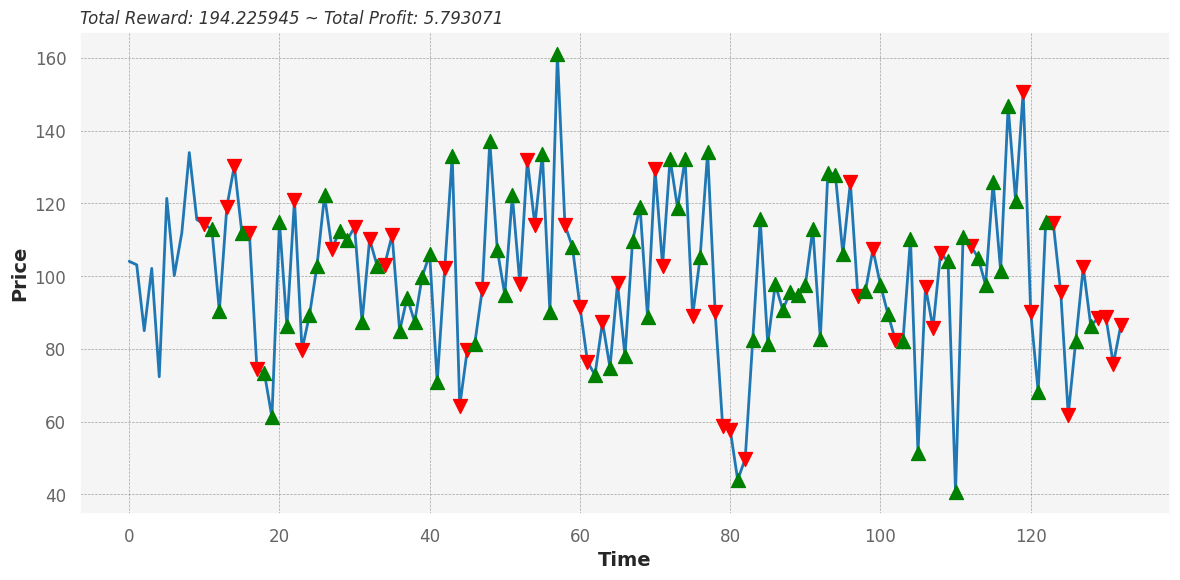

In [ ]:
metrics = []

for algo in algorithms:
  for i, sigma in enumerate(sigmas):
    print(f"Getting {algo} model for sigma = {sigma}")
    print("-"*150)

    # directories for saving results
    fig_path = os.path.join(proj_path, 'plots/'+algo+'_sine'+str(sigma)+'_plot')
    metrics_path = os.path.join(proj_path, 'metrics/indiv_metrics/'+algo+'_sine'+str(sigma)+'_metrics.pkl')
    bm_eval_path = os.path.join(proj_path, 'logs/'+algo+'_sine'+str(sigma)+'_eval')
    bm_path = os.path.join(original_proj_path,'models/'+algo+'_sine_'+str(sigma))

    df = sine_data_dict[sigma]

    # evaluating models on the validation period
    valid_df = df.loc[(df.index >= valid_start_date) & ((df.index <= valid_end_date)), :]

    if algo.lower() == 'ppo':
      model = PPO.load(os.path.join(bm_path, 'best_model.zip'))
    elif algo.lower() == 'a2c':
      model = A2C.load(os.path.join(bm_path, 'best_model.zip'))
    elif algo.lower() == 'dqn':
      model = DQN.load(os.path.join(bm_path, 'best_model.zip'))

    # metrics are saved indivudually for models, and together in a dataframe
    # profit curves are saved in a dataframe
    bm_metrics = evaluate_agent(valid_df, model, algo, sigma, window_size, seed, save=True, fig_savepath=fig_path, metrics_savepath=metrics_path)
    metrics.append(bm_metrics)

    # save metrics
    metrics_df = pd.DataFrame(columns=['algorithm', 'sigma', 'cumulative_return', 'sharpe_ratio', 'daily_return', 'pct_in_market', 'max_drawdown'])
    profit_df = pd.DataFrame()
    for i, m in enumerate(metrics):
      metrics_df.loc[i, :] = [m['algorithm'], m['sigma'], m['cumulative_return'], m['sharpe'],
                           m['daily_return'], m['pct_in_market'],
                           m['max_drawdown']]

      profit_df[m['algorithm']+"_"+str(m['sigma'])] = m['profit_ts']

<a name="sec:mean-reversion-1.4.3"></a>
## **1.4.3 Mean Reversion**

As a benchmark for comparison, we employ the Mean Reversion (MR), which is a simple and commonly used single-stock trading strategy. The MR strategy is based on the prior belief that a stock price will revert to its mean after some time. This financial strategy capitalizes on the tendency of prices to return to their historical average, which can be particularly effective in markets exhibiting stable and predictable behaviors. This strategy requires a moving average estimate, and some deviation threshold which generates buy and sell signals.

The mean is typically calculated using a moving average of the stock's prices over a specific period. Commonly, traders might use simple moving averages (SMA). The strategy involves identifying significant deviations from this average. When a stock's price strays too far from its mean—either above or below—this is viewed as an anomaly likely to correct itself.

<br>

**Buy Signal:** A buy signal is triggered when the stock price drops significantly below the mean. This is seen as an indication that the stock is temporarily undervalued and expected to rise back to its average.

**Sell Signal:** Conversely, a sell signal is generated when the stock price rises significantly above the mean, suggesting that the stock is temporarily overvalued and likely to decrease.

<br>

In the case of a periodic signal without long-term trend, correctly chosen thresholds will result in the optimal policy (Buy at the lowest, sell at the highest). This is demonstrated by using mean reversion on a noiseless sinusoidal price signal, as shown below. Given the periodic nature of the signals we are testing, and the zero-trend, mean reversion acts as an **oracle strategy in the noiseless case** and is powerful as long as the periodicity is not lost in the noise.


(*Note: The images below will render when the repo is cloned and run locally. We encountered issues with image rendering on the GitHub website.*)
<img src ="images/noiseless_mr1.png" height="300" width="500" alt="noiseless_mr1">


Stock prices never resemble a noiseless sine wave, and as is expected, the performance of MR degrades as the signal approaches a white noise process. See the $\sigma = 20$ simulation as an example:

<img src ="images/noisy_mr1.png" height="300" width="500" alt="noisy_mr1">

<a name="sec:mr-proof-1.4.4"></a>
## **1.4.4 Proof the Mean Reversion Policy is optimal for deterministic, periodic price signals**
To prove that a mean reversion strategy is optimal if price movements follow a sine wave, we can model the stock price as

$$P_t = \alpha + \beta \times \sin(m \times t)$$

Where the variables are as defined in [Section 1.2](#sec:sim-data-1.2). We see that the price reaches its extreme points like so:

- minimum at $P_t = \alpha - \beta$ when $sin(m \times t) = -1$
- maximum at $P_t = \alpha + \beta$ when $sin(m \times t) = 1$.

The Mean Reversion policy issues a buy signal when the price falls below the long-term moving average by a tuned threshold $-\gamma$, and a sell signal once the price exceeds the moving average by $\gamma$.

Given a periodic deterministic signal like the sine wave, we can tune $\gamma$ such that the buy signal is:

- Buy at $P_t = \alpha - \beta$, corresponding to $sin(m \times t) = -1$
- Sell at $P_t = \alpha + \beta$, corresponding to $sin(m \times t) = 1$

This profit represents the maximal exploitable price swing, given the periodic nature of the sine function. So when tuned, the MR policy is optimal for the periodic price signal.

#### **MR policy**

In [ ]:
def mean_reversion_policy(state, prev_action, lower_th, upper_th):
    """
    Determine action based on mean reversion strategy.

    Args:
    - state: list of the form [price, 1st difference, lower threshold, upper threshold]

    The thresholds are pre-defined distances from the mean which trigger the
    Buy or Sell action.

    Returns:
    - int: 1 for "buy", 0 for "sell"
    """
    price = state[0]
    mean = state[2]

    if price < mean*lower_th:
        action = 1  # Buy signal: price moves below mean by threshold
    elif price > mean*upper_th:
        action = 0  # Sell signal: price moves above mean by threshold
    else:
        action = prev_action

    return action


### **Simulating stock trading with MR policy**

In [ ]:
validation=True

if validation:
  proj_path='/content/drive/MyDrive/OneDrive_clone/Documents/stats_modules/ST455 (Reinforcement Learning)/final_project/validation'

  train_start_date = "2017-01-02"
  valid_end_date = "2018-06-29"

  results_table_path = os.path.join(proj_path, 'metrics/tables/val_metrics_table.csv')
  profit_curve_path = os.path.join(proj_path, 'metrics/tables/val_profit_ts.csv')
  val_metrics_path = os.path.join(proj_path, 'metrics/tables/val_metrics.csv')

window_size = 1
algo = 'mr'

In [ ]:
metrics_lst = []
for sigma in sigmas:
  action_stats = {Actions.Sell: 0, Actions.Buy: 0}
  fig_path = os.path.join(proj_path, 'plots/'+algo+'_sine'+str(sigma)+'_plot')
  metrics_path = os.path.join(proj_path, 'metrics/indiv_metrics/'+algo+'_sine'+str(sigma)+'_metrics.pkl')
  bm_path = os.path.join(proj_path,'models/'+algo+'_sine_'+str(sigma))
  bm_eval_path = os.path.join(proj_path, 'logs/'+algo+'_sine'+str(sigma)+'_eval')

  df = sine_data_dict[sigma]

  # hide validation data to avoid leakage
  if validation:
    # +10 to align the validation period with the RL models
    backtest_df = df.loc[(df.index >= train_start_date) & (df.index <= valid_start_date), :]
    start_index = tmp.loc[tmp.Date == valid_start_date, :].index.values[0]+10
    end_index = tmp.loc[tmp.Date == valid_end_date, :].index.values[0]+1

  else:
    backtest_df = df.loc[(df.index >= train_start_date) & (df.index <= valid_end_date), :]
    start_index = tmp.loc[tmp.Date == '2018-07-13', :].index.values[0]
    end_index = len(df)

  # further work: threshold tuning
  upper_th = backtest_df.Close.quantile(0.75)/backtest_df.Close.mean()
  lower_th = backtest_df.Close.quantile(0.25)/backtest_df.Close.mean()

  # create environment
  window_size = 1
  tmp = df.reset_index(drop=True)

  env = MyStocksEnvBM(df=df,
                    window_size=window_size,
                    frame_bound=(start_index, end_index))

  observation, info = env.reset(seed=seed)

  # simulate episode
  prev_action = 0
  while True:
      action = mean_reversion_policy(observation[0], prev_action, lower_th, upper_th)
      action_stats[Actions(action)] += 1

      observation, reward, terminated, truncated, info = env.step(action)
      done = terminated or truncated
      prev_action = action

      if done:
          break

  env.close()

  # get metrics and simulation plot
  qs.extend_pandas()

  net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[start_index+1:end_index])
  returns = net_worth.pct_change().iloc[1:]

  metrics = {}
  metrics['algorithm'] = algo
  metrics['sigma'] = sigma
  metrics['profit_ts'] = net_worth
  metrics['cumulative_return'] = net_worth[-1] - net_worth[0]
  metrics['sharpe'] = qs.stats.sharpe(returns)
  metrics['daily_return'] = qs.stats.expected_return(returns)
  metrics['pct_in_market'] = action_stats[Actions.Buy] / (action_stats[Actions.Buy]+action_stats[Actions.Sell])
  metrics['max_drawdown'] = qs.stats.max_drawdown(returns)

  metrics_lst.append(metrics)

  # save metrics and simulation plot
  env.unwrapped.render_all_pretty()
  plt.savefig(fig_path)
  print(f"Plot of episode saved to {fig_path}")

  with open(metrics_path, 'wb') as file:
    pickle.dump(metrics, file)
  print(f"Metrics saved to {metrics_path}")

  baseline_metrics_df = pd.DataFrame(columns=['algorithm', 'sigma', 'cumulative_return', 'sharpe_ratio', 'daily_return', 'pct_in_market', 'max_drawdown'])
  baseline_profit_df = pd.DataFrame()
  for i, m in enumerate(metrics_lst):
    baseline_metrics_df.loc[i, :] = [m['algorithm'], m['sigma'], m['cumulative_return'], m['sharpe'],
                          m['daily_return'], m['pct_in_market'],
                          m['max_drawdown']]

    baseline_profit_df[m['algorithm']+"_"+str(m['sigma'])] = m['profit_ts']


assert baseline_profit_df.shape[0] == profit_df.shape[0]

Updating metrics tables to include the Mean Reversion metrics

In [ ]:
# update the metrics table and profit_df to include the baseline
if metrics_df.loc[metrics_df.algorithm=='mr',:].shape[0] == 0:
  metrics_df = pd.concat([metrics_df, baseline_metrics_df])
  metrics_df.to_csv(results_table_path, index=True)
  print(f"Saved updated metrics table to {results_table_path}")

if 'mr_0' not in profit_df.columns.tolist():
  for col in baseline_profit_df.columns.tolist():
    profit_df[col] = baseline_profit_df[col].values
    profit_df.to_csv(profit_curve_path, index=True)

  print(f"Saved updated profit curves to {profit_curve_path}")



Saved updated metrics table to /content/drive/MyDrive/OneDrive_clone/Documents/stats_modules/ST455 (Reinforcement Learning)/final_project/validation/metrics/tables/val_metrics_table.csv
Saved updated profit curves to /content/drive/MyDrive/OneDrive_clone/Documents/stats_modules/ST455 (Reinforcement Learning)/final_project/validation/metrics/tables/val_profit_ts.csv


<a name="sec:analysis-1.5"></a>
## **1.5 Analysis**

In this section, we compare performance between the RL models and the Mean Reversion benchmark using several metrics.

During model training, models were selected based on their performance on the **validation** dataset, which was unseen during training. We then evaludated the models on another out-of-time **test** set. We analyse model performance on both periods, drawing parallels between performance on both to better understand model behaviour, and to discuss model generalization to unseen periods. This is a topic that is discussed further, in the context of forex trading using RL, in Section 2.

<br>

This analysis is split into two parts. First, we focus in on comparing the models in terms of cumulative returns, which is essentially the reward that the models are trained to maximise. We then supplement this with several additional metrics for a comprehensive analysis of model performance. We also compare model performance on the validation and out-of-time (test) periods, discussing generalisaation of the models to unseen time periods.

#### **Metrics**

We briefly introduce the metrics used in our analysis.

- **Cumulative Return:** % Profit, updated over time.
- **Max Drawdown:** A drawdown is a peak-to-trough decline during a period for an investment. Max drawdown records the worst drawdown as a %.
- **% in Market:** The % of time in the trading period where shares are held. This provides a relative measure of trading activity between the models.
- **Sharpe Ratio:** The Sharpe ratio is a reward-to-risk ratio. It measures how much excess return is recieved for the extra volatility endured by holding an asset. It is calculated as $$S = \frac{R_p - R_f}{\sigma_p}$$ where $R_p$ is the realised P/L from the trade, $R_f$ is the theoretical rate of return of a zero-risk investment, and $\sigma$ is the standard deviation of the asset price.


### **Plot functions**

In [ ]:
import warnings
warnings.simplefilter("ignore")

def profit_plots(metric_df, profits_df, ignore_mr=False, figsize=(10, 20), grid=True):
  algos = list(algo for algo in metric_df.algorithm.unique() if algo != 'mr')
  sigmas = list(sorted(metric_df.sigma.unique()))


  fig, axs = plt.subplots(len(sigmas), figsize=figsize, sharex=True, sharey=True)


  for sigma_idx, sigma in enumerate(sigmas):
      ax = axs[sigma_idx]
      ax.set_title(f"$\sigma$ = {sigma}")
      if not ignore_mr:
        profit_curve_mr = profits_df[['Date', f'mr_{sigma}']].copy()
        profit_curve_mr['Date'] = pd.to_datetime(profit_curve_mr['Date'])
        profit_curve_mr.set_index("Date", inplace=True)
        profit_curve_mr.plot(ax=ax)

      for algo_idx, algo in enumerate(algos):
          profit_curve_algo = profits_df[['Date',f'{algo}_{sigma}']].copy()
          profit_curve_algo['Date'] = pd.to_datetime(profit_curve_algo['Date'])
          profit_curve_algo.set_index("Date", inplace=True)
          profit_curve_algo.plot(ax=ax)

      ax.grid(grid)
      if ignore_mr:
        ax.legend(algos)
      else:
        ax.legend(['mr'] + algos)
      ax.set_xlabel("Time")
      ax.set_ylabel("Cumulative Return")

  fig.tight_layout()
  plt.minorticks_off()
  plt.show(fig)
  plt.close()


def profit_plots_separate(metric_df, profits_df, ignore_mr = False, figsize=(20, 20), grid=True):
  algos = list(algo for algo in metric_df.algorithm.unique() if algo != 'mr')
  sigmas = list(sorted(metric_df.sigma.unique()))
  fig, axs = plt.subplots(len(sigmas), len(algos), figsize=figsize, sharex=True, sharey=True)
  for algo_idx, algo in enumerate(algos):
      for sigma_idx, sigma in enumerate(sigmas):
          ax = axs[sigma_idx, algo_idx]
          profit_curve_algo = profits_df[['Date',f'{algo}_{sigma}']].copy()
          profit_curve_algo['Date'] = pd.to_datetime(profit_curve_algo['Date'])
          profit_curve_algo.set_index("Date", inplace=True)
          profit_curve_algo.plot(ax=ax)


          profit_curve_mr = profits_df[['Date', f'mr_{sigma}']].copy()
          profit_curve_mr['Date'] = pd.to_datetime(profit_curve_mr['Date'])
          profit_curve_mr.set_index("Date", inplace=True)
          profit_curve_mr.plot(ax=ax)
          ax.grid(grid)

          ax.set_title(f"{algo.upper()} , $\sigma$ = {sigma}")
          ax.legend([algo, "mr"])
          ax.set_xlabel("Time")
          ax.set_ylabel("Cumulative Return")

  fig.tight_layout()
  plt.minorticks_off()
  plt.show(fig)
  plt.close()


def metric_plots(metric_df, grid=True):
  metric_names = [c for c in metric_df.columns if c != 'algorithm' and c != 'sigma']
  algos = list(algo for algo in metric_df.algorithm.unique() if algo != 'mr')
  fig, axs = plt.subplots(len(metric_names), figsize=(10, 20), sharex=True, sharey=False)
  for metric_idx, metric_name in enumerate(metric_names):
      ax = axs[metric_idx]
      name = " ".join(metric_name.split("_")) # reformat metric name
      ax.set_title(f"{name} by $\sigma$")
      ax.set_xlabel("$\sigma$")
      ax.set_ylabel(f"{metric_name}")

      for algo_idx, algo in enumerate(algos):
        algo_df = metric_df.query(f'algorithm == "{algo}"')[['sigma',metric_name]].set_index('sigma')
        algo_df.plot(ax=ax)

      ax.grid(grid)
      ax.legend(algos, loc='upper right')
      ax.set_xlabel("$\sigma$")

      ax.set_xticks([0, 4, 8, 12, 16, 20])
      ax.set_ylabel(name)
  plt.minorticks_off()
  plt.show()
  plt.close()


def metric_plots_separate(metric_df, grid=True):
  metric_names = [c for c in metric_df.columns if c != 'algorithm' and c != 'sigma']
  algos = list(algo for algo in metric_df.algorithm.unique() if algo != 'mr')
  fig, axs = plt.subplots(len(metric_names), len(algos), figsize=(20, 20), sharex=True, sharey=False)
  for algo_idx, algo in enumerate(algos):
      for metric_idx, metric_name in enumerate(metric_names):
          ax = axs[metric_idx, algo_idx]

          name = " ".join(metric_name.split("_"))  # reformat metric name for plot
          ax.set_title(f"{algo.upper()}, {name} by $\sigma$")
          ax.legend([algo, "mr"])
          ax.set_xlabel("$\sigma$")
          ax.set_ylabel(f"{name}")

          algo_df = metric_df.query(f'algorithm == "{algo}"')[['sigma',metric_name]].set_index('sigma')
          algo_df.plot(ax=ax)

          mr_df = metric_df.query(f'algorithm == "mr"')[['sigma',metric_name]].set_index('sigma')
          mr_df.plot(ax = ax)
          ax.grid(grid)
          ax.set_xticks([0, 4, 8, 12, 16, 20])
          ax.legend([algo, 'mr'], loc='upper right')
          ax.set_xlabel("$\sigma$")

  fig.tight_layout()
  plt.minorticks_off()
  plt.show()
  plt.close()


def val_test_plots(grid=True):
  metric_names = [c for c in oot_metrics.columns if c != 'algorithm' and c != 'sigma']
  algos = list(algo for algo in oot_metrics.algorithm.unique() if algo != 'mr')
  fig, axs = plt.subplots(len(metric_names), len(algos), figsize=(20, 20), sharex=True, sharey=False)
  for algo_idx, algo in enumerate(algos):
      for metric_idx, metric_name in enumerate(metric_names):
          name = " ".join(metric_name.split("_"))
          ax = axs[metric_idx, algo_idx]
          ax.set_title(f"{algo.upper()}, {name} by $\sigma$")
          ax.legend([algo, "mr"])
          ax.set_xlabel("$\sigma$")
          ax.set_ylabel(f"{metric_name}")

          algo_df = oot_metrics.query(f'algorithm == "{algo}"')[['sigma',metric_name]].set_index('sigma')
          algo_df.plot(ax=ax)

          mr_df = val_metrics.query(f'algorithm == "{algo}"')[['sigma',metric_name]].set_index('sigma')
          mr_df.plot(ax = ax)

          ax.grid(grid)
          ax.set_xticks([0, 4, 8, 12, 16, 20])
          plt.minorticks_off()


          ax.legend([algo.upper(), "val "+algo.upper()], loc='upper right')
  plt.show()
  plt.close()

In [ ]:
# change directories as required
val_proj_path='/content/drive/MyDrive/OneDrive_clone/Documents/stats_modules/ST455 (Reinforcement Learning)/final_project/validation'
oot_proj_path = '/content/drive/MyDrive/OneDrive_clone/Documents/stats_modules/ST455 (Reinforcement Learning)/final_project/'

oot_results_table_path = os.path.join(oot_proj_path, 'metrics/tables/metrics_table.csv')
oot_profit_curve_path = os.path.join(oot_proj_path, 'metrics/tables/profit_ts.csv')
val_results_table_path = os.path.join(val_proj_path, 'metrics/tables/val_metrics_table.csv')
val_profit_curve_path = os.path.join(val_proj_path, 'metrics/tables/val_profit_ts.csv')

In [ ]:
# load in results
oot_metrics = pd.read_csv(oot_results_table_path).drop(columns=['daily_return'])
oot_profit = pd.read_csv(oot_profit_curve_path)
val_metrics = pd.read_csv(val_results_table_path).iloc[:, 1:].drop(columns=['daily_return'])
val_profit = pd.read_csv(val_profit_curve_path)

<a name="sec:cumulative-returns-1.5.1"></a>
### **1.5.1 Cummulative Returns**



From the plots below, we see that Mean Reversion benchmark is more profitable than RL models when $\sigma = 0$ (noiseless sinusoidal price movements). The PPO performance was also promising here. As the signal gets more noisy, we see RL models outperm the benchmark in several experiments. Notably, A2C outperforms MR when $\sigma = 12$ both in the validation and test periods with significant upturns.

RL Algorithms vs Benchmark: - Cumulative returns on Validation Set


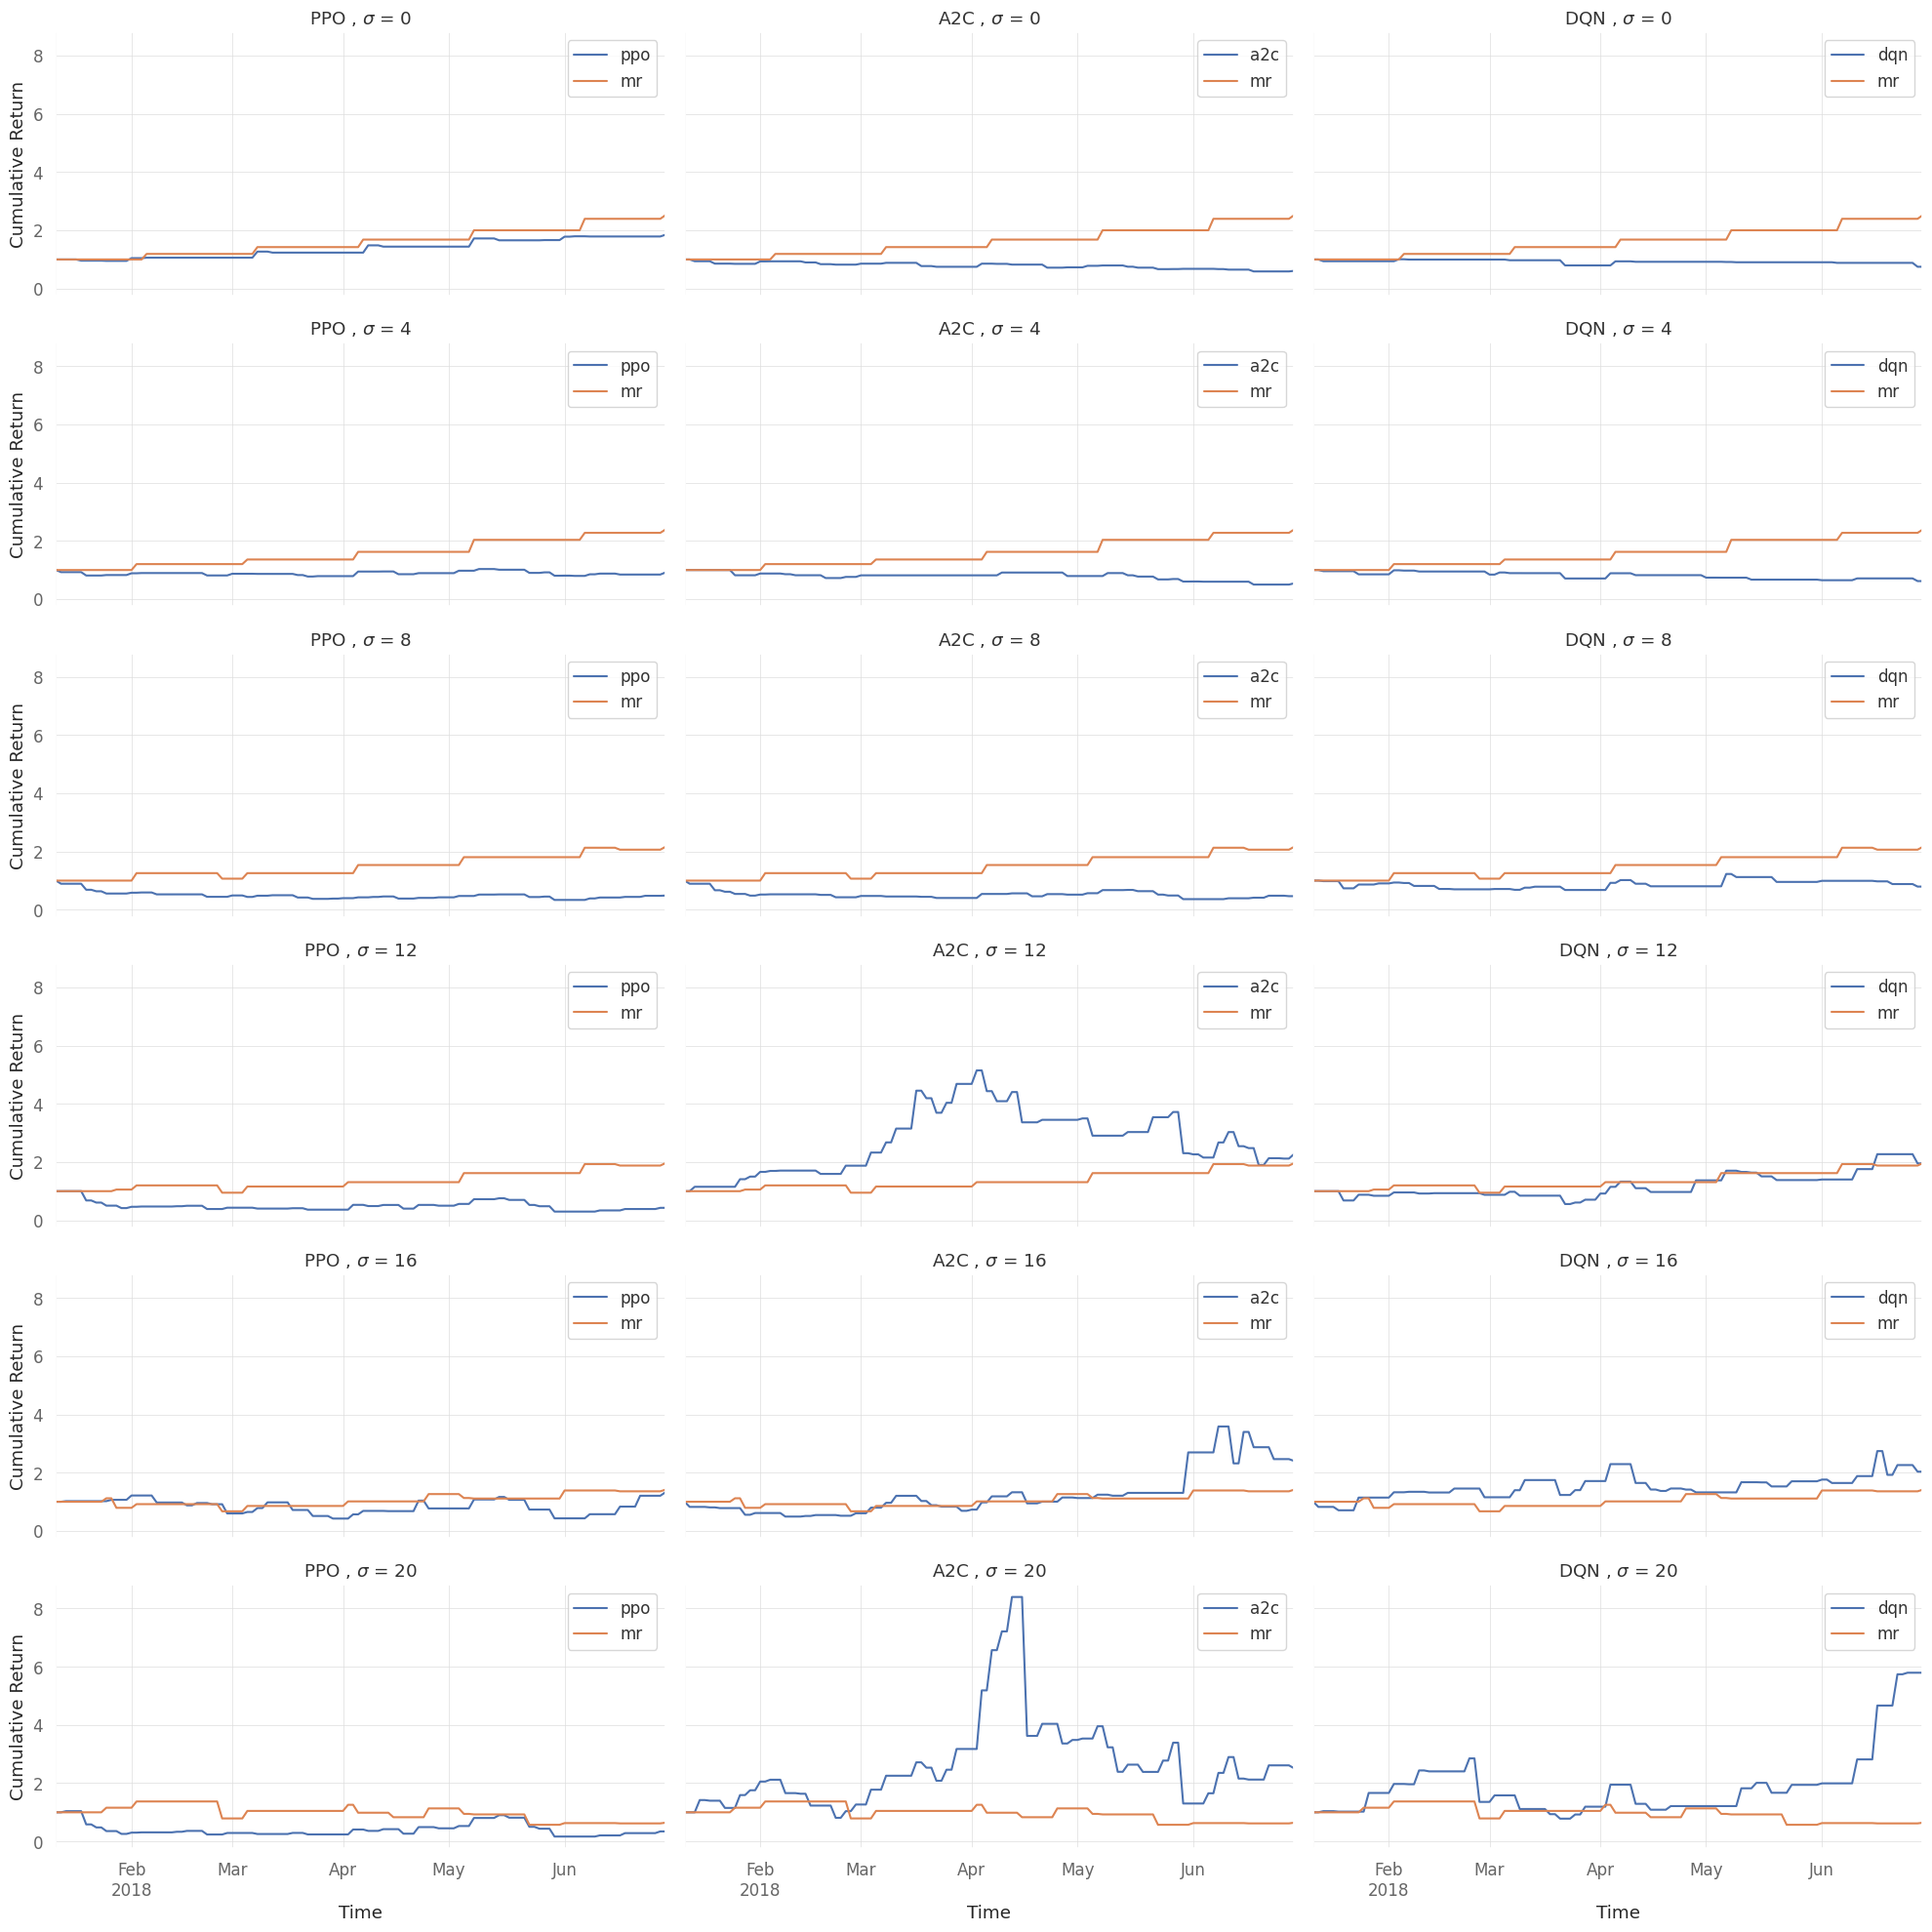

In [ ]:
print("RL Algorithms vs Benchmark: - Cumulative returns on Validation Set")
profit_plots_separate(val_metrics, val_profit)

RL Algorithms vs Benchmark: - Cumulative returns on Test Set


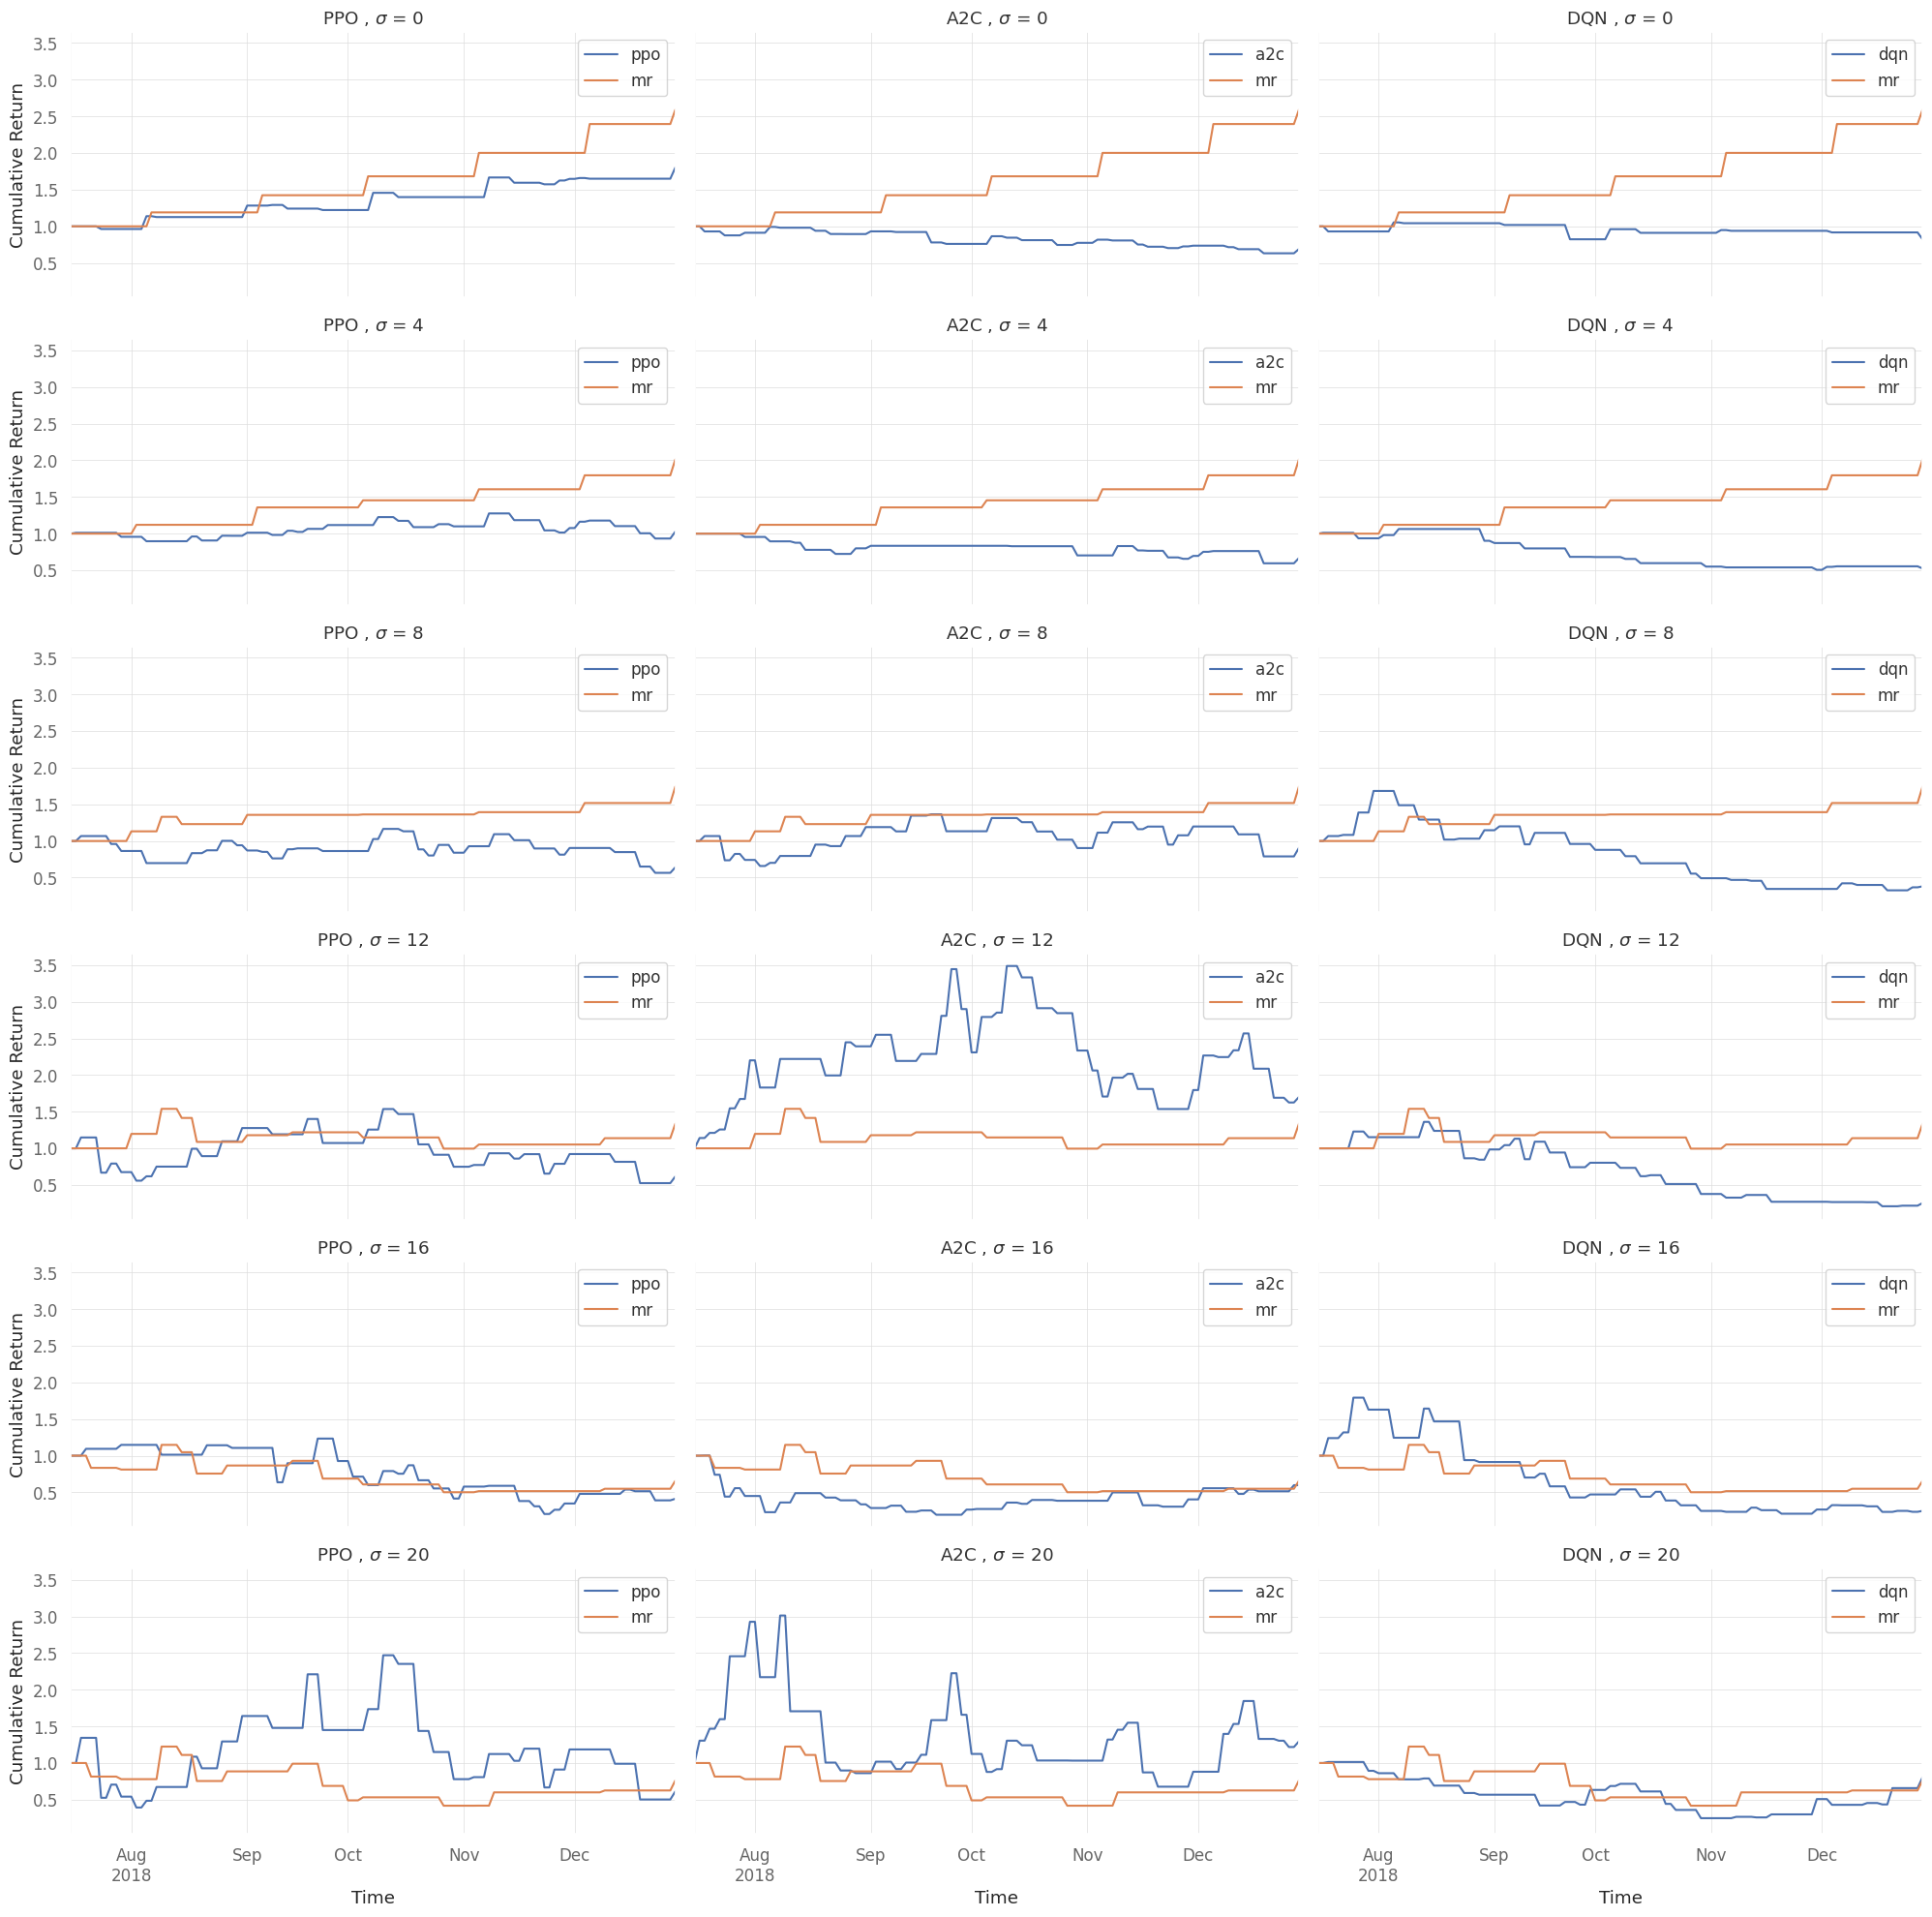

In [ ]:
print("RL Algorithms vs Benchmark: - Cumulative returns on Test Set")
profit_plots_separate(oot_metrics, oot_profit)

In both the validation set, PPO shows superior performance in the easier price movements (low $\sigma$). For more volatile signals (high $\sigma$), both DQN and A2C overtake to PPO in terms of cumulative returns. In the metrics section, we consider risk-conscious metrics such as Sharpe ratio, and contrast with the cumulative return results.

RL Algorithms comparison: Cumulative returns on Validation Set


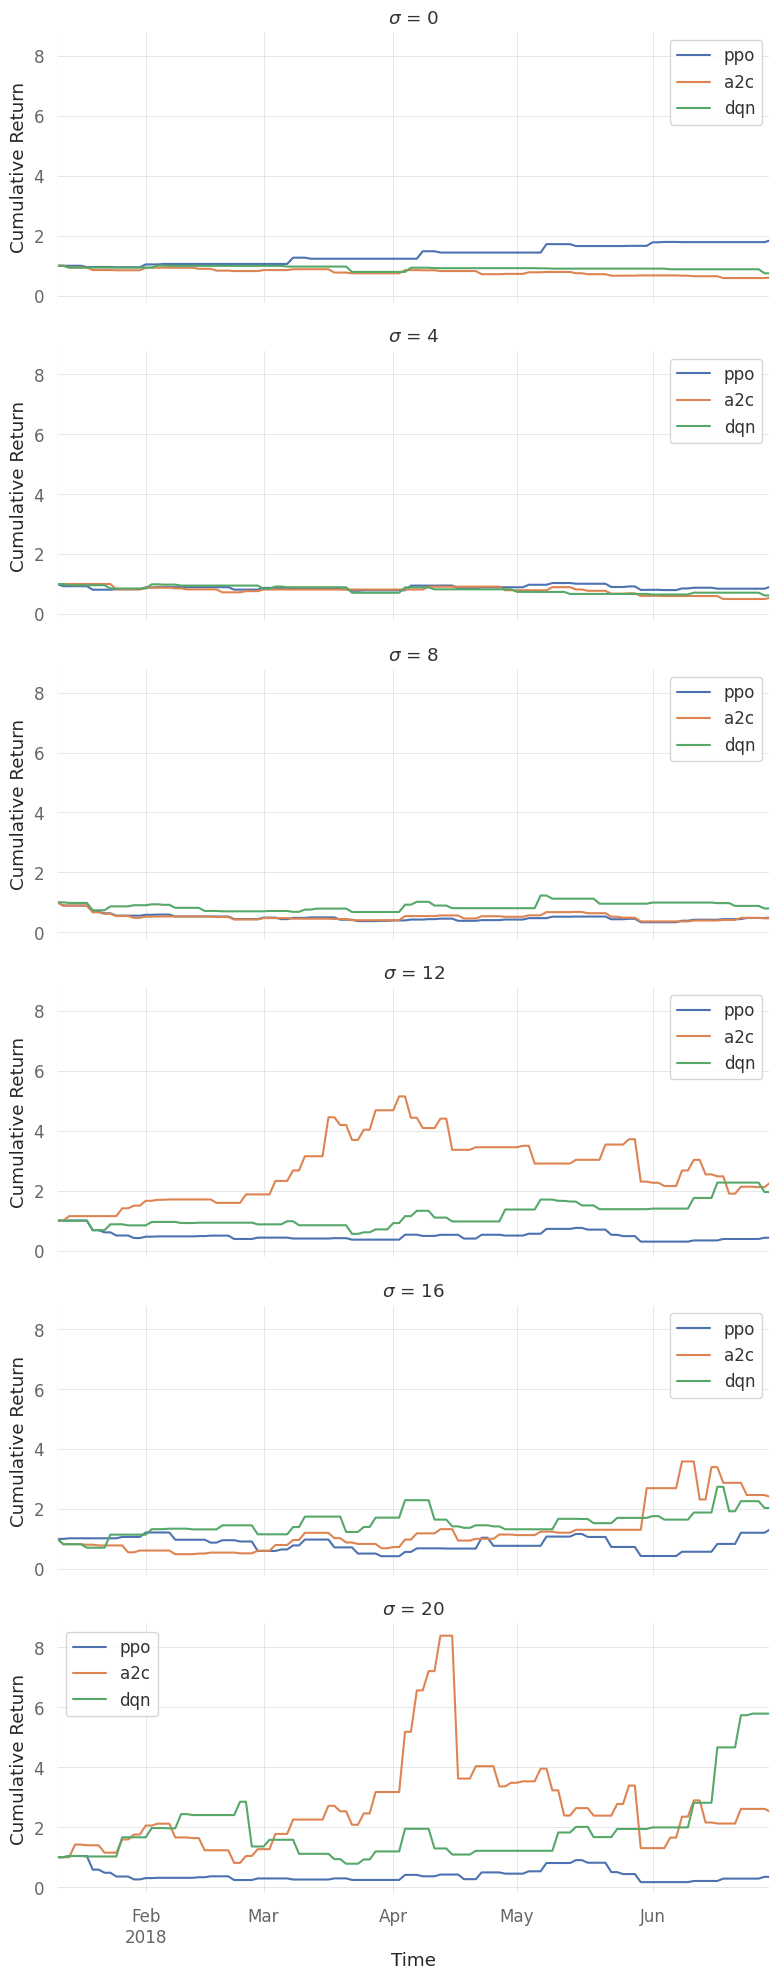

In [ ]:
print("RL Algorithms comparison: Cumulative returns on Validation Set")
profit_plots(val_metrics, val_profit, ignore_mr=True, figsize=(8, 20))

Model comparison on the test set is similar, but DQN performance is noticeably worse in the test set, suggesting that the learnt policy deosn't generalise to unseen periods as well as A2C.

RL Algorithms comparison: Cumulative returns on Test Set


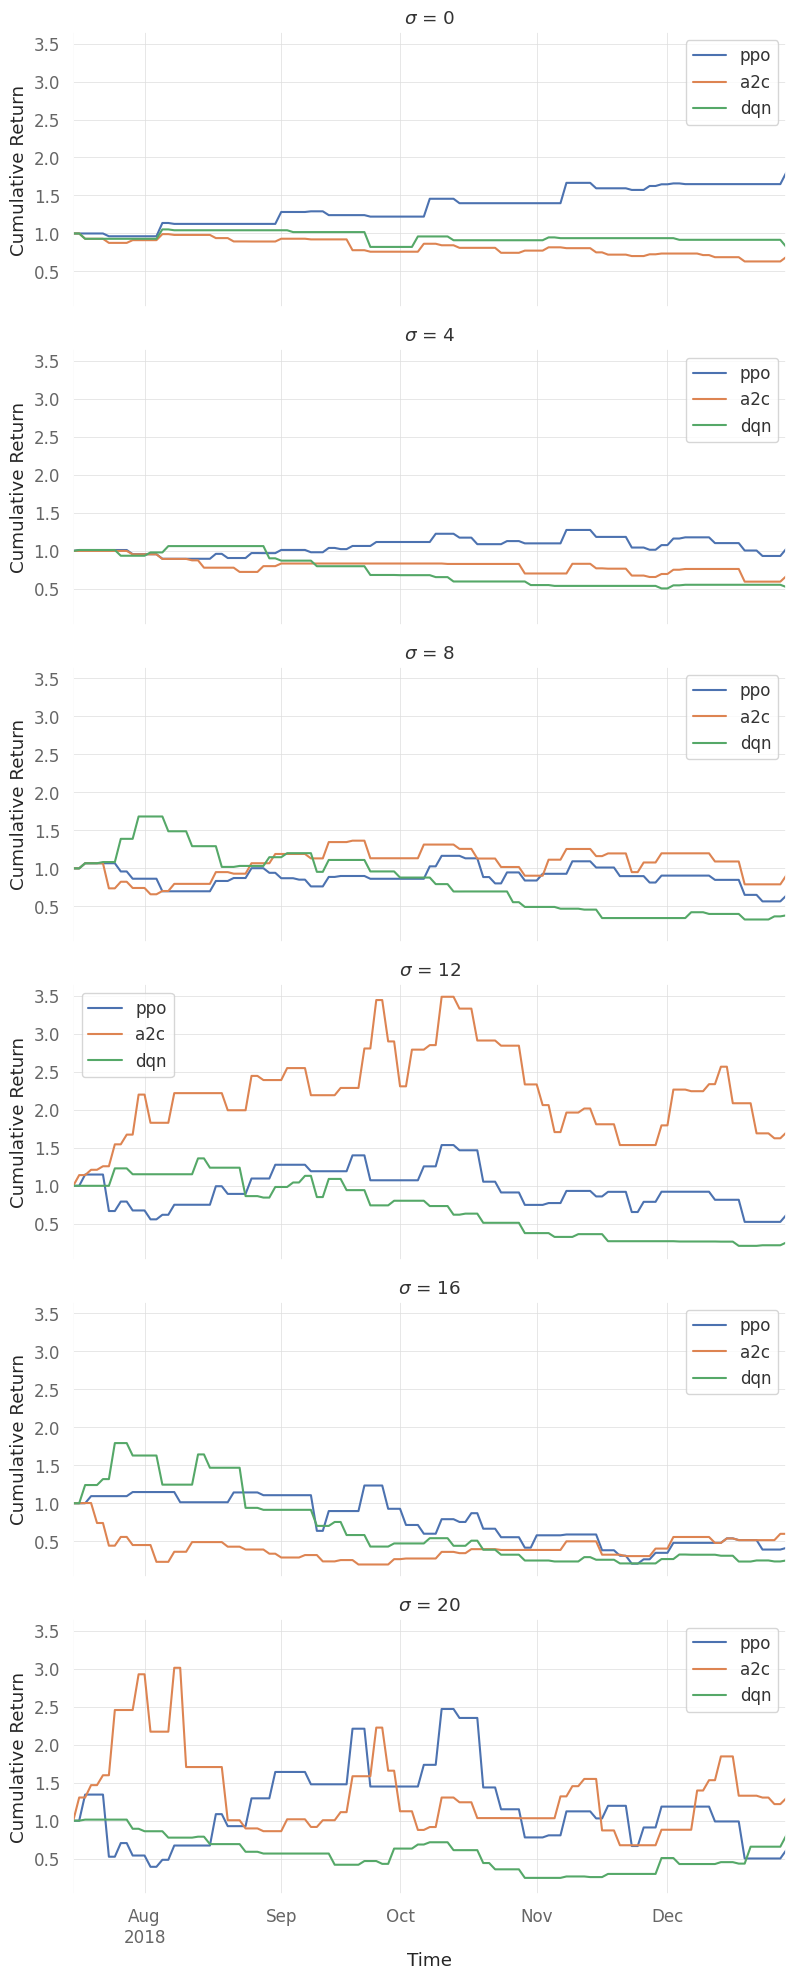

In [ ]:
print("RL Algorithms comparison: Cumulative returns on Test Set")
profit_plots(oot_metrics, oot_profit, ignore_mr=True, figsize=(8, 20))

<a name="sec:metrics-1.5.2"></a>
### **1.5.2 Metrics**

By plotting the metrics for each experiment, we can now see clearly the trend of A2C and DQN beating the bench mark in terms of returns when price is more volatile. We observe the same crossover in sharpe ratio, suggesting that even after we take into account the risk posed by the increased volatility, these models performed better trades in high $\sigma$ experiments. We see from the % in market metric that these models are also spending comparitively less time points in-market when the price is more volatile.

Although, we see that their drawdowns are consistently more severe than the benchmark, which indicates instablity. More on this in the conclusion.

RL Algorithms vs Benchmark: - Metrics on Validation Set by σ


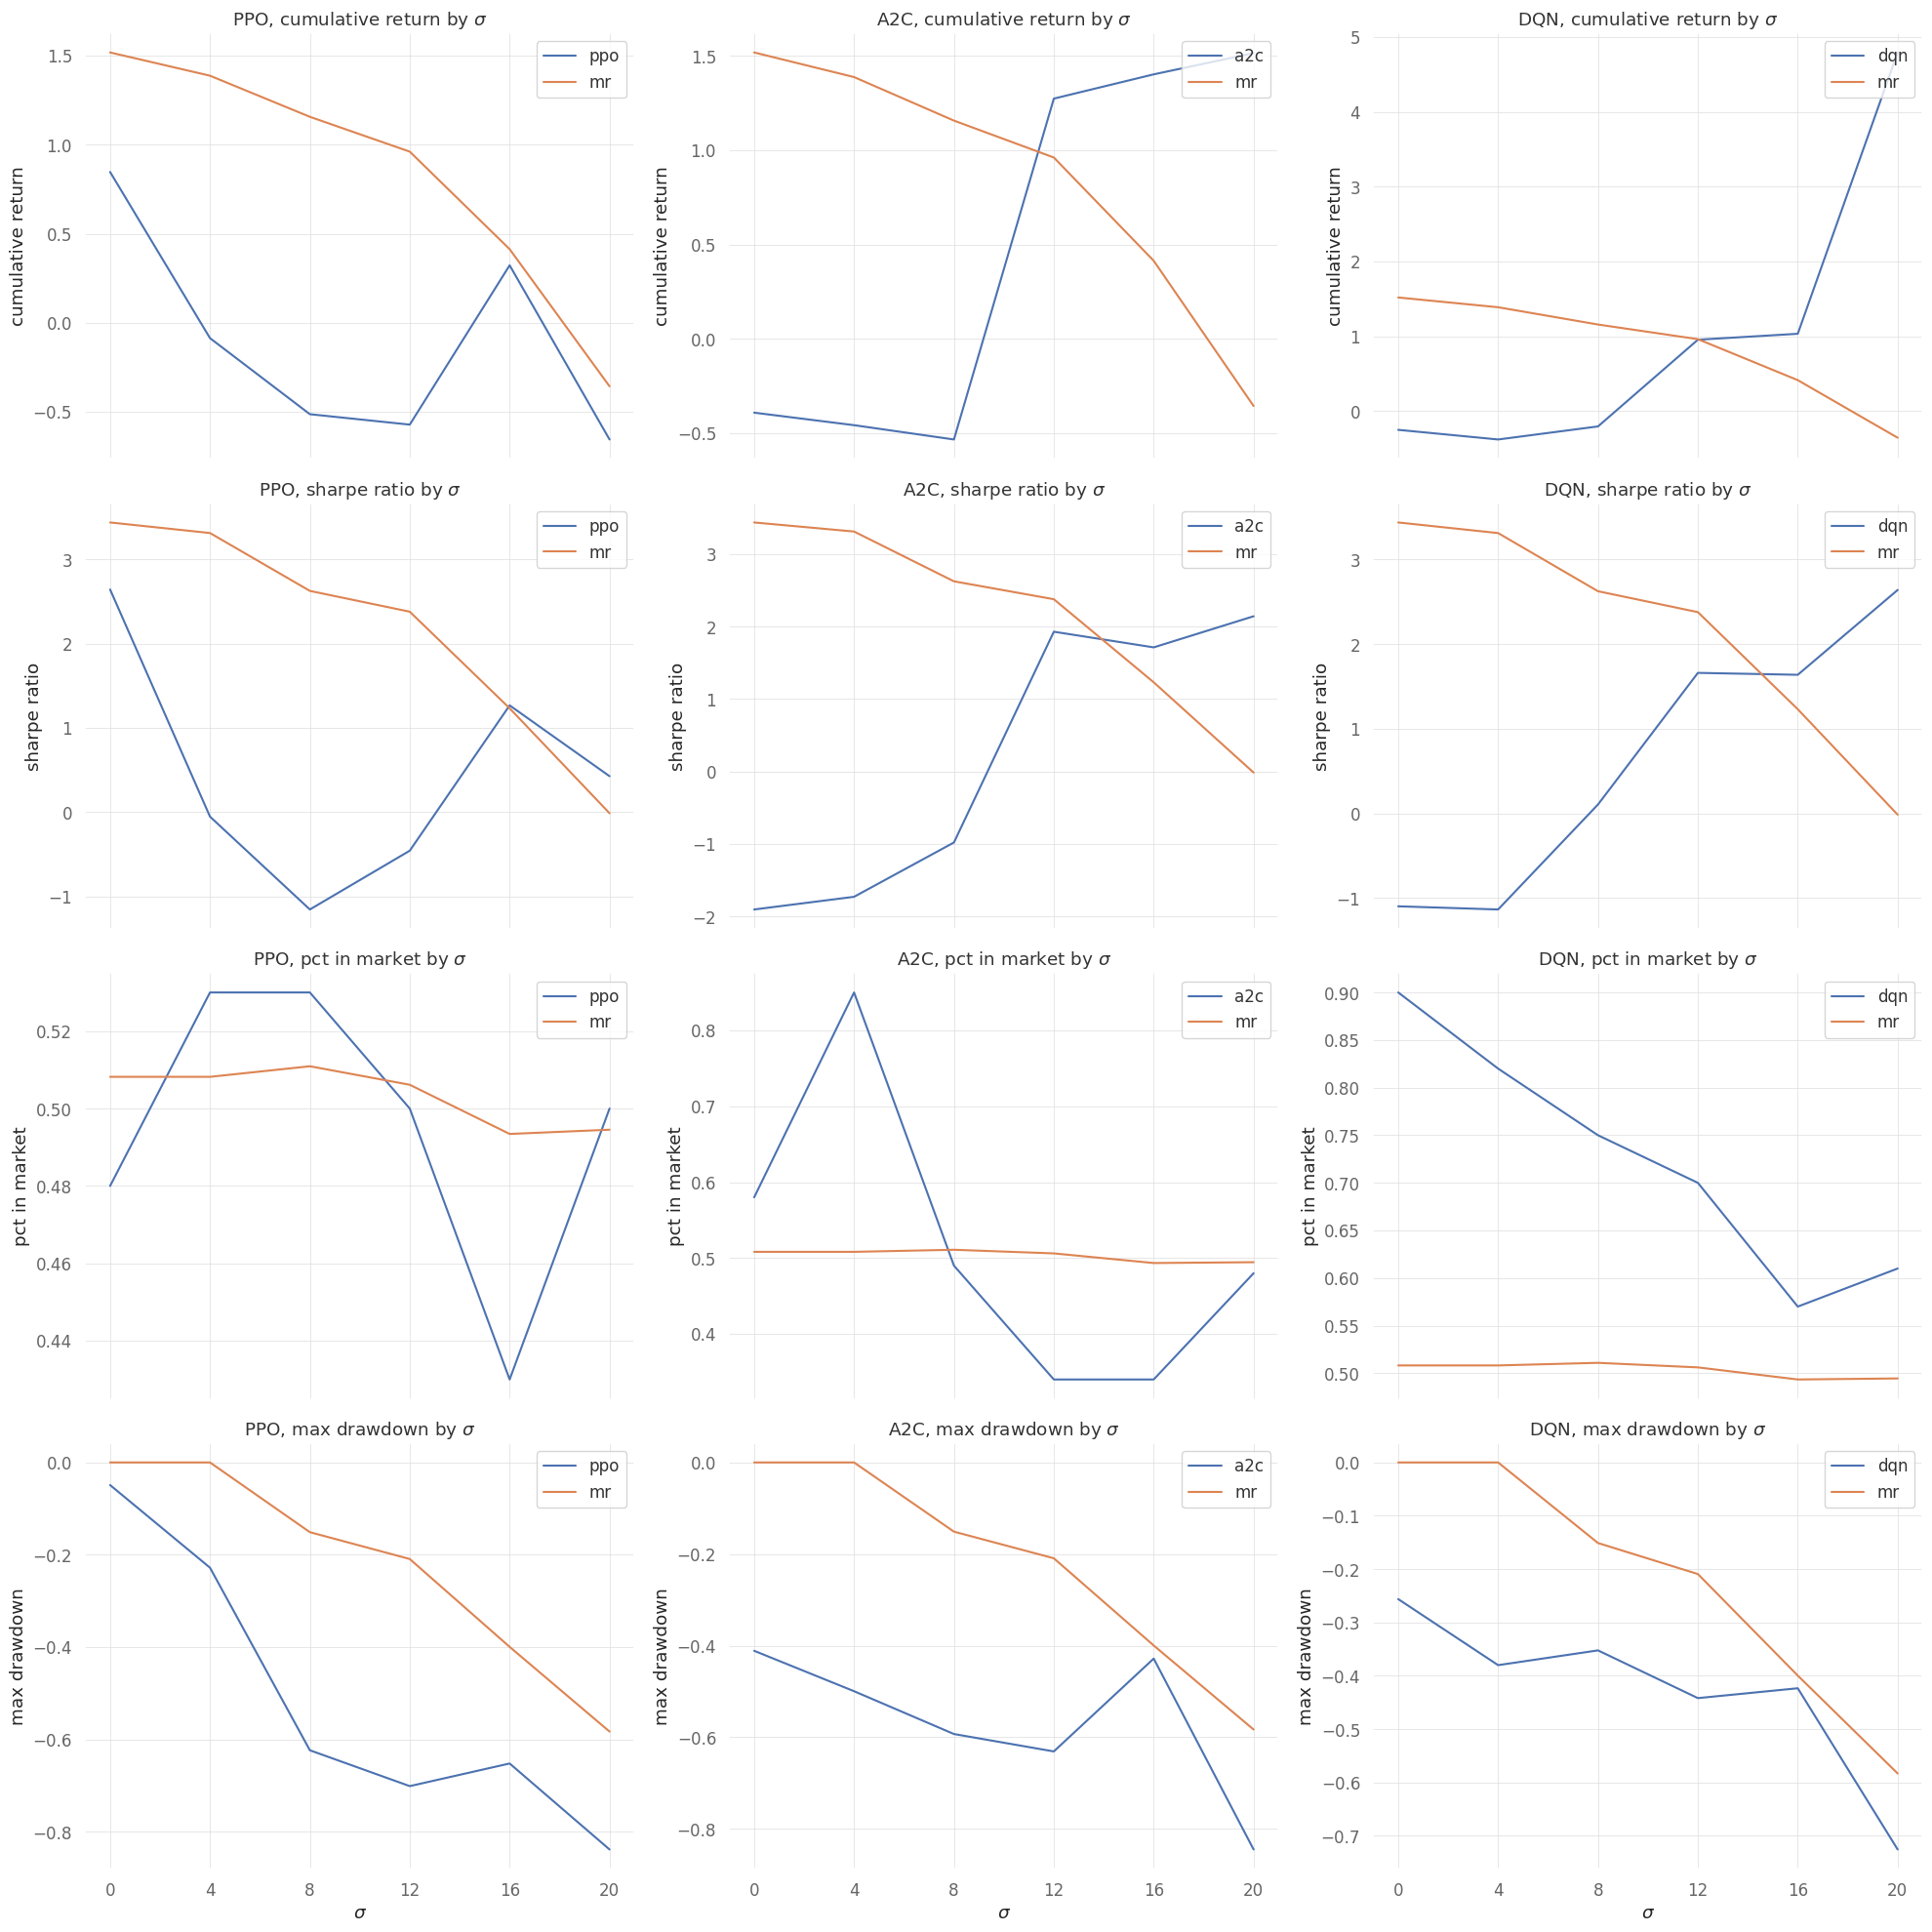

In [ ]:
print("RL Algorithms vs Benchmark: - Metrics on Validation Set by \u03C3")
metric_plots_separate(val_metrics)

Notably, we see consistent improvements in sharpe ratio for A2C and DQN for more volatile price signal, in contrast with PPO which worsens. The drawdowns worse across all models as volatility increases.

RL Algorithms comparison: Metrics on Validation Set by σ


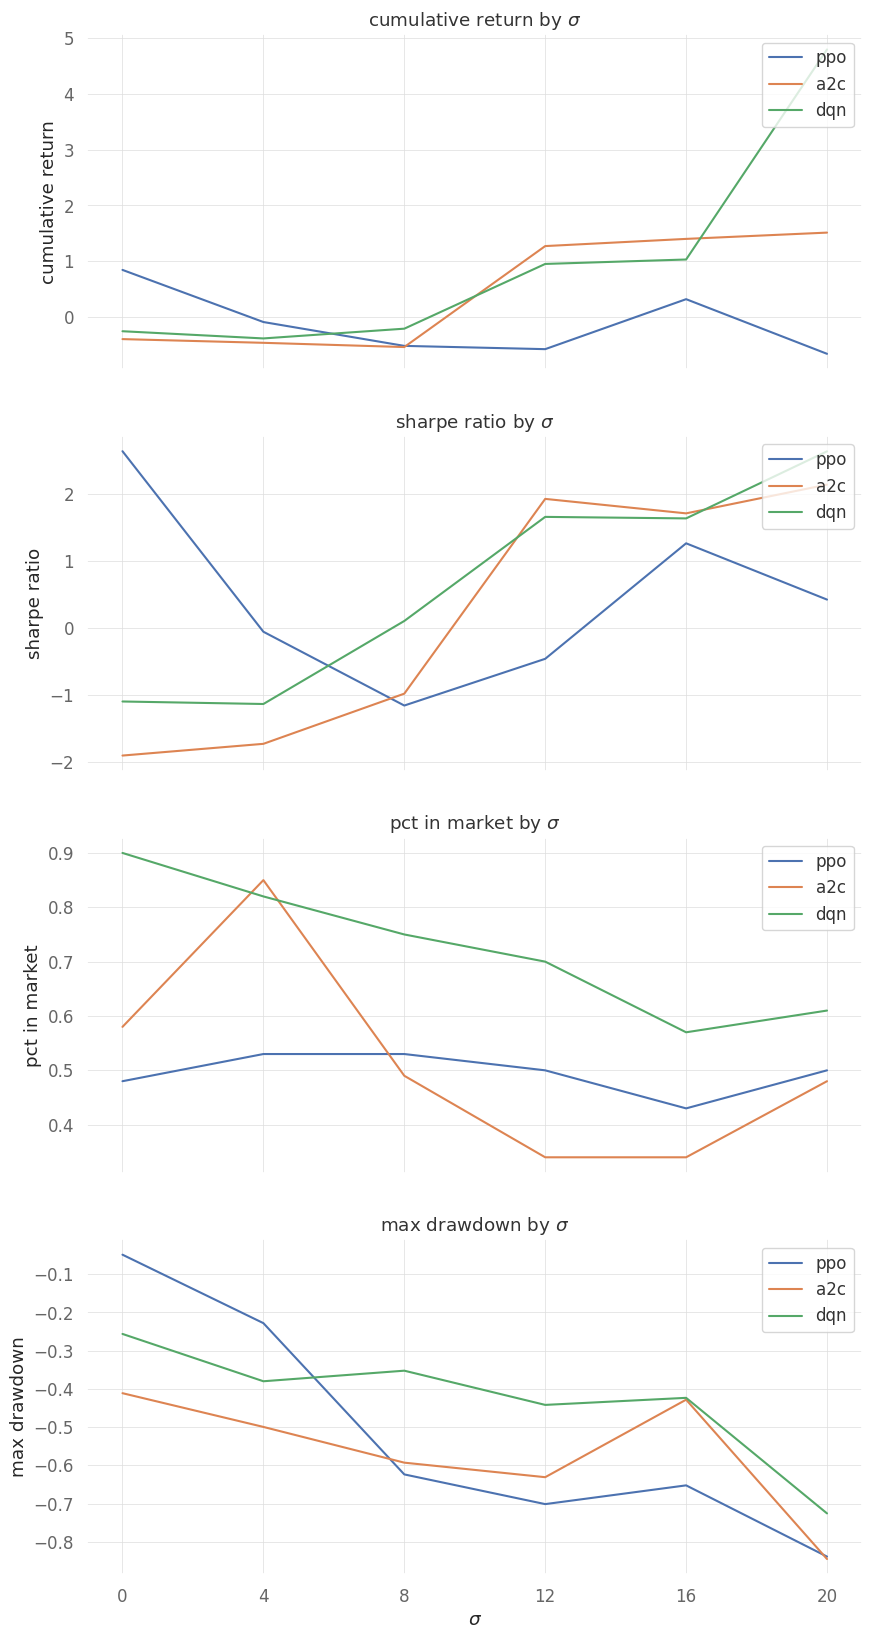

In [ ]:
print("RL Algorithms comparison: Metrics on Validation Set by \u03C3")
metric_plots(val_metrics)

On the test set, the performance of A2C and DQN are relatively worse than in validation, which suggests that the generalization error of these models is unattractive. In the conclusion, we discuss several steps that may alleviate this problem.

RL Algorithms vs Benchmark: - Metrics on Test Set by σ


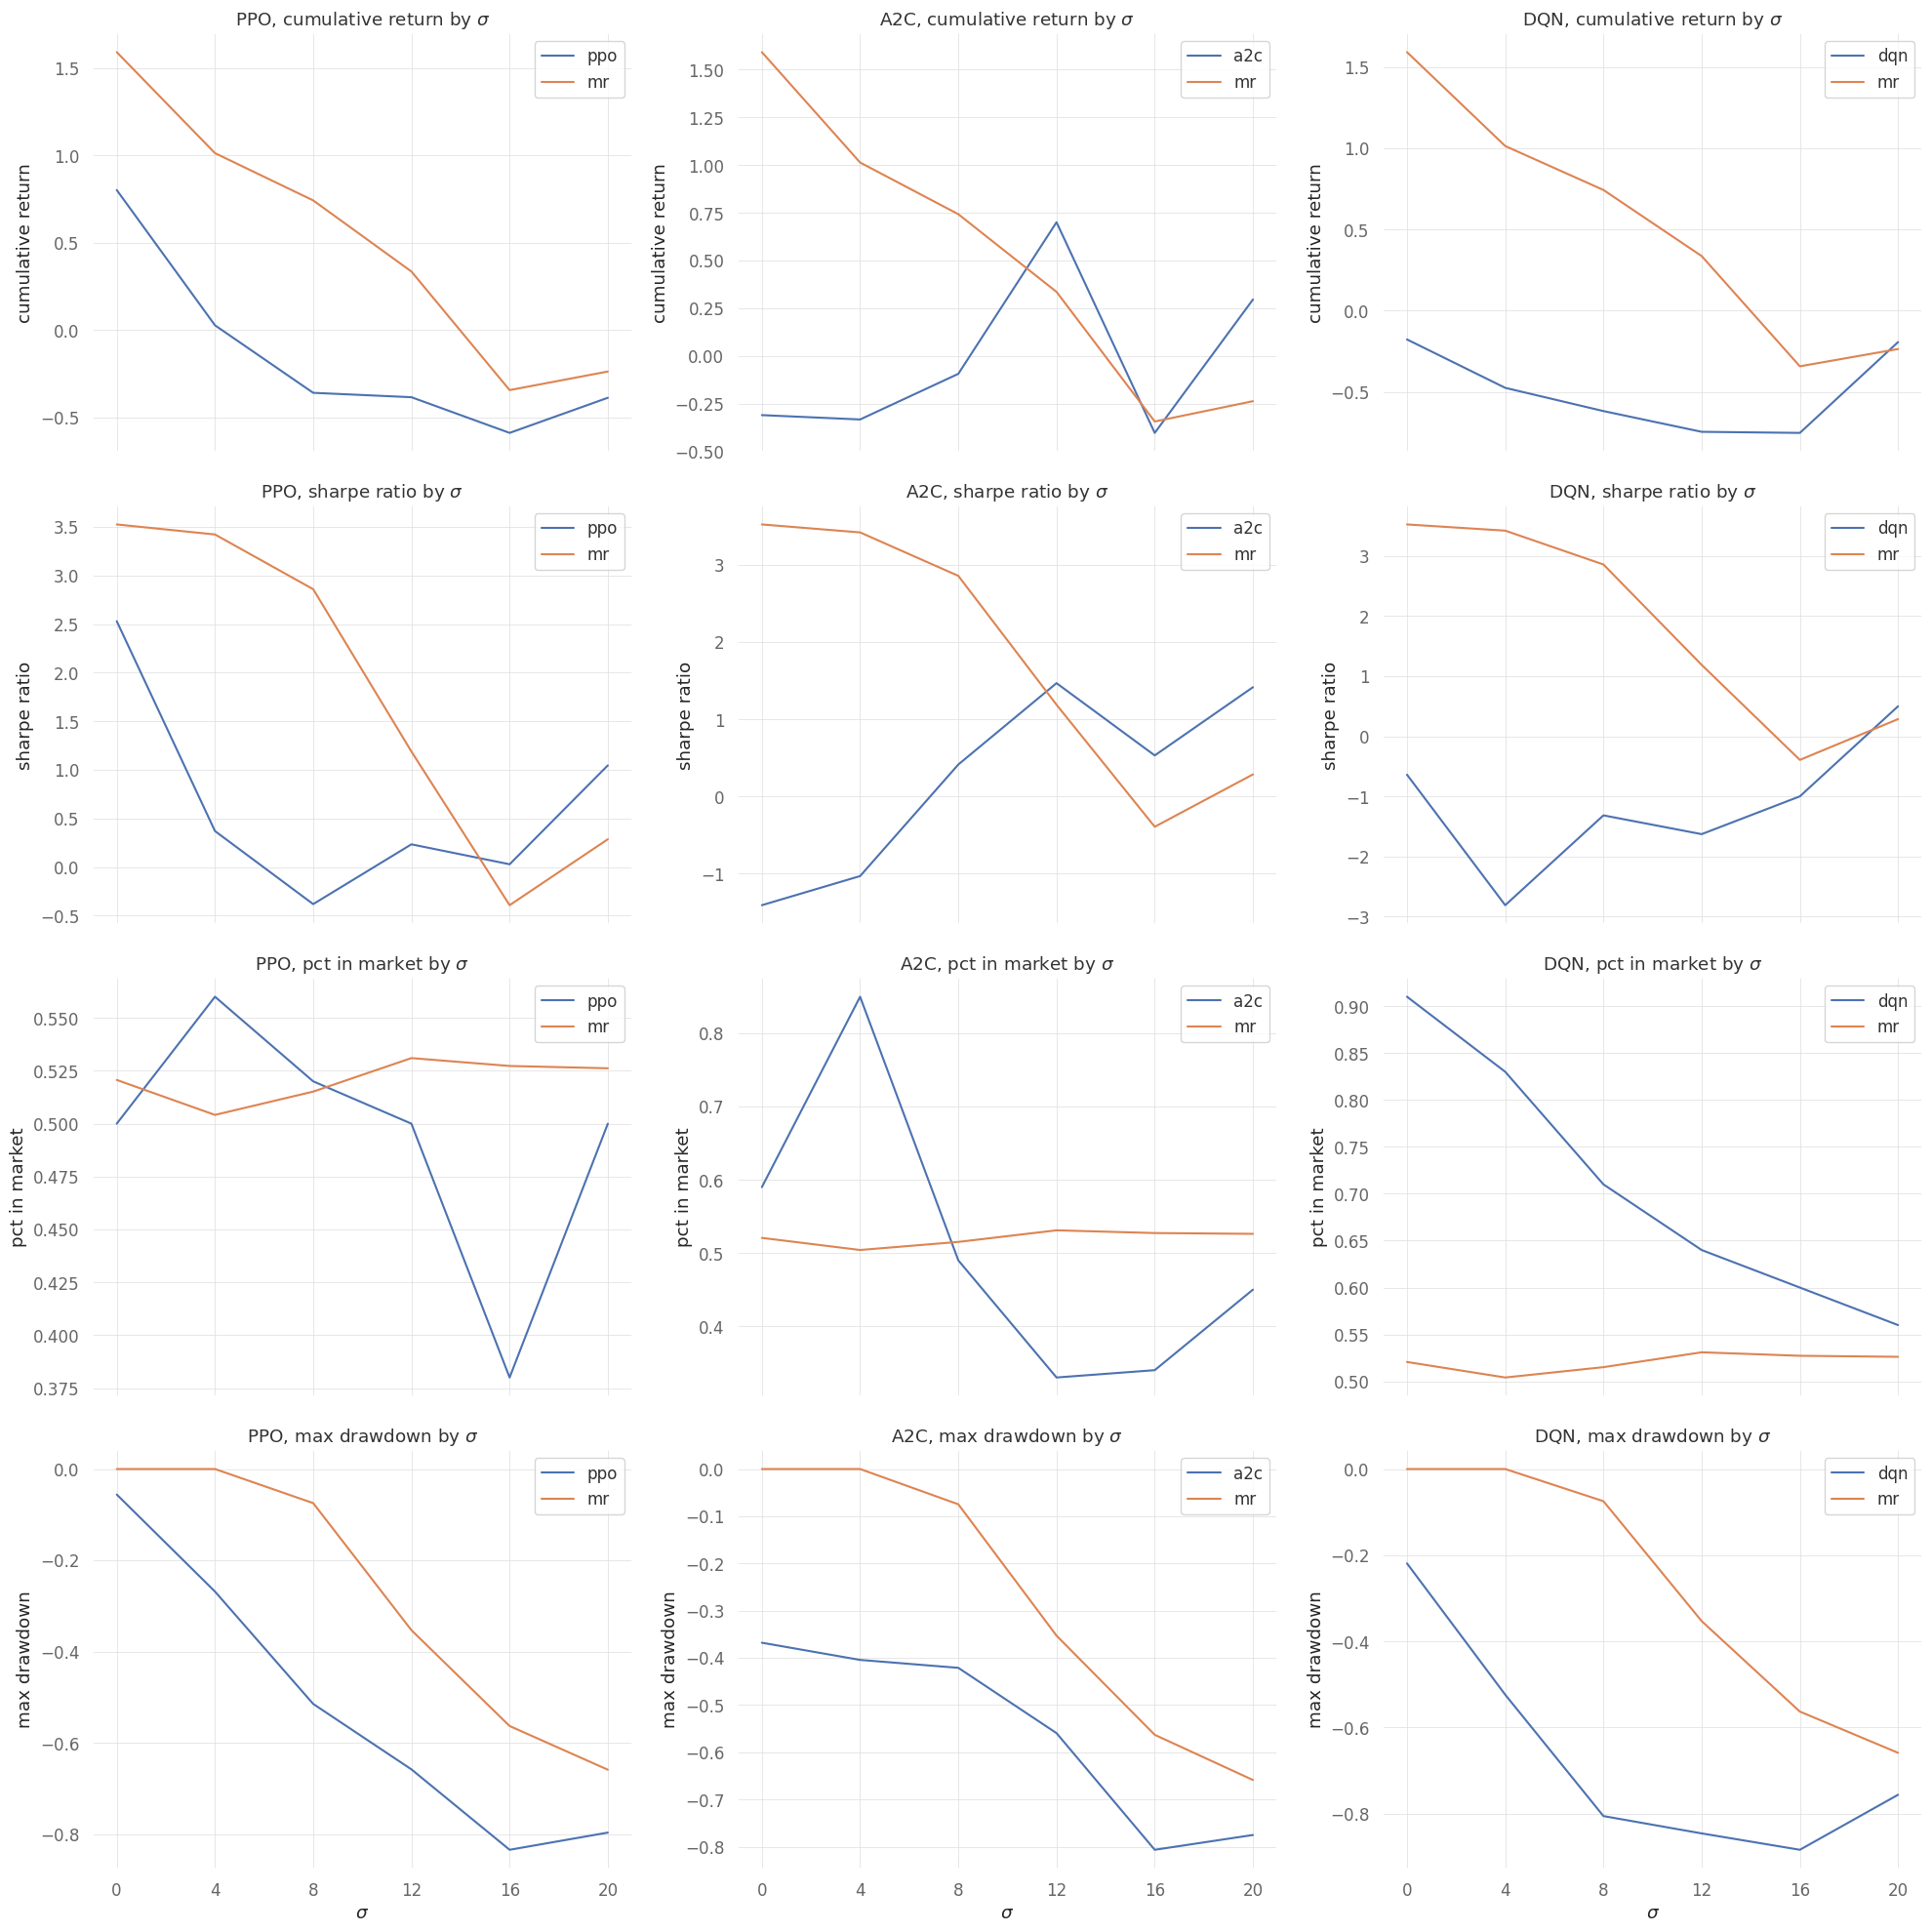

In [ ]:
print("RL Algorithms vs Benchmark: - Metrics on Test Set by \u03C3")
metric_plots_separate(oot_metrics)

In contrast to the validation results, DQN is now outperformed by PPO.

RL Algorithms comparison: Metrics on Test Set by σ


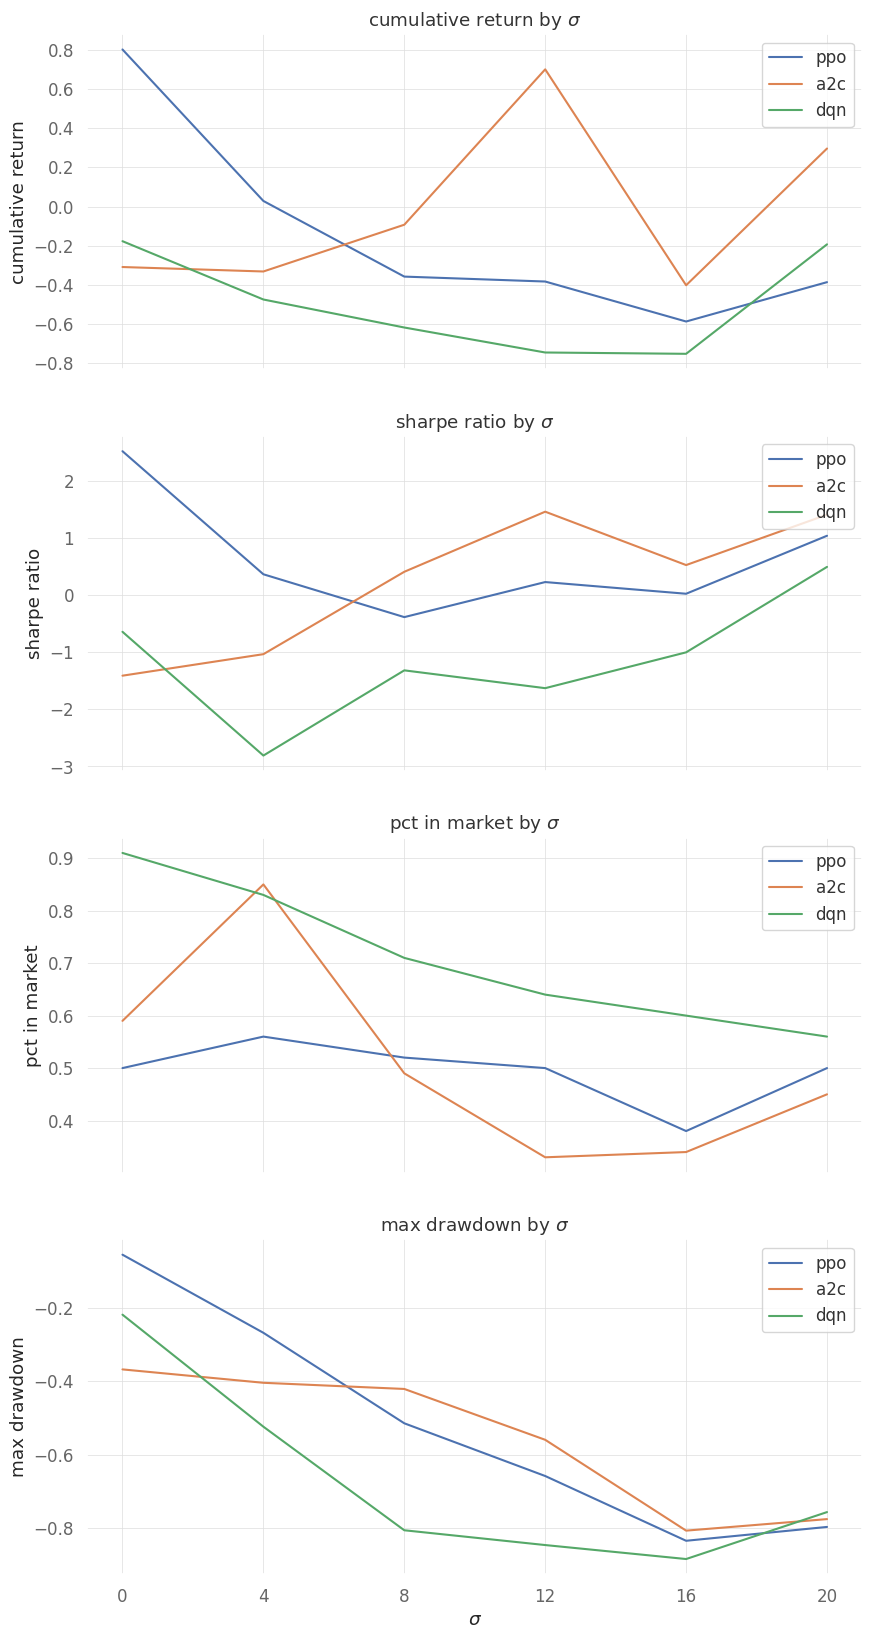

In [ ]:
print("RL Algorithms comparison: Metrics on Test Set by \u03C3")
metric_plots(oot_metrics)

Here we observe the generalization error for the RL models directly, by comparing performance on the validation and out-of-time test periods. The disparities betweem performance on the time periods give insight into model stability and genaralization ability.Note that the validation period was used to select the best model, so positive bias is expected

Generally, model performance in the validation and test sets are correlated,
with the DQN showing the strongest disparities. This is best seen in the cumulative return plot in the top right, where the generalization error grows sharply as $\sigma$ increases.

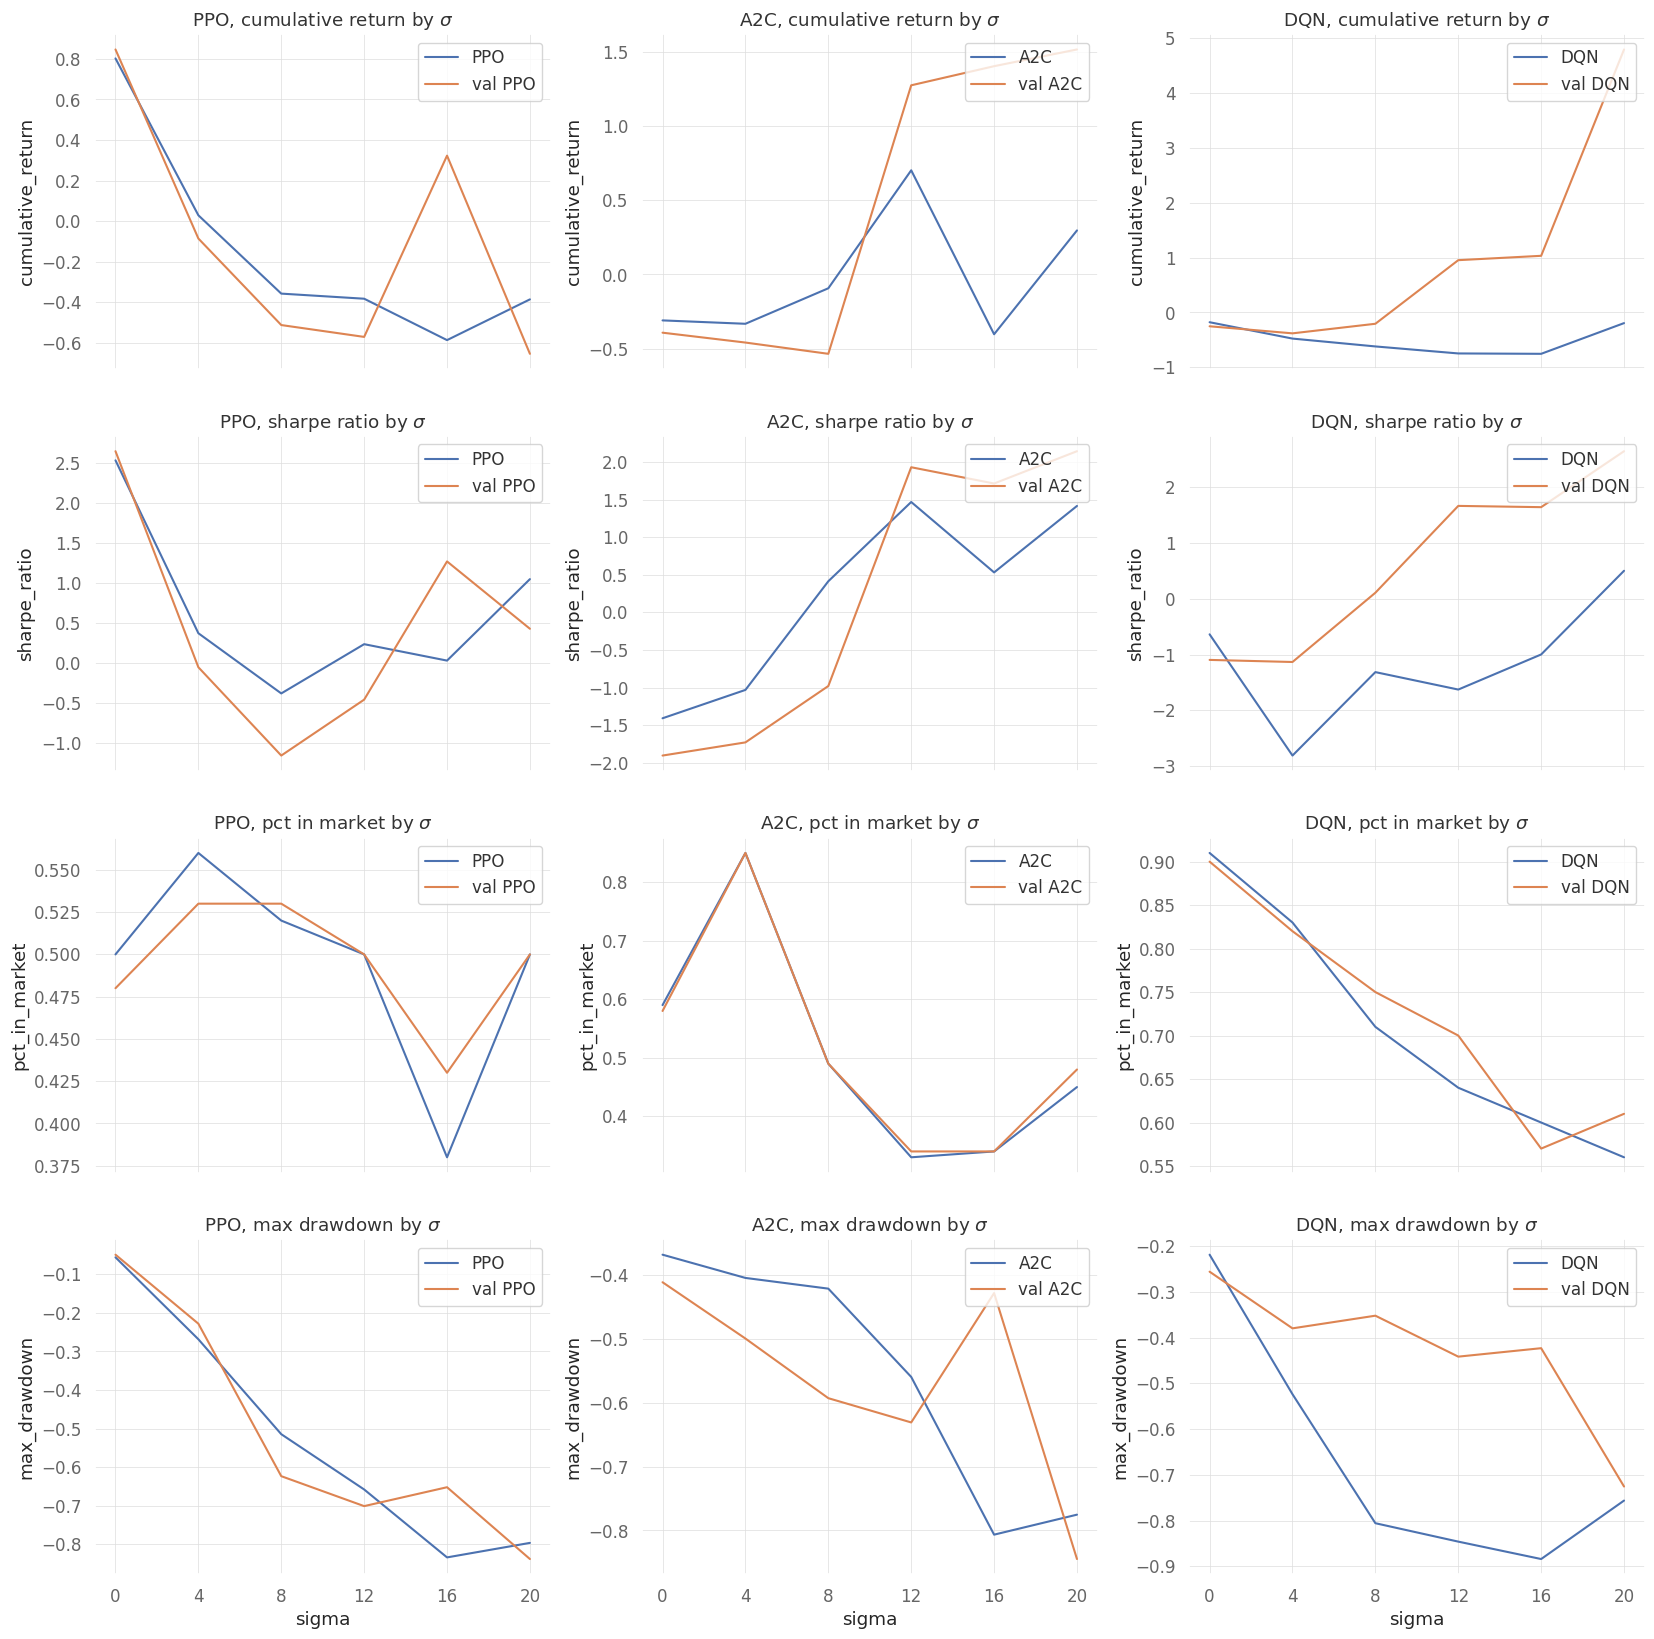

In [ ]:
val_test_plots()

<a name="sec:analysis-results-1.5.3"></a>
### **1.5.3 Analysis Results**
From the plots above observe distinct differences between model performances in every experiment. We also explored the interesting changes in model behaviour as we increase the noise parameter.
<br>

At low sigmas, the mean reversion benchmark ("mr") outperforms all of the algorithms. This is expected as at low noise levels, MR is expected to be optimal or near optimal, since it deterministically buys at low prices, and sells at high prices (See proof in [Section 1.4.4](#sec:mr-proof)).
As noise increases we can see that the advantage weakens, with benchmark underperforming DQN and A2C. In the out-of-time test, A2C still beats the benchmark in high $\sigma$ simulations. At low $\sigma$, PPO outperforms the competing RL models behaving similarly to mean reversion, gradually losing the performance advantage as the level of noise increases, underperforming other algorithms for high noise; this effect being more pronounced in validation than in the out-of-time period. Cumulative returns correlate with the noisiness of the price signal. That is, in the low to mid noise experiments ($\sigma = 0$ to $8$), the cumulative return exhibits low variance.

<br>

In the validation period, as noise increases, the performance of both DQN and A2C improve, beating Mean Reversion and PPO. We observe the same performance crossover in sharpe ratio, suggesting that even after we take into account the risk posed by the increased volatility, DQN and A2C performed better trades in high $\sigma$ experiments. We see from the % in market metric that these models are also spending comparitively less time points in-market when the price is more volatile. But In the test set, DQN becomes unprofitable at high $\sigma$ values, with A2C maintaining profitability for $\sigma = 12$ and $\sigma = 20$.  

It was demonstrated in the OpenRL benchmark that A2C model's are harder to train generally than other RL algorithms like PPO [Huang et al. 2024](https://arxiv.org/abs/2402.03046). But when the A2C was successfully trained, we see promising results; even for the noisy signal (See A2C for $\sigma=12$).
In fact, we observe better performance for AUC on noisy signals, where the price has a higher fluctuation frequency. This was the case on both the validation set and the out-of-time test set. But the cumulative returns were also quite volatile, as we observe in the sharp profit swings in the high $\sigma$ experiments. The impact of price movement frequency on A2C performance was not explored in-depth here, and could be an interesting area for further work.

<br>

#### **Generalization of RL models to unseen periods**
We then examine the disparity between validation and test performance. As expected, the models performed better in the validation period than the test. The difference was most dramatic in the DQN performance, as is shown in the third column of plots above. This indicates that the learnt policy is sensitive to exact states. This is not a desirable behaviour in RL trading agents, so steps must be taken to avoid this in practice.

Better performance may be achieved through hyperparameter tuning, such as epsilon value in PPO, or the size of the replay window in DQN. These may be optimised via grid search or baysian optimization. We may also try different neural network architectures in the case of DQN. In the second half of this project, we explore several of these ideas using real market data.

<br>


# **2. Application of DQN, PPO and A2C to Forex trading**  ($\text{EUR} \Leftrightarrow \text{USD}$)

Forex trading involves the simultaneous buying and selling of world currencies on a decentralized global market.

***EUR_USD*** is the most liquid currency pair, which means it has the highest trading volume in the forex markets. ([João Carapuço et al., 2018](https://www.sciencedirect.com/science/article/pii/S1568494618305349?casa_token=lHq9UqzvogAAAAAA:eHrp9yh9kwNnGp1obLGO3t68XQZxTQQ5qj_DMTodQrSnLjG21lJB8vG6t9EhP-ja4l3RYJxMpA))

This high liquidity results in tighter spreads and lower transaction costs, making it attractive for frequent trading, such as scalping or high-frequency trading strategies. That is why using reinforcement learning algorithms provides an opportunity to find the strategies profitable for traders choosing this pair.

<br>

By modeling the EUR/USD pair, traders can capitalize on its high liquidity, sensitivity to major economic events, and the robustness of technical patterns

**Rationale for the choice of the year**

The year 2017 was pivotal for EUR/USD traders due to political and economic events in Europe and the United States that influenced forex markets (both for USD and EUR).

- In Europe, the political landscape stabilized following Emmanuel Macron's victory in the French presidential elections, boosting investor confidence in the euro. The Eurozone experienced a robust economic recovery, outperforming expectations and making the favorable view of euro

- Conversely, the U.S. faced political uncertainties with the onset of Donald Trump presidency. This uncertainty often led to a weaker dollar.
- Also, monetary policy paths diverged significantly. The European Central Bank continued quantitative easing program, while the Federal Reserve began tightening monetary policy.

This played a crucial role in the fluctuations and heightened trading activity of the EUR/USD currency pair throughout 2017. That is why when considering this particular trading pair, it is of interest to investigate the trading activity of 2017, focusing on month with historically different market behaviour.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

dataset = pd.read_csv('/content/drive/MyDrive/pyfinance.csv')
dataset['date'] = pd.to_datetime(dataset['date'])

desired_month = 3  # For March - final month in a financial year
desired_year = 2017

df = dataset[(dataset['date'].dt.month == desired_month) & (dataset['date'].dt.year == desired_year)]

df.set_index('date', inplace=True)
df
window_size = 180  # Example: looking back 180 minutes (3 hours)
start_date = "2017-03-01"
end_date = "2017-03-31"

filtered_data_dqn = df[start_date:end_date]

start_index = window_size
end_index = len(filtered_data_dqn)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Seed
import random
import torch

seed = 42

np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


<a name="sec:DQN-architecture-impact-2.1"></a>
## **2.1. DQN architecture impact in investment/trading strategy**


The objective of this part is to investigate the impact of varying DQN architectures on the distribution of trading positions (Long, Short, Flat) and actions (Buy, Hold, Sell, Double Buy, Double Sell) over time. We also aim to explore how these distributions evolve as the model experiences more market scenarios, with the hypothesis that an increase in the number of training timesteps will lead to a more diversified action distribution. This hypothesis rests on the premise that extended exposure to a wide array of market conditions allows the DQN to learn a more nuanced strategy, thereby reducing the likelihood of overfitting to specific market trends and increasing the model's adaptability. [Chen & Gao, 2019](https://ieeexplore.ieee.org/abstract/document/9040728?casa_token=lpF5cSyfTIQAAAAA:fdAQmkDv6_OKUTod1bPy-cVpHIfZlf4fzaP5tEPFcmVbTf_gQZ9kPtmS_KmoosPQ2UHqEbyaU9XNXQ) researched the impact of the number of layers on the performance of the model. This study closes the gap with the dependence of actions and positions distributions in answer to layers enhancements in DQN architecture.

<a name="sec:Custom Environment-2.1.1"></a>
### **2.1.1. Custom Environment (upgrading gym_anytrading with new positions and actions)**


- **Action Space**: `Discrete` action space with 5 possible actions (`DOUBLE_SELL`, `SELL`, `HOLD`, `BUY`, `DOUBLE_BUY`) -  more complex compared to the `gym_anytrading` environment, which typically only has `Buy` and `Sell` actions.
- **State/Position Representation**: `SHORT`, `FLAT`, and `LONG`, while `gym_anytrading` environment doesn't include a `FLAT` position. In previous environment, if previous position was 'SHORT' (potentially selling asset) but in the next period trader did not do any actions, the position would still be 'SHORT', it changes only when action happens. That is why adding a 'FLAT' is of interest. ([Abdillah Baradja et al., 2023](https://ieeexplore.ieee.org/abstract/document/10461955?casa_token=bJ1WW9OtAUgAAAAA:OBbM1PPQ_n_Be29yZr0vcf_-4Igq1FU5Onv8TnTKZu1xm2PRV4qzv6HhU8Im1rVzQDa6vZqiEyfy))
- **Transformation Function**:  `transform` function updates the position based on the current position and action taken, with additional logic to handle the `DOUBLE_SELL` and `DOUBLE_BUY`

- **Reward Calculation**: considers both the direction of the position and a trade fee percentage
- **Observation Space**: includes several financial indicators (prices, highs, lows, volumes) along with the current position and normalized time since the last trade (gym_anytrading environment only covers closing price and price differences)
- **Maximum Possible Profit**:assume a perfect foresight strategy (buying at the lowest price and selling at the highest)

<br>

**Double Buy** :
1. **Returning Borrowed Shares**: if the agent has any shares borrowed from a securities firm (a short selling), they are returned
2. **Purchasing New Shares**: the agent uses all available cash to purchase new shares at the current market price

This action is aggressive, as it not only covers any existing short positions but also commits all cash reserves to new stock purchases, increasing risk if the market moves unfavorably

<br>

**Double Sell**:
1. **Selling Owned Stocks**: sells all the stocks they currently own,  converting all held equities into cash (basic sell action)
2. **Selling Borrowed Stocks**: sells stocks that have been borrowed from a securities company with the obligation to repurchase them later. The goal here is to benefit from a decline in stock prices. This is agressive and risky, because trader should be really confident in future market fluctuations.



In [ ]:
class Actions(Enum):
    DOUBLE_SELL = 0
    SELL = 1
    HOLD = 2
    BUY = 3
    DOUBLE_BUY = 4

class Positions(Enum):
    SHORT = -1
    FLAT = 0
    LONG = 1

def transform(position: Positions, action: int) -> (Positions, bool):
    if action == Actions.SELL.value:
        return (Positions.SHORT if position == Positions.FLAT else Positions.FLAT, True)
    elif action == Actions.BUY.value:
        return (Positions.LONG if position == Positions.FLAT else Positions.FLAT, True)
    elif action == Actions.DOUBLE_SELL.value:
        return (Positions.SHORT, True)
    elif action == Actions.DOUBLE_BUY.value:
        return (Positions.LONG, True)
    return (position, False)

class CustomEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, df, window_size, frame_bound, seed = None):
        super().__init__()
        self.seed(seed)
        self.df = df
        self.window_size = window_size
        self.frame_bound = frame_bound

        self.trade_fee_bid_percent = 0.0001
        self.trade_fee_ask_percent = 0.0001

        self.action_space = spaces.Discrete(len(Actions))
        self._action_history = []
        self._position_history = []
        self.prices, self.signal_features = self._process_data()
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self._get_observation_shape(),), dtype=np.float32)
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]


    def _process_data(self):
        prices = self.df['Close'][self.frame_bound[0]-self.window_size:self.frame_bound[1]].values
        highs = self.df['High'][self.frame_bound[0]-self.window_size:self.frame_bound[1]].values
        lows = self.df['Low'][self.frame_bound[0]-self.window_size:self.frame_bound[1]].values
        volumes = self.df['Volume'][self.frame_bound[0]-self.window_size:self.frame_bound[1]].values
        diffs = np.insert(np.diff(prices), 0, 0)  #
        avg_prices = (highs + lows + prices) / 3
        signal_features = np.column_stack((prices, diffs, highs, lows, avg_prices, volumes))
        return prices, signal_features

    def _calculate_reward(self, action):
        current_price = self.prices[self.current_tick]
        last_trade_price = self.prices[self.last_trade_tick]
        price_diff = current_price - last_trade_price
        reward = 0.0
        if self.position == Positions.LONG:
            reward = (price_diff - self.trade_fee_ask_percent) * 10000
        elif self.position == Positions.SHORT:
            reward = (-price_diff - self.trade_fee_bid_percent) * 10000
        return reward

    def _get_observation(self):
        base_obs = self.signal_features[self.current_tick - self.window_size + 1 : self.current_tick + 1].flatten()
        additional_data = np.array([self.position.value, (self.current_tick - self.last_trade_tick) / self.eps_length])

        full_obs = np.concatenate([base_obs, additional_data])
        expected_shape = self._get_observation_shape()
        return full_obs

    def _get_observation_shape(self):
        num_features_per_tick = self.signal_features.shape[1]
        total_features = num_features_per_tick * self.window_size + 2  # +2 for additional data
        return total_features

    def step(self, action):
        self.position, trade = transform(self.position, Actions(action).value)
        reward = self._calculate_reward(action) if trade else 0
        self.total_reward += reward

        correct_index = self.current_tick + self.frame_bound[0] - self.window_size
        self._action_history.append((action, correct_index))
        self._position_history.append((self.position.value, correct_index))

        self.current_tick += 1
        done = self.current_tick >= self.frame_bound[1]
        obs = self._get_observation()
        info = {"trade_made": trade}
        return obs, reward, done, info

    def reset(self):
        self.current_tick = self.window_size
        self.last_trade_tick = self.current_tick - 1
        self.position = Positions.FLAT
        self.total_reward = 0
        self.prices, self.signal_features = self._process_data()
        self.eps_length = self.frame_bound[1] - self.frame_bound[0]
        self._action_history.clear()
        self._position_history.clear()
        return self._get_observation()


    def max_possible_profit(self):
        # Buy at the lowest, sell at the highest
        min_price = np.min(self.prices)
        max_price = np.max(self.prices)
        if min_price == max_price:
            return 0
        return (max_price - min_price) / min_price

    def render_positions(self, mode='human', close=False):
        if close:
            plt.close()
            return

        if mode == 'human':
            plt.figure(figsize=(15, 7))
            plt.plot(self.prices, label='Price', color='blue')

            short_indices = [index for position, index in self._position_history if position == Positions.SHORT.value]
            flat_indices = [index for position, index in self._position_history if position == Positions.FLAT.value]
            long_indices = [index for position, index in self._position_history if position == Positions.LONG.value]

            if short_indices:
                plt.scatter(short_indices, [self.prices[i] for i in short_indices], color='red', label='Short', marker='v', alpha=0.5)
            if flat_indices:
                plt.scatter(flat_indices, [self.prices[i] for i in flat_indices], color='gray', label='Flat', marker='o', alpha=0.5)
            if long_indices:
                plt.scatter(long_indices, [self.prices[i] for i in long_indices], color='green', label='Long', marker='^', alpha=0.5)

            plt.title('Position Changes Over Price')
            plt.xlabel('Ticks')
            plt.ylabel('Price')
            plt.legend()
            plt.show()




    def render_action_distribution(self):
        action_counts = Counter([action for action, _ in self._action_history])
        actions = list(action_counts.keys())
        counts = list(action_counts.values())

        total = sum(counts)
        percentages = [count / total * 100 for count in counts]
        labels = [Actions(action).name for action in actions]

        fig, ax = plt.subplots()
        ax.pie(percentages, labels=labels, autopct='%1.1f%%', startangle=90)
        ax.axis('equal')  # Equal aspect ratio ensures the pie is circular.
        ax.set_title('Action Distribution')
        plt.show()

    def render_position_distribution(self):
        position_counts = Counter([position for position, _ in self._position_history])
        positions = list(position_counts.keys())
        counts = list(position_counts.values())

        total = sum(counts)
        percentages = [count / total * 100 for count in counts]
        labels = [Positions(position).name for position in positions]

        fig, ax = plt.subplots()
        ax.pie(percentages, labels=labels, autopct='%1.1f%%', startangle=90)
        ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
        ax.set_title('Position Distribution')
        plt.show()

    def render_distributions(self):
        position_counts = dict(Counter([pos for pos, idx in self._position_history]))
        positions = list(position_counts.keys())
        action_counts = dict(Counter([act for act, idx in self._action_history]))
        actions = list(action_counts.keys())

        fig, axs = plt.subplots(1, 2, figsize=(15, 7))
        labels_pos = [Positions(position).name for position in positions]
        labels_act = [Actions(action).name for action in actions]
        axs[0].pie(position_counts.values(), labels=labels_pos, autopct='%1.1f%%')
        axs[0].set_title('Positions Distribution')

        axs[1].pie(action_counts.values(), labels=labels_act, autopct='%1.1f%%')
        axs[1].set_title('Actions Distribution')

        plt.show()


<a name="sec:Training-2.1.2"></a>
### **2.1.2 Model Training**

In [ ]:
env = CustomEnv(df=filtered_data_dqn, window_size=window_size, frame_bound=(start_index, end_index), seed = seed)

env.reset()
vec_env = DummyVecEnv([lambda: env])  # Wrap the environment
vec_env.seed(seed)

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


[42]

In [ ]:
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv

model = DQN(
    policy="MlpPolicy",
    env=vec_env,
    seed = seed,
    learning_rate=0.0005,
    buffer_size=50000,
    learning_starts=1000,
    batch_size=32,
    tau=1.0,
    gamma=0.99,
    train_freq=4,
    gradient_steps=1,
    exploration_fraction=0.1,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.1,
    max_grad_norm=10,
    verbose=1,
    tensorboard_log="./dqn_forex_tensorboard/",
)

total_timesteps = len(filtered_data_dqn)-2*window_size
model.learn(total_timesteps=total_timesteps)
model.save("dqn_forex_trading_model")




Using cpu device
Logging to ./dqn_forex_tensorboard/DQN_1


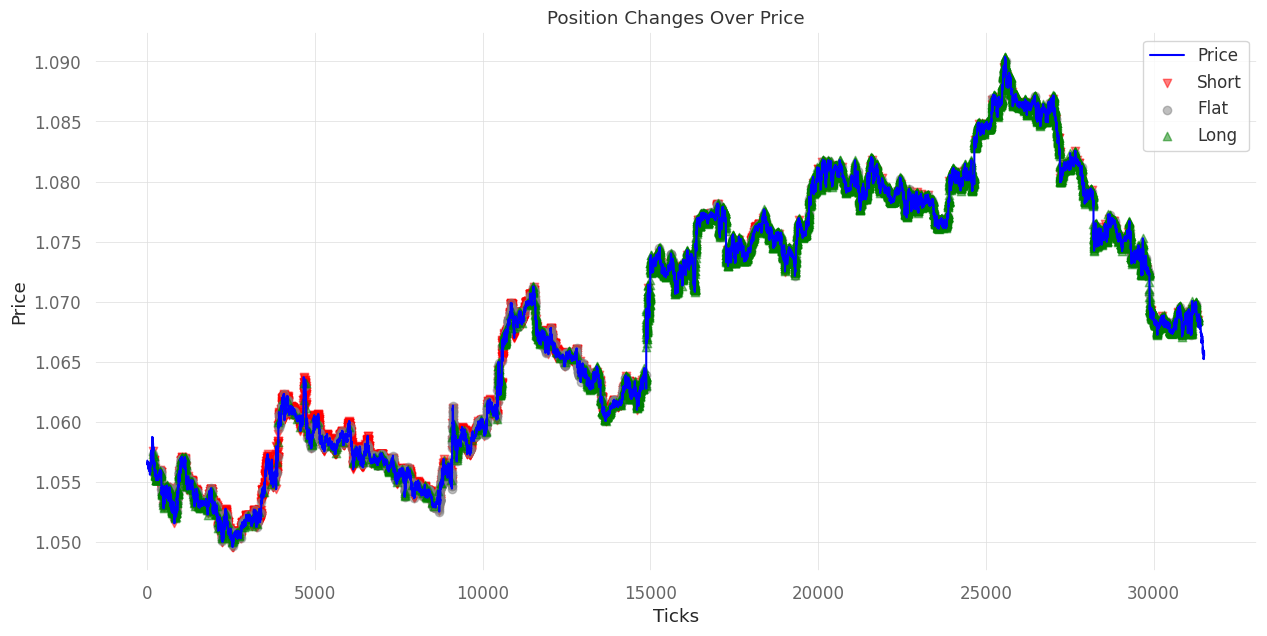

In [ ]:
env.render_positions()

This demonstrates that closer to the second half, the agent starts to be more cautious with selling: it is more frequently in long position, probably waiting for a favourable state of market. This behaviour shows that the model learns how to fit the market behaviour and propose the better strategy, depending on the conditions

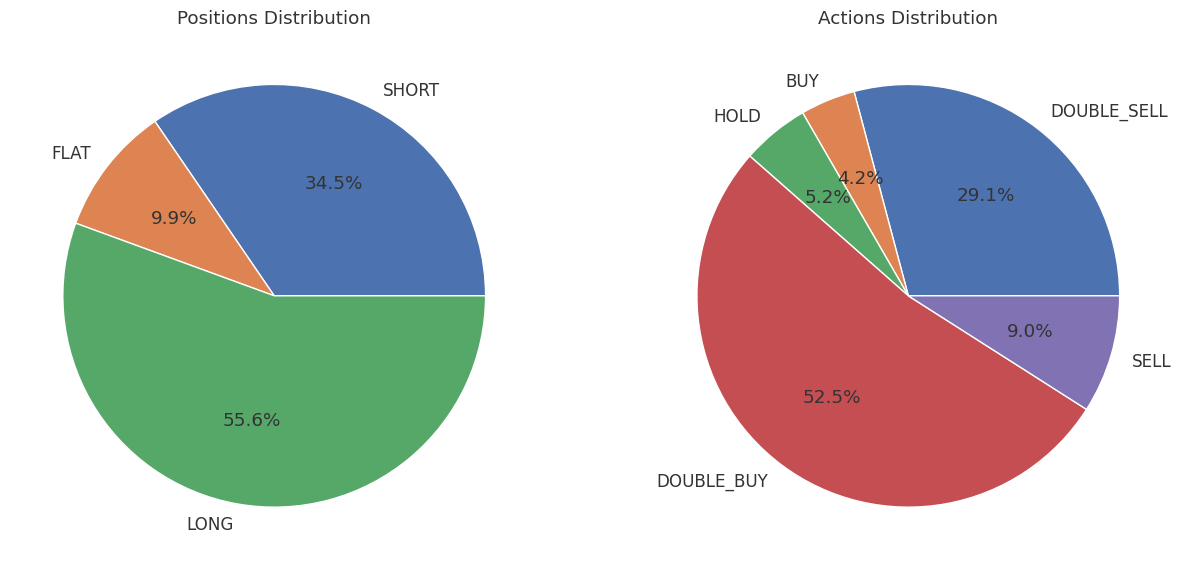

In [ ]:
env.render_distributions()

<a name="#sec:Comparison-2.1.3"></a>

### **2.1.3 Comparison DQN Architectures for timestep = 10000**

**Bias of agent because of insufficient training period**
 - Depending on the number of training timesteps, the changes in architecture not be significant as the agent would not learn the patterns properly, rather fitting to the unoptimal strategy in most cases. It sees limited data, it starts making conclusions without experience.

#### **Positions Distribution**
- **SHORT around 90% for most the architectures**: The agent is spending most of the time in the SHORT position. This could mean the agent has learned that holding a SHORT position is more often the profitable action given the dataset and market conditions simulated.
- **LONG** and **FLAT**: The agent seldom holds a LONG position or stays FLAT. The limited use of these positions suggests that the agent may not be finding many profitable opportunities to go LONG or to stay out of the market.

<br>

This issue with profitability is reached via Double Sell action - the agent starts to agressively sell the assets he does not own - borrows. That is why there is technically an obligation to buy them back later - creating exposure of risk. That is why this action may seem favourable for the trader only if they know about further fluctuations. In conclusion, at 10000 training time steps the learnt policies are generally not profitable - the policies considers the current state of the market providing the possibility to gain fast money by DOUBLE SELL action. Despite this, the actual profit would be measured after these liabilities would be closed. That is why training for more steps is important.


#### **Actions Distribution**
- **DOUBLE_SELL**: The agent overwhelmingly favors the DOUBLE_SELL action. This action corresponds to entering or maintaining a SHORT position. This could indicate a strong bias in the agent's strategy toward expecting a declining market.
- **SELL, DOUBLE_BUY, HOLD, BUY**: These actions are taken relatively infrequently, indicating that the agent has a strong preference for the DOUBLE_SELL action over others.


- the DOUBLE_SELL action always moves to SHORT regardless of the current position, and SELL action would go to SHORT if the position was FLAT, otherwise, it would go to FLAT. -- This is a modification to initial gym_anytrading environment, allowing for short-selling.

- When printing the render plot, it can be seen that most BUY actions are done in the beginning where there is a downward trend in prices, that is why the agent might then conclude that the trend would be repeated or even worsen and starts SHORT by DOUBLE SELL (Agent is not exploring enough).

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
Architecture [32, 64, 64, 32]


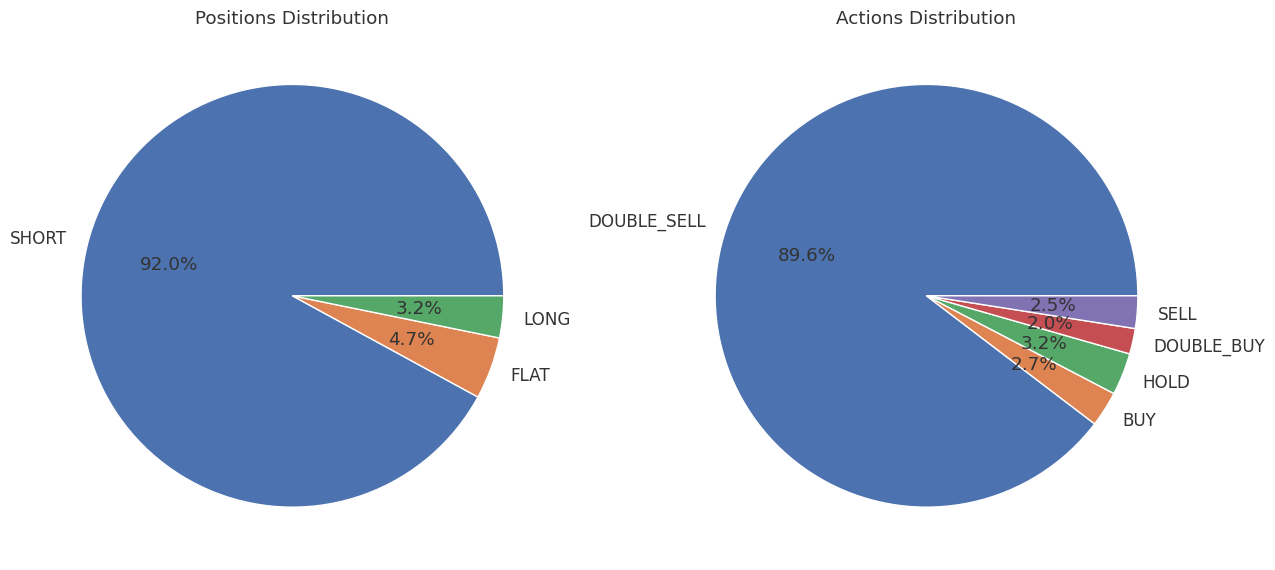

Using cpu device
Architecture [128, 256, 128]


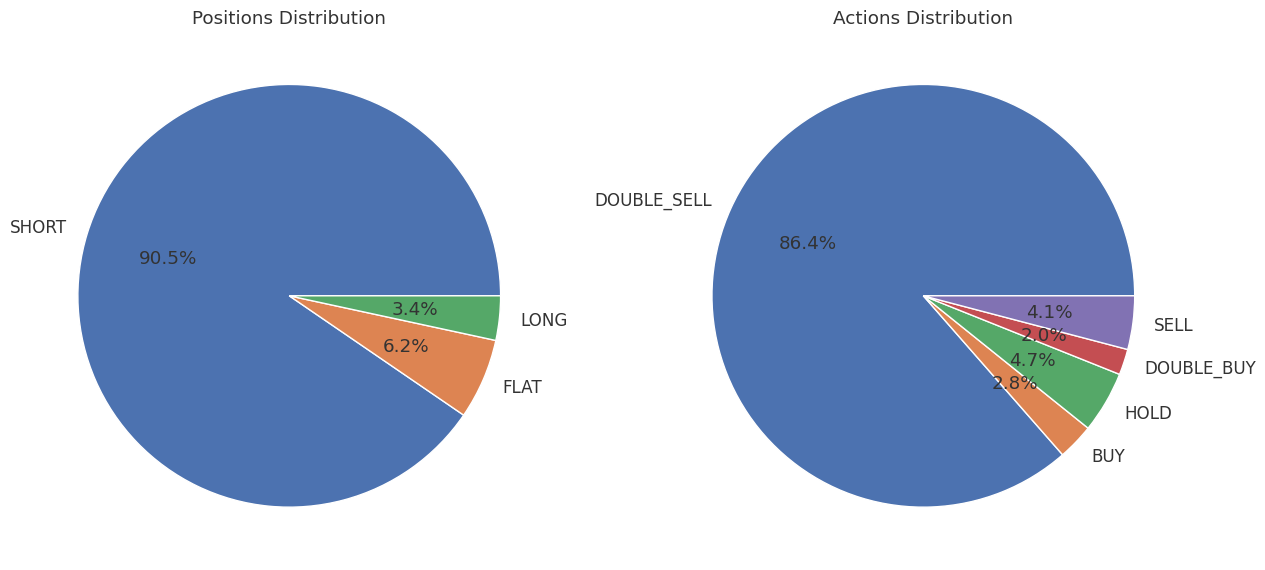

Using cpu device
Architecture [64, 128, 128, 256]


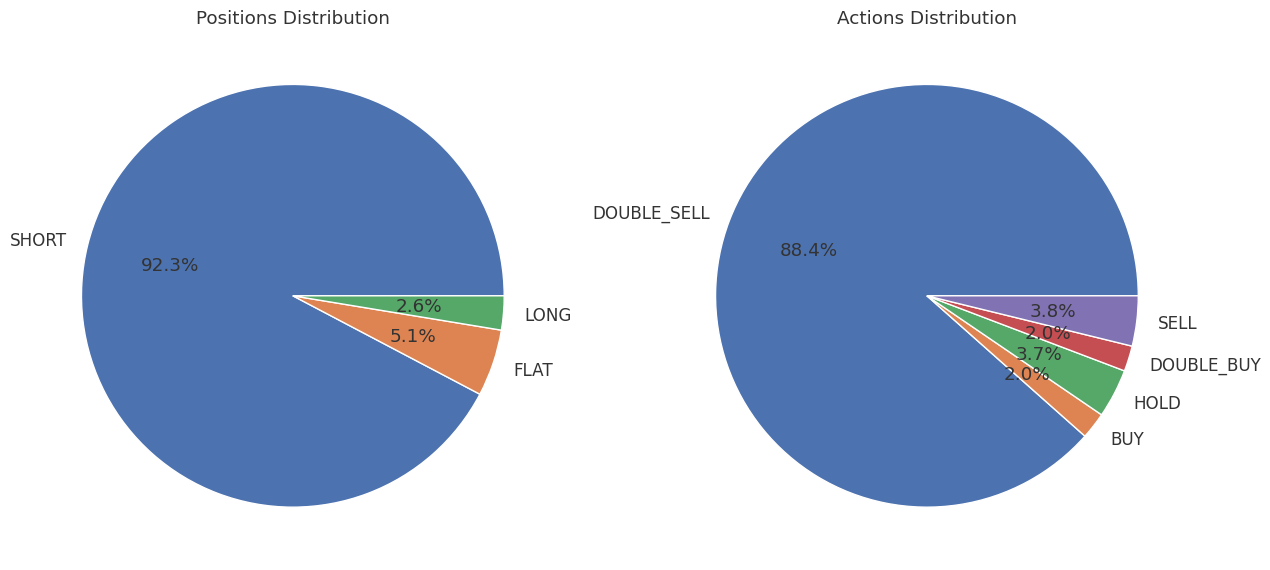

Using cpu device
Architecture [400, 300]


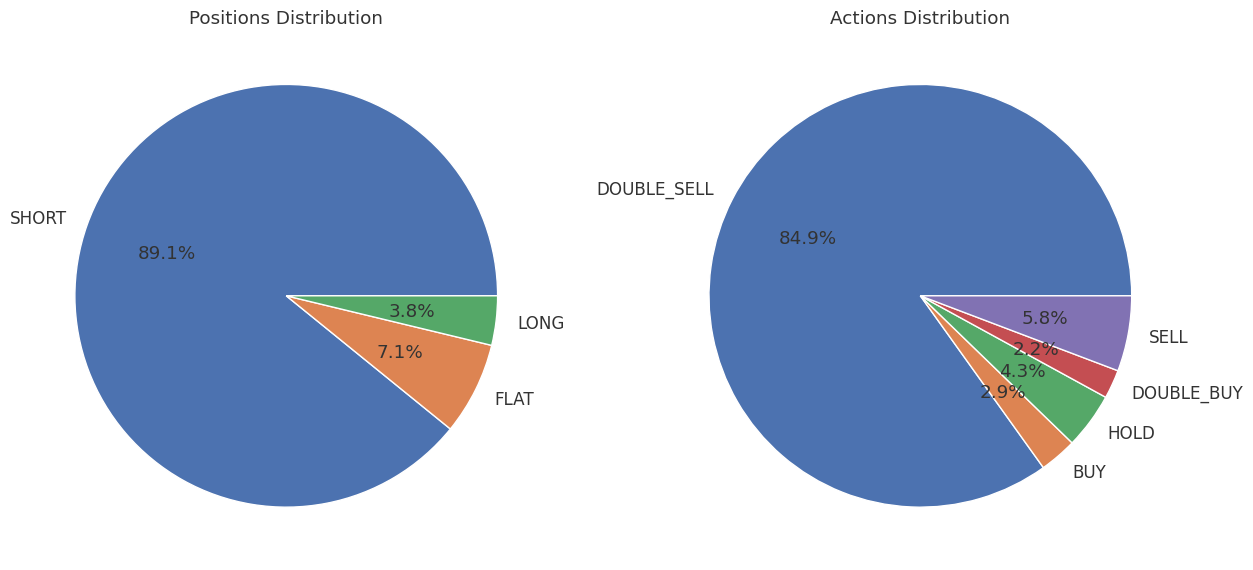

Using cpu device
Architecture [32, 32]


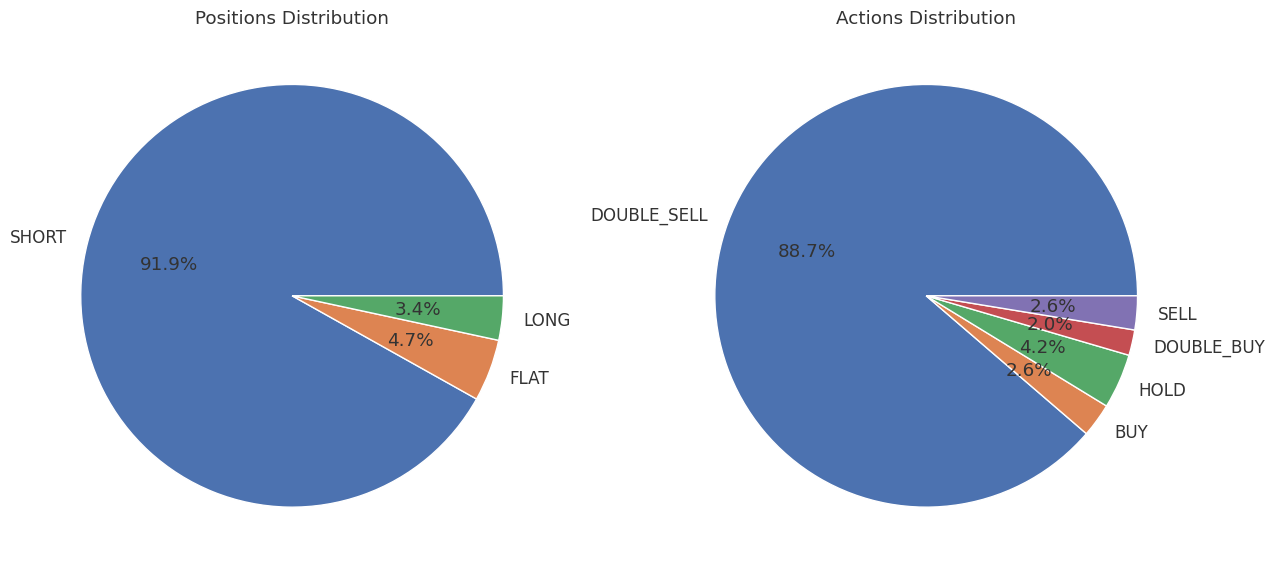

In [ ]:
save_dir = "/content/drive/My Drive/Colab Notebooks/saved_models_RL"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

def create_dqn_model(env, net_arch):
    return DQN("MlpPolicy", vec_env, policy_kwargs=dict(net_arch=net_arch), verbose=1, seed = seed)


architectures = [
    [32, 64, 64, 32],        # Four layers with increasing then decreasing units
    [128, 256, 128],         # A bottleneck architecture
    [64, 128, 128, 256],     # A deep network with increasing units
    [400, 300],              # DeepMind's DQN architecture
    [32, 32]
]


for i, arch in enumerate(architectures):
      env = CustomEnv(df=filtered_data_dqn, window_size=window_size, frame_bound=(start_index, end_index), seed = seed)

      env.reset()
      vec_env = DummyVecEnv([lambda: env])
      vec_env.seed(seed)
      model_dqn = create_dqn_model(vec_env, arch)
      model_dqn.learn(total_timesteps=10000)
      model_path = os.path.join(save_dir, f"dqn_model_arch_{i}")
      model_dqn.save(model_path)

      print(f"Architecture {arch}")
      env.render_distributions()


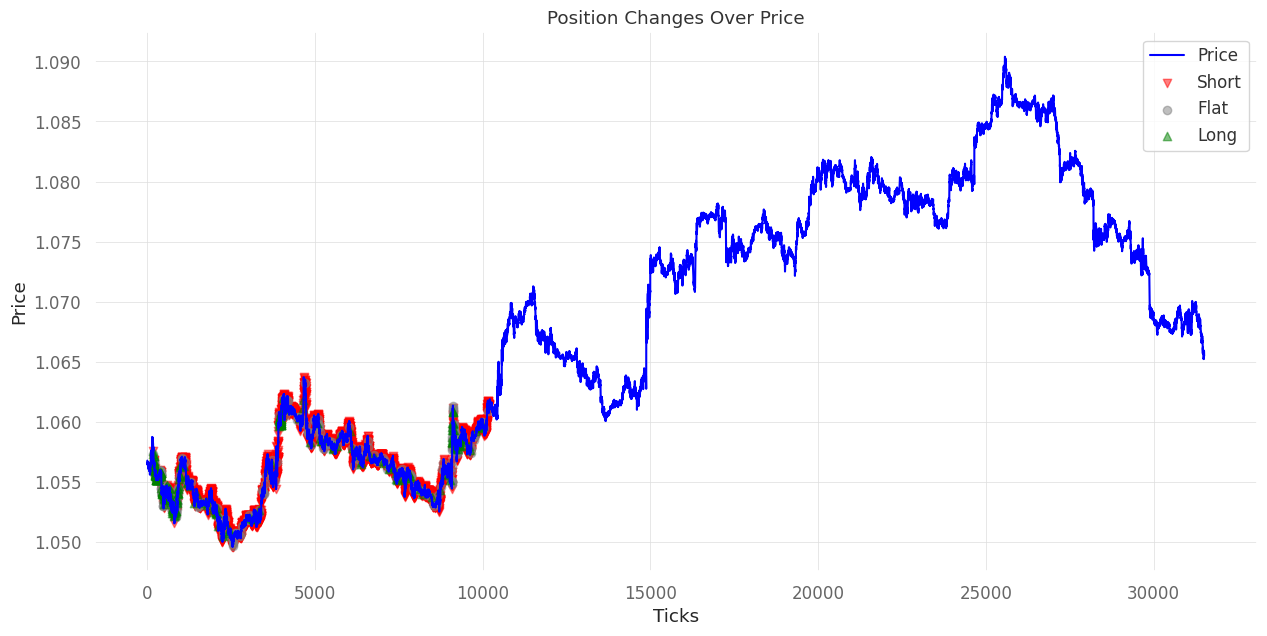

In [ ]:
env.render_positions()

<a name="sec:Comparison-DQN-Architectures-for-full-timesteps-2.1.4"></a>
### **2.1.4. Comparison DQN Architectures for full timesteps**

The choice of DQN architecture can be somewhat analogous to different investment styles in financial markets.

- **Smaller architectures ([32, 32])** resemble a more conservative or diversified investment strategy. They avoid large bets on specific market movements, which could be akin to a balanced mutual fund that spreads risk across various assets.

- **Moderate architectures ([32, 64, 64, 32])** comparable to more active investment approach, trying to capitalize on market inefficiencies but without extreme positions: **growth-oriented investment fund** that looks for value but stays diversified.

- **Larger, more complex architectures ([128, 256, 128], [64, 128, 128, 256], [400, 300])** reflect a more aggressive or specialized investment style to maximize returns based on specific market predictions. These networks have the capacity to capture intricate patterns in the data, potentially leading to **higher risk-reward trades**.


Using cpu device
Architecture [32, 64, 64, 32]


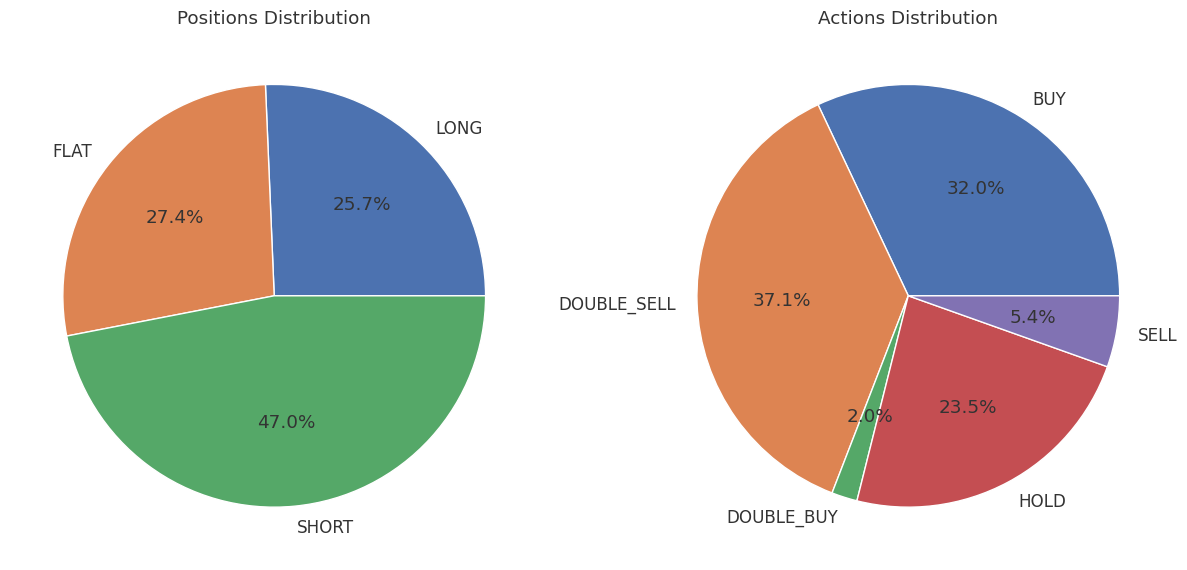

Using cpu device
Architecture [128, 256, 128]


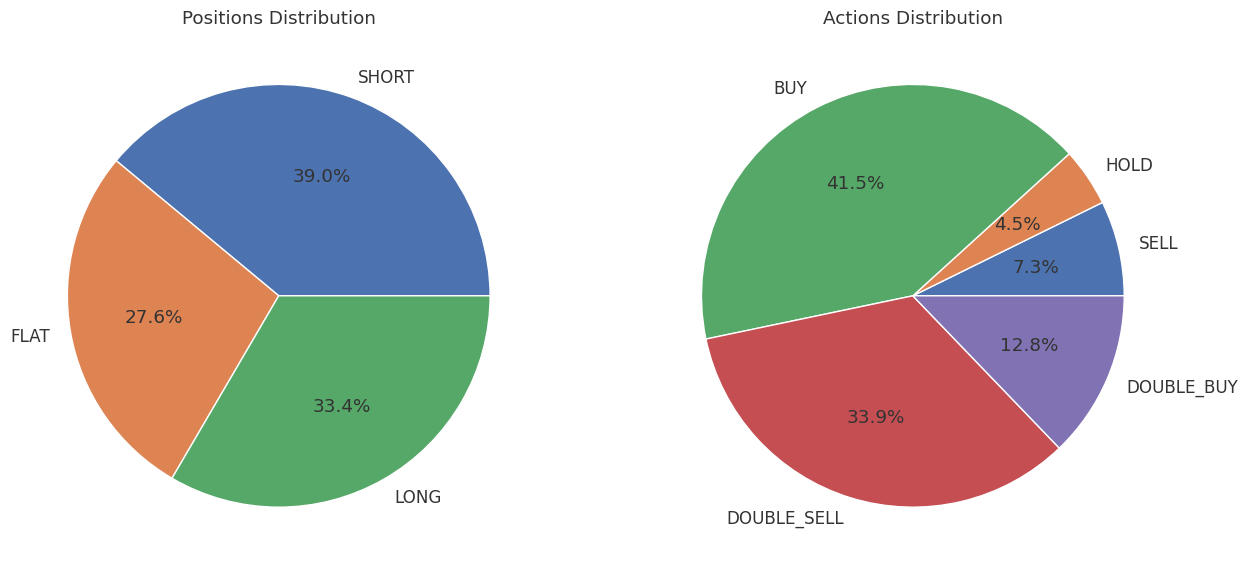

Using cpu device
Architecture [64, 128, 128, 256]


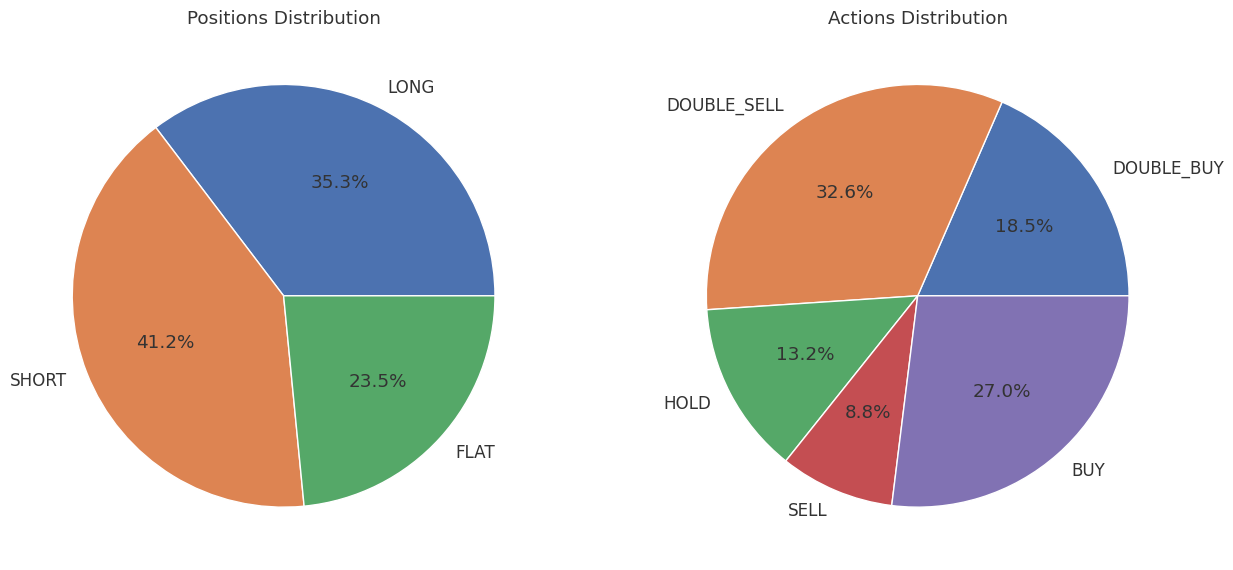

Using cpu device
Architecture [400, 300]


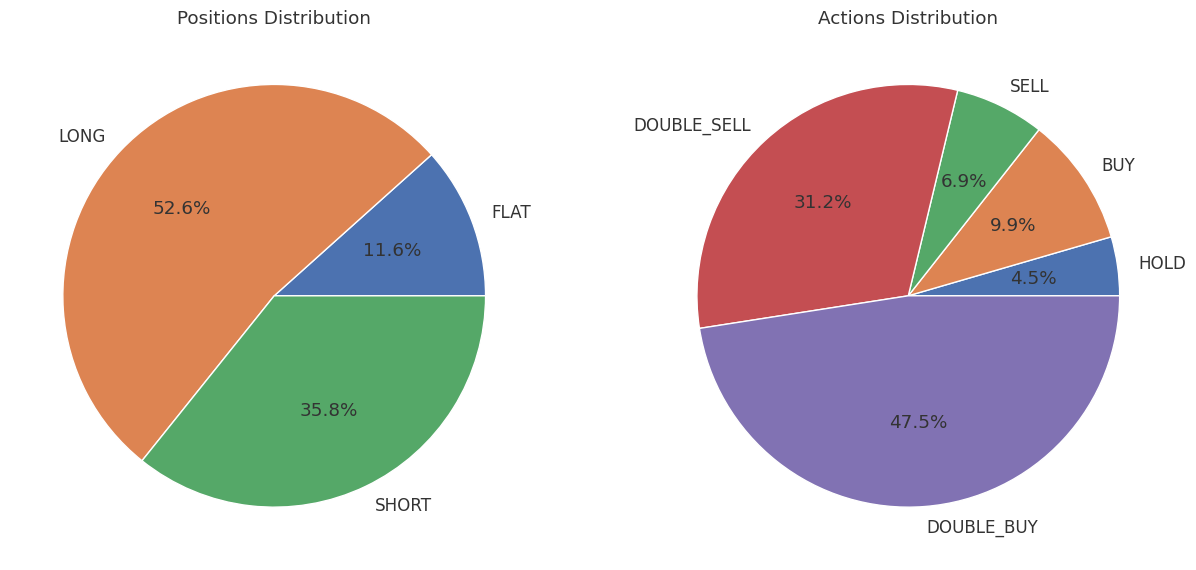

Using cpu device
Architecture [32, 32]


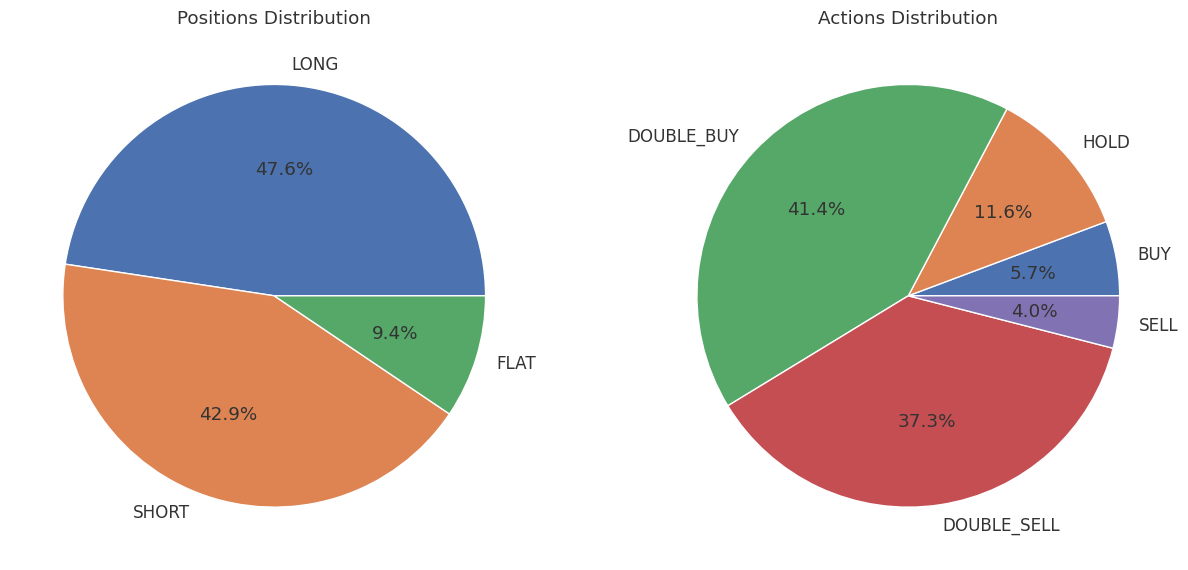

In [ ]:
save_dir = "/content/drive/My Drive/Colab Notebooks/saved_models_RL2"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

def create_dqn_model(env, net_arch):
    return DQN("MlpPolicy", vec_env, policy_kwargs=dict(net_arch=net_arch), verbose=1)


architectures = [
    [32, 64, 64, 32],        # Four layers with increasing then decreasing units
    [128, 256, 128],         # A bottleneck architecture
    [64, 128, 128, 256],     # A deep network with increasing units
    [400, 300],              # DeepMind's DQN architecture
    [32, 32]
]


for i, arch in enumerate(architectures):
    env = CustomEnv(df=filtered_data_dqn, window_size=window_size, frame_bound=(start_index, end_index), seed = seed)

    env.reset()
    vec_env = DummyVecEnv([lambda: env])
    vec_env.seed(seed)
    model = create_dqn_model(vec_env, arch)
    model.learn(total_timesteps=len(filtered_data_dqn)-2*window_size)
    model_path = os.path.join(save_dir, f"dqn_model_arch_{i}")
    model_dqn.save(model_path)


    print(f"Architecture {arch}")
    env.render_distributions()


<a name="sec:DQN-Results-2.1.5"></a>
## **DQN Results**

1. **[32, 64, 64, 32]**: Agent predominantly takes SHORT positions but also explores LONG and FLAT to some extent. The action distribution shows a balance between BUY and DOUBLE_SELL, indicating a policy that is neither overly conservative nor excessively risk-taking.

2. **[128, 256, 128]**:  LONG position is significantly dominant, and the action distribution leans heavily towards BUY, suggesting the agent learned a strong bias towards bullish market conditions or that the data has a pattern that frequently rewards the LONG position.

3. **[64, 128, 128, 256]**: This architecture presents a more balanced position distribution. The action distribution is still BUY-focused but includes a non-negligible proportion of DOUBLE_SELL, showing some level of caution or risk management.

4. **[400, 300]**: The agent with this architecture holds LONG positions most of the time, indicating a strong bullish bias in its policy. The actions are dominated by BUY and DOUBLE_SELL, suggesting a possible alternating strategy between holding assets and taking advantage of expected price declines.

5. **[32, 32]**: The positions and actions are more evenly distributed here compared to other architectures. The DOUBLE_SELL action is prominent, but there's a significant HOLD portion, indicating a strategy that may be more responsive to market changes rather than committing to one trend.



<a name="sec:2.2"></a>
## **2.2 PPO and A2C applied to Forex Trading (EUR_USD) with gym_anytrading environment**

Goal: ***The model will be trained on data from one month, selected for its characteristic trading behavior, and then tested on another month known for significantly different trading activity. The primary objective is to assess the robustness and reliability of the model under varying market conditions, with the aim of ensuring that the model remains effective and minimizes potential losses even when market dynamics change.***

In forex trading, the behavior of currency pairs can vary widely throughout the year due to various economic, political, and seasonal factors.

1. **January and August**:
   - **January**: The beginning of the year can see increased volatility and significant movements as traders and institutions adjust their portfolios for the new fiscal year.
   - **August**: This month often experiences lower liquidity and higher volatility due to the summer holidays in many Western countries (reduced activity).

2. **March and December**:
   - **March**: Often a period of heightened activity and volatility, partly due to the close of the fiscal year for many companies (for some its January, for others March - that is why both these months are present here) and adjustments in portfolios. Economic forecasts and central bank policy shifts announced in early spring can also influence trading.
   - **December**: Early in the month, there might be robust activity as traders adjust positions and close books for the year. However, liquidity often drops significantly closer to the end of the month due to the holiday season, leading to potential spikes in volatility. ([Tsai et al., 2020](https://link.springer.com/chapter/10.1007/978-3-030-55789-8_34))

That is why when using an RL algorithm for identifying a better strategy for trading or hedging, it is important to validate if the model captures unexpected trends and patterns ([Briola et al., 2021](https://arxiv.org/abs/2101.07107) ).

This can be done through application of the model to the market data of the same trading pair from another month. In this study we focus on comparison of March and December.

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/pyfinance.csv')
dataset['date'] = pd.to_datetime(dataset['date'])

desired_month = 3  # For March
desired_year = 2017  # For 2017, change as needed
df = dataset[(dataset['date'].dt.month == desired_month) & (dataset['date'].dt.year == desired_year)]

df.set_index('date', inplace=True)

In [ ]:
desired_month = 12
desired_year = 2017  # For 2017

df2 = dataset[(dataset['date'].dt.month == desired_month) & (dataset['date'].dt.year == desired_year)]
df2.set_index('date', inplace=True)

<a name="sec:A2C-2.2.1"></a>
### **2.2.1 A2C**

This model divides the problem into two main components: the actor, which decides which action to take, and the critic, which evaluates the action taken by the actor by computing the value function. When applied to high-frequency trading (HFT) in the forex market, the Actor-Critic model offers several notable advantages ([Liu et al., 2022](https://dl.acm.org/doi/abs/10.1145/3490354.3494366?casa_token=kWNuyjeuH9QAAAAA:IjrNk8HMFTcSo2-h1b8EaWlb7abCcLQdACLC9XL-4XrwOfFmy2HI0lbnBdIa5Pi0he3Qa4Obfmbq)).

<br>

 In the context of forex trading, the actor component of the model is responsible for deciding on trading actions. The critic assesses the actions taken by the actor by estimating the value function of the current policy.

In [ ]:
window_size = 180


start_date = "2017-03-01"
end_date = "2017-03-31"

filtered_data_a2c = df[start_date:end_date]

start_index = window_size
end_index = len(filtered_data_a2c)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


###  **Environment**

In [ ]:
def my_process_data(env):
    prices = env.df.loc[:, 'Close'].to_numpy()
    prices = prices[env.frame_bound[0]-env.window_size:env.frame_bound[1]]
    diff = np.insert(np.diff(prices), 0, 0)#
    try:
      sma = env.df.loc[:, 'SMA'].to_numpy()
      macd = env.df.loc[:, 'MACD_SIG'].to_numpy()
      rsi = env.df.loc[:, 'RSI'].to_numpy()

      sma = sma[env.frame_bound[0]-env.window_size:env.frame_bound[1]]
      macd = macd[env.frame_bound[0]-env.window_size:env.frame_bound[1]]
      rsi = rsi[env.frame_bound[0]-env.window_size:env.frame_bound[1]]

      signal_features = np.column_stack((prices, diff, sma, macd, rsi))

    except:
      print("(SMA, MACD, RSI) wern't all present. Reverting to default signal features (price and price-diff)")
      signal_features = np.column_stack((prices, diff))

    return prices.astype(np.float32), signal_features.astype(np.float32)


class CustomForex(ForexEnv):
    _process_data = my_process_data

In [ ]:
my_custom_env = CustomForex(df=filtered_data_a2c, window_size=window_size, frame_bound=(start_index, end_index))


(SMA, MACD, RSI) wern't all present. Reverting to default signal features (price and price-diff)


### **Model Training**

The warning here is just related to the cutted output lines because colab allowed to print just 5000 lines while training was done for more (ingore the warning as printing was for observing purposes)

In [ ]:

model_a2c = A2C("MlpPolicy", my_custom_env, verbose=1, seed = 2023)
model_a2c.learn(total_timesteps=500000)


Выходные данные были обрезаны до нескольких последних строк (5000).
|    value_loss         | 3.33e-18  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 3.13e+04  |
|    ep_rew_mean        | 147       |
| time/                 |           |
|    fps                | 437       |
|    iterations         | 70700     |
|    time_elapsed       | 807       |
|    total_timesteps    | 353500    |
| train/                |           |
|    entropy_loss       | -0.000722 |
|    explained_variance | -0.185    |
|    learning_rate      | 0.0007    |
|    n_updates          | 70699     |
|    policy_loss        | 2.91e-12  |
|    value_loss         | 3.4e-15   |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 3.13e+04  |
|    ep_rew_mean        | 147       |
| time/                 |           |
|    fps            

In [ ]:
action_stats = {Actions.Sell: 0, Actions.Buy: 0}

observation, info = my_custom_env.reset()

while True:
    action, _states = model_a2c.predict(observation)
    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = my_custom_env.step(action)
    done = terminated or truncated

    if done:
        break

my_custom_env.close()

print("action_stats:", action_stats)
print("info:", info)


action_stats: {<Actions.Sell: 0>: 26, <Actions.Buy: 1>: 31300}
info: {'total_reward': 135.59937477111816, 'total_profit': 0.9932310359073705, 'position': <Positions.Long: 1>}


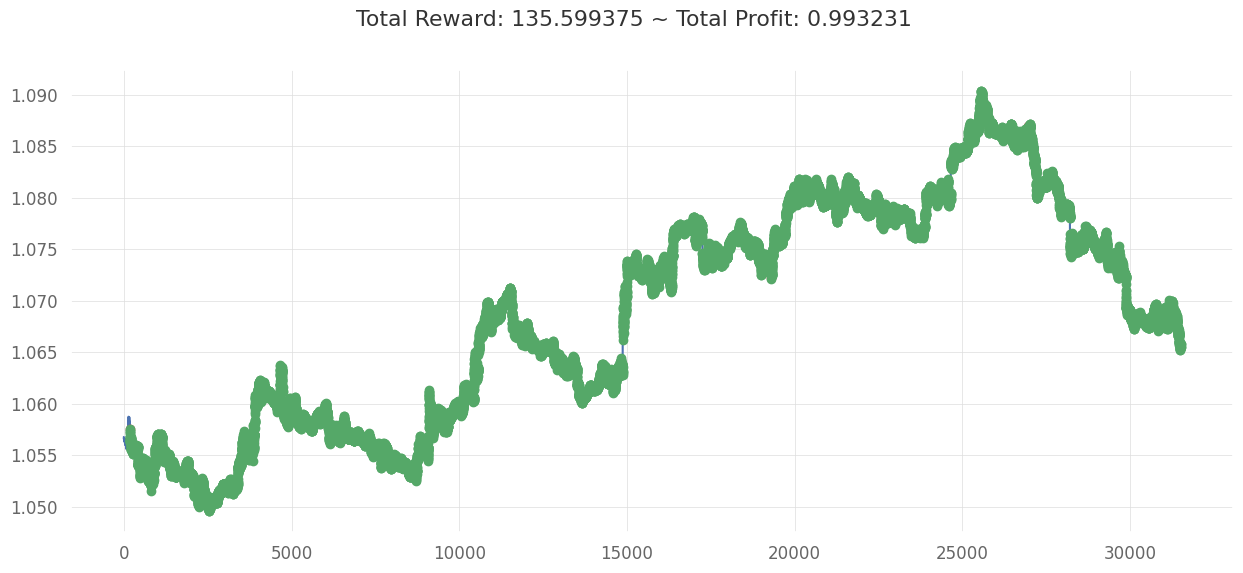

In [ ]:
plt.figure(figsize=(15,6))
plt.cla()
my_custom_env.render_all()
plt.show()

### **Profit and Reward**

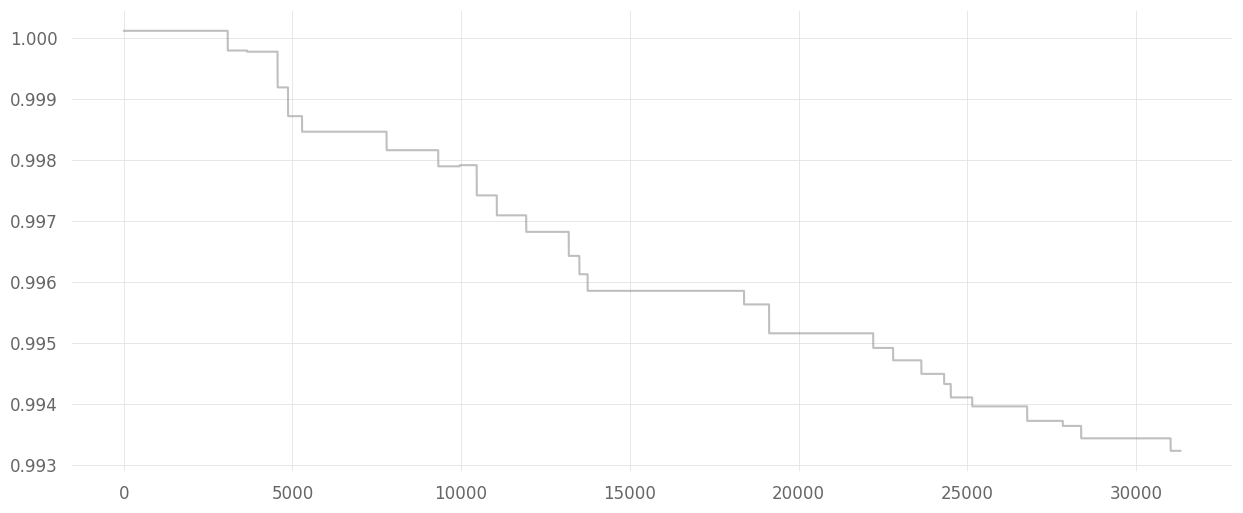

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(my_custom_env.history['total_profit'], label='Price', color='gray', alpha=0.5)


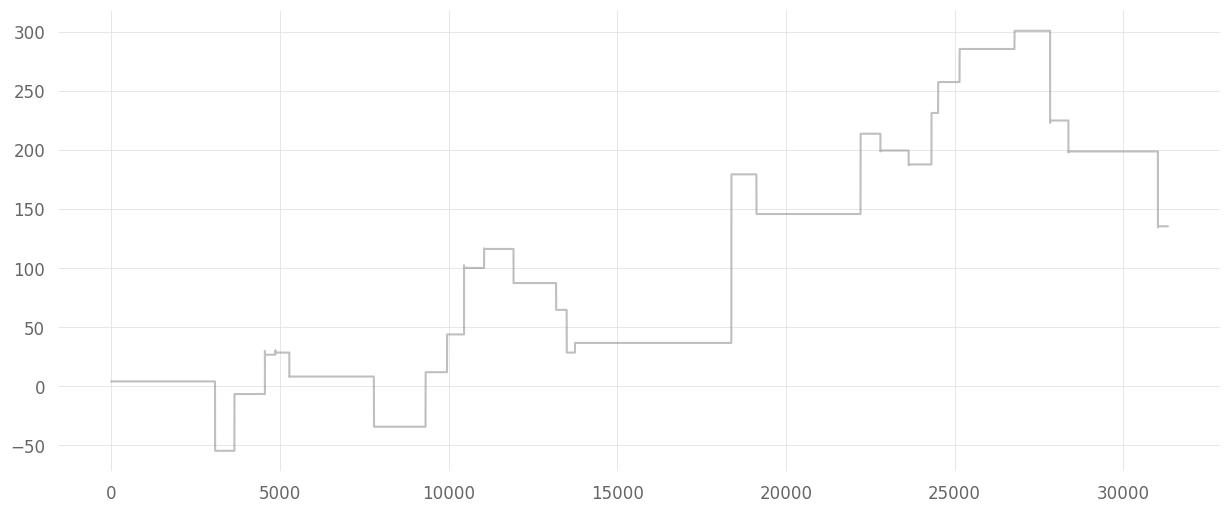

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(my_custom_env.history['total_reward'], label='Price', color='gray', alpha=0.5)


###  **Test data**

In [ ]:
window_size = 180  # looking back 180 minutes (3 hour)

start_date = "2017-12-01"
end_date = "2017-12-31"

filtered_data_a2c_test = df2[start_date:end_date]

start_index = window_size
end_index = len(filtered_data_a2c_test)

In [ ]:
test_env = CustomForex(df=filtered_data_a2c_test, window_size=window_size, frame_bound=(start_index, end_index))

(SMA, MACD, RSI) wern't all present. Reverting to default signal features (price and price-diff)


In [ ]:
action_stats_a2c_test = {Actions.Sell: 0, Actions.Buy: 0}

observation, info = test_env.reset(seed=seed)

while True:
    action, _states = model_a2c.predict(observation)

    action_stats_a2c_test[Actions(action)] += 1
    observation, reward, terminated, truncated, info = test_env.step(action)

    done = terminated or truncated

    if done:
        break

test_env.close()

print("action_stats:", action_stats_a2c_test)
print("info:", info)

action_stats: {<Actions.Sell: 0>: 21, <Actions.Buy: 1>: 26888}
info: {'total_reward': 91.00079536437988, 'total_profit': 0.9950589185376948, 'position': <Positions.Long: 1>}


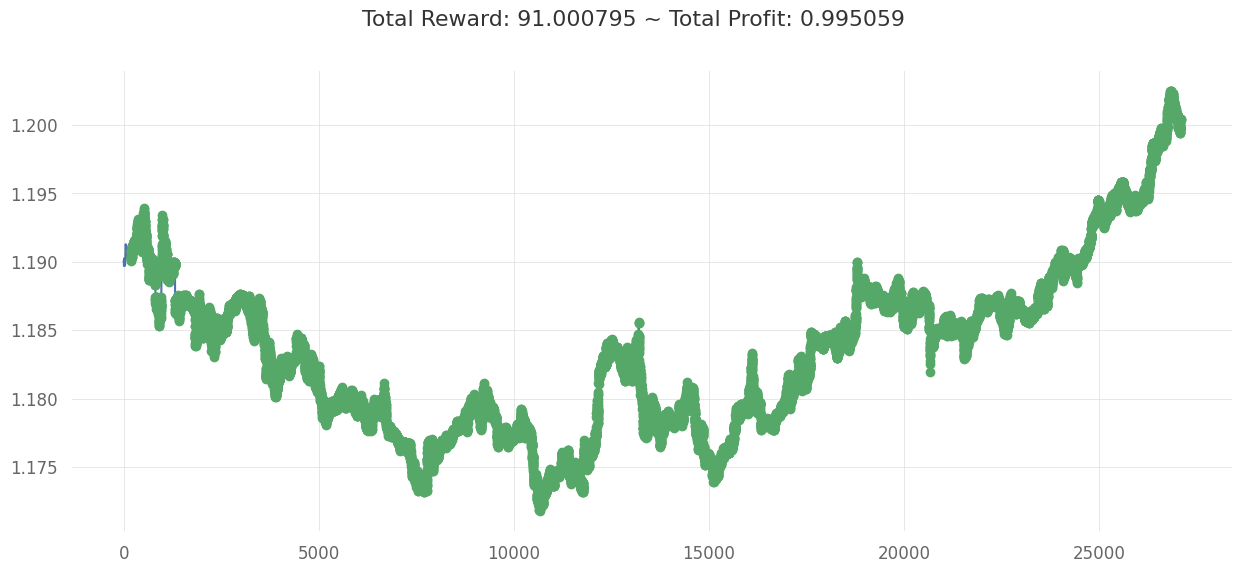

In [ ]:
plt.figure(figsize=(15,6))
plt.cla()
test_env.render_all()
plt.show()

###  **Profit and reward test**

PROFIT


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


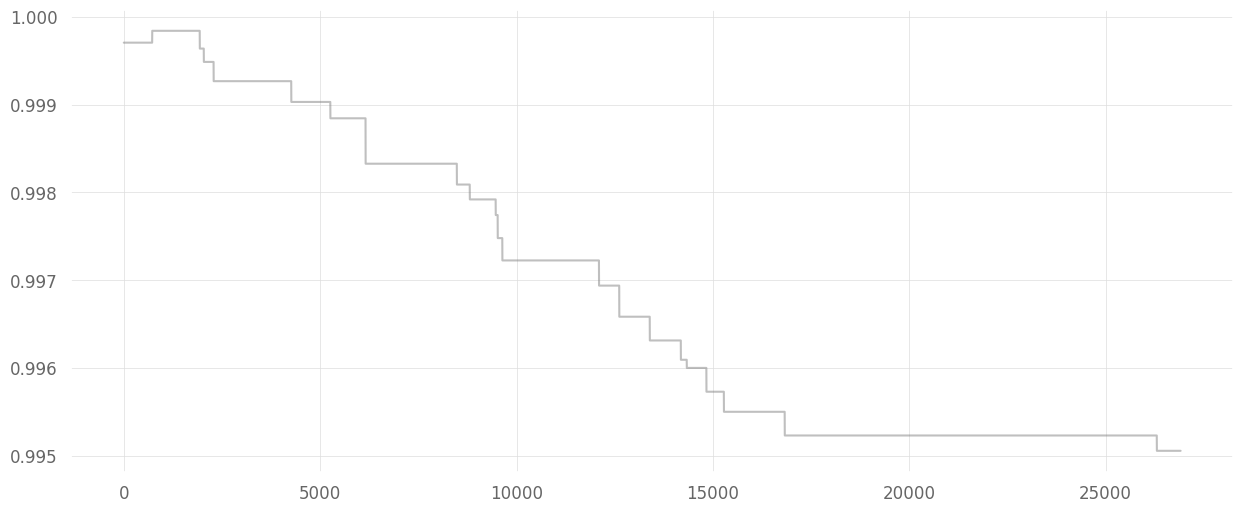

In [ ]:
print('PROFIT')
plt.figure(figsize=(15, 6))
plt.plot(test_env.history['total_profit'], label='Price', color='gray', alpha=0.5)


REWARD


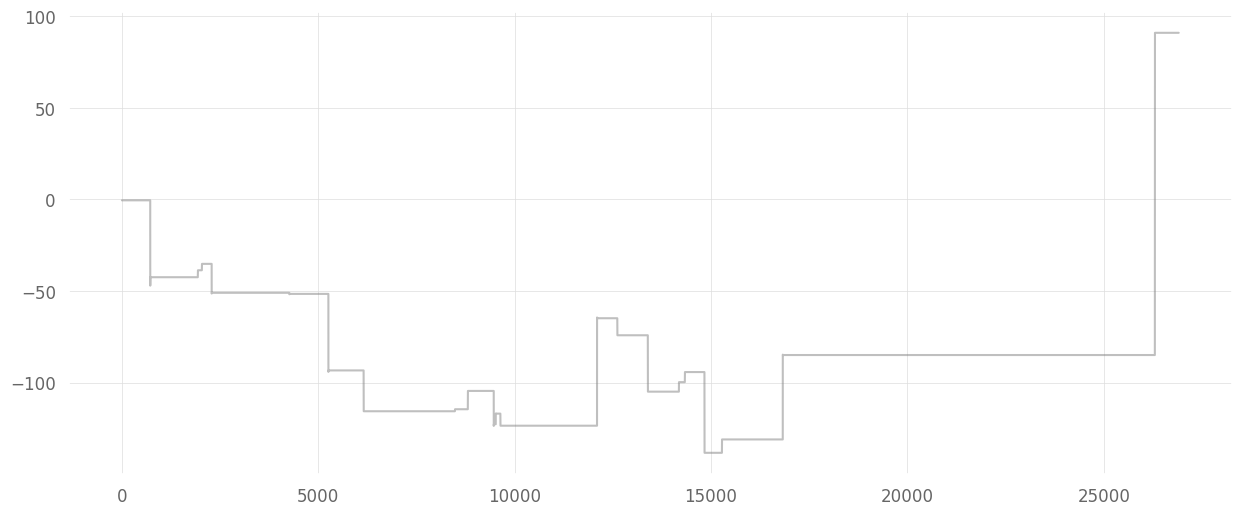

In [ ]:
print('REWARD')
plt.figure(figsize=(15, 6))
plt.plot(test_env.history['total_reward'], label='Price', color='gray', alpha=0.5)



## **A2C Results**

When fitting the A2c model to the EUR_USD March data, it has negative reward not frequently, while updating it with rather low increments. FInally, it reaches 135.6, showing the ability to learn.  

<br>

The trading agent does not do many selling operations (26), preferring to buy and hold (31300). It makes A2C strategy similar to the one obtained by PPO. When using lower number of timesteps for training A2C, the total_profit falls drastically. Total_profit = 1 in the beginning, while the final profit shows, how much the trader gained or how much this value decreased. As for the training set, the total_profit in the end equals 0.993. This means that the agent did not gain money, but lost just 0.007 that is lower than 1%. If we train the model for less steps, the final total_profit becomes 0.74, showing the fall of 0.26, much bigger than 1%. That is why, there comes the conclusion that training A2C should be done for longer than PPO to provide more stability for a model.

<br>

When adressing the test set, which shows new market behaviour in December, the total reward decreases to 91, getting positive only in the very end. It falls lower than for training set. If comparing to PPO, stabilization over rewards happens faster for PPO than for A2C, which is why it is proposed to use more steps when possible for A2C to fit/train. Even though the market data follows a different pattern in December, the A2C model still suggests rather cautious strategy with only 21 sell action (means being either out of position or just sold an asset), most of the time either buying or holding - waiting for a proper moment. This makes sense, because December shows a new configuration of prices movement, by this making model more attentive to its actions.

<br>

The profit for test set is managed rather professionally with small proportion of money lost (0.005), even though initially the model was fitted to the month with another market behaviour.



<a name="sec:PPO-2.2.2"></a>
### **2.2.2 PPO**

Indeed, the differences in penalties between short and long positions serve a crucial purpose in incentivizing trading activity and preventing risk-averse behavior from the agent. Here's a more detailed explanation:

1. **Encouraging Trading Activity:**
   - It is importnat for traders to actively engage in trading activities to capitalize on profitable opportunities
   - The penalties for negative profits, especially when a trade results in a loss, play a vital role in discouraging risk-averse behavior where the agent refrains from taking actions or maintains a neutral position to avoid potential losses

2. **Preventing Risk-Free Behavior:**
   - Without appropriate penalties, the agent may learn to adopt risk-free behaviors and avoid trades at all
   - For instance, if the profit is updated only when the position changes, the agent might learn that constantly maintaining a position without executing trades (e.g., always selling without changing the position) leads to a constant profit in gym_anytrading

3. **Differentiating Penalties for Short and Long Positions:**
   - The differentiation in penalties between short and long positions reflects the varying risk profiles associated with each type of trade
   - The penalty for being out of market at all and for holding assets without liquidity in trades are different in nature, on the whole
   - Gym_anytrading does not allow for short selling that is why there is no separate penalty for being in a position with liability

In conclusion, the differences in penalties for short and long positions aim to discourage risk-averse behavior, promote trading activity, and foster balanced risk management practices

In [ ]:
window_size = 180
start_date = "2017-03-01"
end_date = "2017-03-31"

filtered_data = df[start_date:end_date]

start_index = window_size
end_index = len(filtered_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### **Modified gym_anytrading environment**

In [ ]:
def my_process_data(env):
    prices = env.df.loc[:, 'Close'].to_numpy()  # use close price as current share price
    prices = prices[env.frame_bound[0]-env.window_size:env.frame_bound[1]]
    diff = np.insert(np.diff(prices), 0, 0)#

    # additional indicators
    try:
      sma = env.df.loc[:, 'SMA'].to_numpy()
      macd = env.df.loc[:, 'MACD_SIG'].to_numpy()
      rsi = env.df.loc[:, 'RSI'].to_numpy()

      sma = sma[env.frame_bound[0]-env.window_size:env.frame_bound[1]]
      macd = macd[env.frame_bound[0]-env.window_size:env.frame_bound[1]]
      rsi = rsi[env.frame_bound[0]-env.window_size:env.frame_bound[1]]

      signal_features = np.column_stack((prices, diff, sma, macd, rsi))

    except:
      print("(SMA, MACD, RSI) wern't all present. Reverting to default signal features (price and price-diff)")
      signal_features = np.column_stack((prices, diff))

    return prices.astype(np.float32), signal_features.astype(np.float32)


class MyStocksEnv(ForexEnv):
    _process_data = my_process_data

    def __init__(self, df, window_size, frame_bound):
        super().__init__(df, window_size, frame_bound)
        self.trade_log = []

    def step(self, action):
        self._truncated = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._truncated = True

        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward

        self._update_profit(action)

        trade = False
        if (
            (action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)
        ):
            trade = True

        if trade:
            # Log the trade details
            trade_info = {
                'step': self._current_tick,
                'action': action,
                'price': self.prices[self._current_tick],
                'from position':self._position
                #'profit': profit,
            }
            self.trade_log.append(trade_info)


            self._position = self._position.opposite()
            self._last_trade_tick = self._current_tick
            #self.action_stats[Actions(action)] += 1

        self._position_history.append(self._position)
        observation = self._get_observation()
        info = self._get_info()
        self._update_history(info)

        if self.render_mode == 'human':
            self._render_frame()

        return observation, step_reward, False, self._truncated, info


    def _calculate_reward(self, action):
      step_reward = 0  # pip

      trade = False
      if (
          (action == Actions.Buy.value and self._position == Positions.Short) or
          (action == Actions.Sell.value and self._position == Positions.Long)
      ):
          trade = True


      if trade:
          current_price = self.prices[self._current_tick]
          last_trade_price = self.prices[self._last_trade_tick]
          price_diff = current_price - last_trade_price

          # Calculate profit in pips
          profit = price_diff * 10000

          if self._position == Positions.Short:
              # Deduct transaction costs for short positions
              transaction_cost = abs(profit) * self.trade_fee
              step_reward += profit - transaction_cost

              # Penalize negative profits further
              if profit < 0:
                  penalty_for_loss = 10  # To identify
                  step_reward -= penalty_for_loss
              if profit >0:
                  win_premium = 7
                  step_reward += win_premium

          elif self._position == Positions.Long:
              # Deduct transaction costs for long positions
              transaction_cost = abs(profit) * self.trade_fee
              step_reward += profit - transaction_cost

              # Penalize negative profits further
              if profit < 0:
                  penalty_for_loss = 7  # To identify
                  step_reward -= penalty_for_loss
              if profit >0:
                  win_premium = 7
                  step_reward += win_premium

      return step_reward


###  Model Training

In [ ]:
my_forex_env = MyStocksEnv(df=filtered_data, window_size=window_size, frame_bound=(start_index, end_index))


model = PPO("MlpPolicy", my_forex_env, verbose=1, learning_rate = 0.0001, seed= seed)
model.learn(total_timesteps=500000)
model.save("ppo_forex")

# the comment in yellow says that the output data was cut to 5000 lines


Выходные данные были обрезаны до нескольких последних строк (5000).
|    entropy_loss         | -0.691      |
|    explained_variance   | 3.58e-07    |
|    learning_rate        | 0.0001      |
|    loss                 | 123         |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.00523    |
|    value_loss           | 280         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 411          |
|    iterations           | 7            |
|    time_elapsed         | 34           |
|    total_timesteps      | 14336        |
| train/                  |              |
|    approx_kl            | 0.0049569034 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.692       |
|    explained_variance   | 7.15e-07     |
|    learning_rate        | 0.0001       |
|    loss                 | 155      

In [ ]:
# Initialize counters
buy_trades = 0
sell_trades = 0

previous_action = None
for trade in my_forex_env.trade_log:
    current_action = trade['action']
    if current_action != previous_action:
        if current_action == Actions.Buy.value:
            buy_trades += 1
        elif current_action == Actions.Sell.value:
            sell_trades += 1
    previous_action = current_action

print(f"Buy trades executed: {buy_trades}")
print(f"Sell trades executed: {sell_trades}")

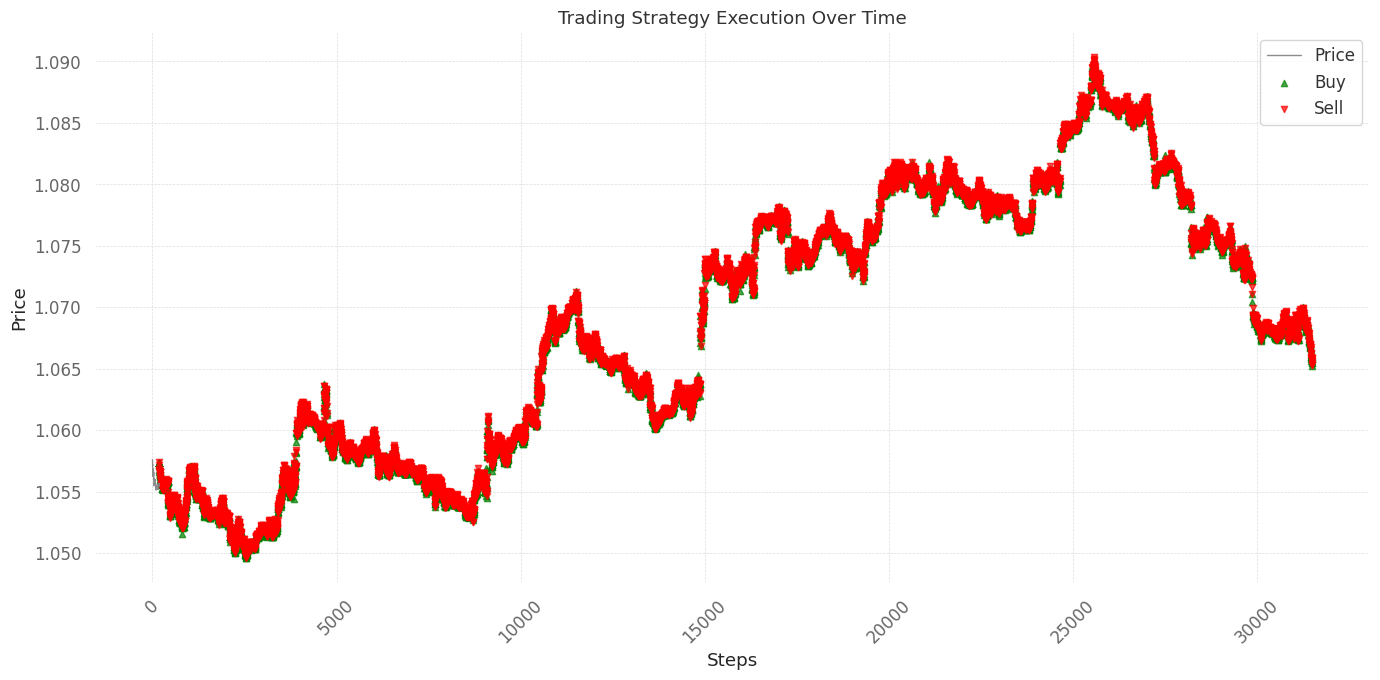

In [ ]:
import matplotlib.pyplot as plt
buy_steps = [log['step'] for log in my_forex_env.trade_log if log['action'] == Actions.Buy.value]
sell_steps = [log['step'] for log in my_forex_env.trade_log if log['action'] == Actions.Sell.value]
prices = my_forex_env.prices


plt.figure(figsize=(14, 7))
plt.plot(prices[180:360], label='Price', color='gray', linewidth=1, alpha=0.9)

plt.scatter(buy_steps, [prices[step] for step in buy_steps], color='green', label='Buy', marker='^', s=20, alpha=0.7)
plt.scatter(sell_steps, [prices[step] for step in sell_steps], color='red', label='Sell', marker='v', s=20, alpha=0.7)

plt.title('Trading Strategy Execution Over Time')
plt.xlabel('Steps')
plt.ylabel('Price')
plt.legend(loc='best')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [ ]:
action_stats = {Actions.Sell: 0, Actions.Buy: 0}

#model = PPO.load("ppo_forex")
total_rewards = []
actions_taken = []
obs, info = my_forex_env.reset()
key_step  = 0
while True:
    action, _states = model.predict(obs)

    action_stats[Actions(action)] += 1
    action_value = action.item() if isinstance(action, np.ndarray) and action.ndim == 0 else action
    actions_taken.append((key_step, action_value))  # Store the step and action value

    obs, rewards, terminated, truncated, info = my_forex_env.step(action)
    dones = terminated or truncated
    total_rewards.append(info['total_reward'])

    key_step +=1
    if dones:
        break  # Stop the loop if done
print("action_stats:", action_stats)
print("info:", info)

action_stats: {<Actions.Sell: 0>: 10, <Actions.Buy: 1>: 31316}
info: {'total_reward': 219.88590216636658, 'total_profit': 0.9955382712446159, 'position': <Positions.Long: 1>}


###  Profit and reward

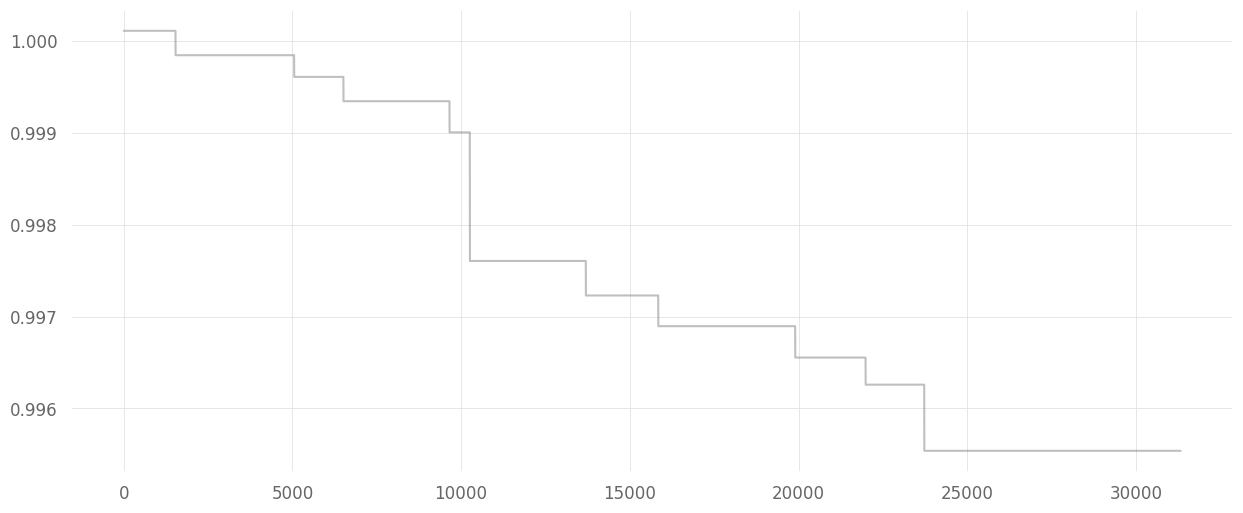

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(my_forex_env.history['total_profit'], label='Price', color='gray', alpha=0.5)

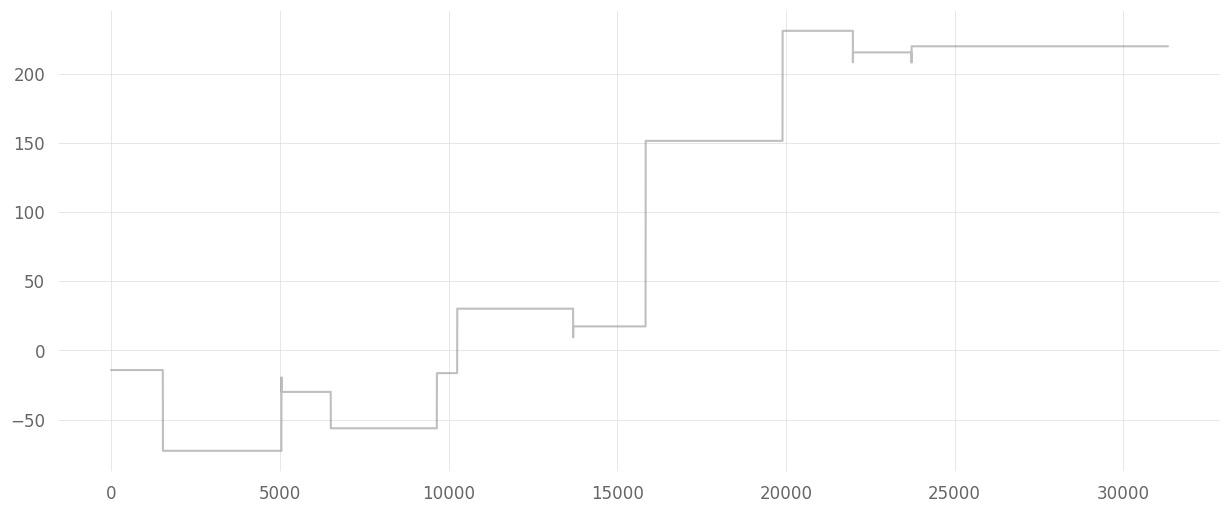

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(my_forex_env.history['total_reward'], label='Price', color='gray', alpha=0.5)

###  Test data

In [ ]:
window_size = 180
start_date = "2017-12-01"
end_date = "2017-12-31"

filtered_data2 = df2[start_date:end_date]

start_index = window_size
end_index = len(filtered_data2)


In [ ]:
eval_env = MyStocksEnv(df=filtered_data2, window_size=window_size, frame_bound=(start_index, end_index))

(SMA, MACD, RSI) wern't all present. Reverting to default signal features (price and price-diff)


In [ ]:
action_stats_eval = {Actions.Sell: 0, Actions.Buy: 0}

total_rewards_eval = []
actions_taken_eval = []
obs, info = eval_env.reset()
key_step  = 0
while True:
    action, _states = model.predict(obs)

    action_stats_eval[Actions(action)] += 1
    action_value = action.item() if isinstance(action, np.ndarray) and action.ndim == 0 else action
    actions_taken_eval.append((key_step, action_value))  # Store the step and action value

    obs, rewards, terminated, truncated, info = eval_env.step(action)
    dones = terminated or truncated
    total_rewards_eval.append(info['total_reward'])

    key_step +=1
    if dones:
        break
print("action_stats:", action_stats_eval)
print("info:", info)

action_stats: {<Actions.Sell: 0>: 14, <Actions.Buy: 1>: 26895}
info: {'total_reward': 34.86785876750946, 'total_profit': 0.9964572716774631, 'position': <Positions.Long: 1>}


In [ ]:
# Initialize counters
buy_trades_eval = 0
sell_trades_eval = 0

previous_action = None
for trade in eval_env.trade_log:
    current_action = trade['action']
    if current_action != previous_action:
        # This ensures we're only counting actions that result in a trade (position change)
        if current_action == Actions.Buy.value:
            buy_trades_eval += 1
        elif current_action == Actions.Sell.value:
            sell_trades_eval += 1
    previous_action = current_action

print(f"Buy trades executed: {buy_trades_eval}")
print(f"Sell trades executed: {sell_trades_eval}")

### Profit and reward test

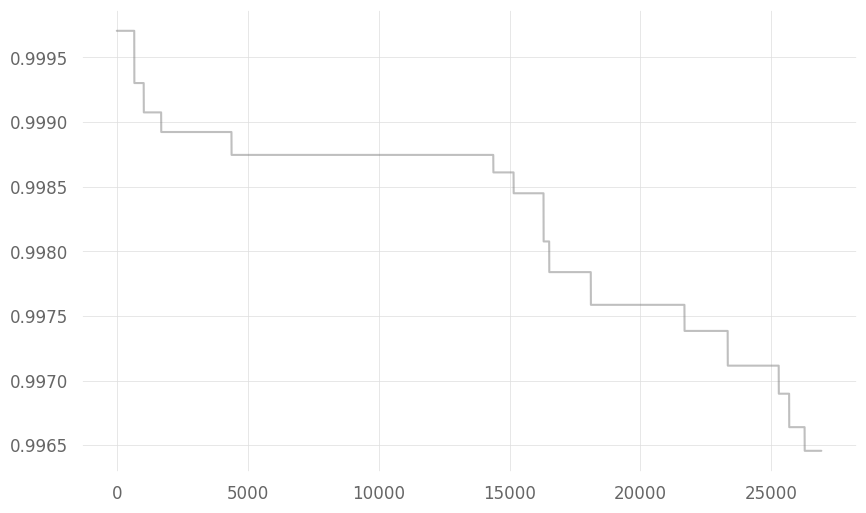

In [ ]:
plt.plot(eval_env.history['total_profit'], label='Price', color='gray', alpha=0.5)

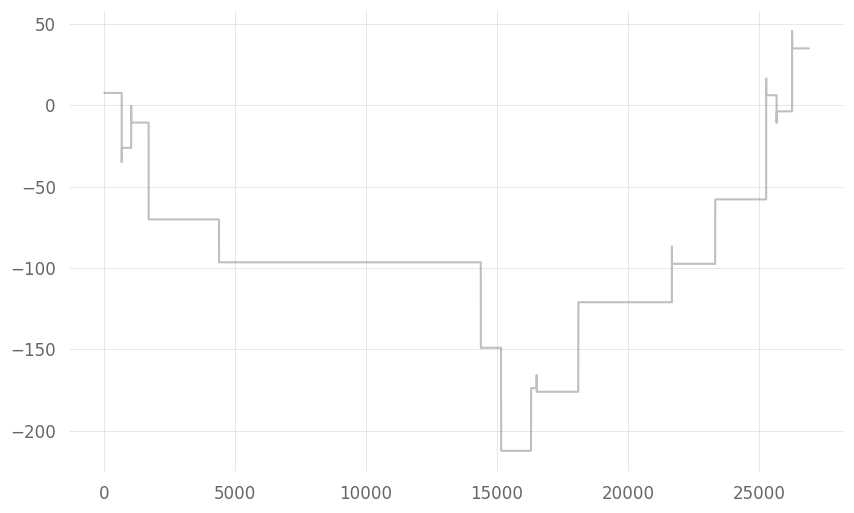

In [ ]:
plt.plot(eval_env.history['total_reward'], label='Price', color='gray', alpha=0.5)

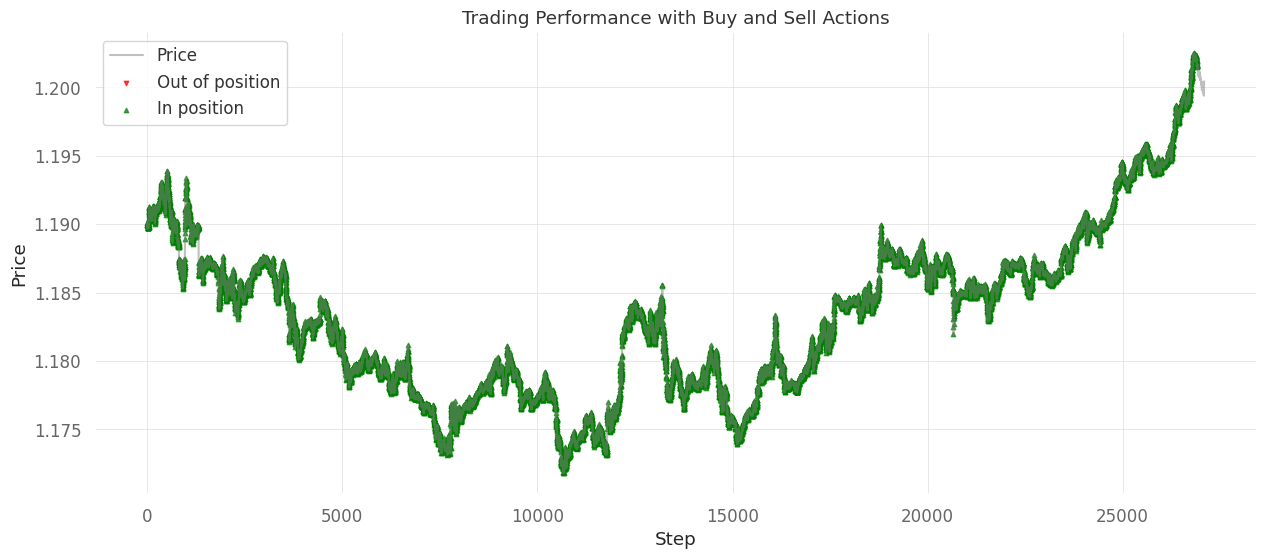

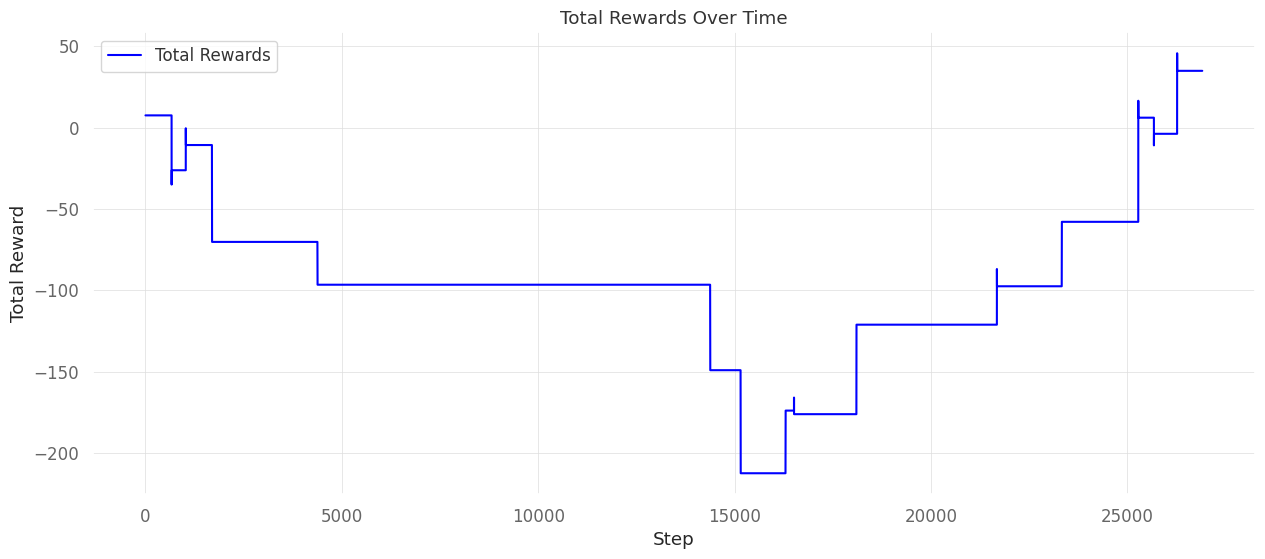

In [ ]:
prices_eval = list(filtered_data2.Close.values)

buy_steps_eval = [key_step for key_step, action in actions_taken_eval if action == Actions.Buy.value]
sell_steps_eval = [key_step for key_step, action in actions_taken_eval if action == Actions.Sell.value]

# Extract the prices for the buy and sell steps
buy_prices_eval = [prices_eval[step] for step in buy_steps_eval]
sell_prices_eval = [prices_eval[step] for step in sell_steps_eval]

plt.figure(figsize=(15, 6))
plt.plot(prices_eval, label='Price', color='gray', alpha=0.5)

plt.scatter(sell_steps_eval, sell_prices_eval, label='Out of position', color='red', marker='v', alpha=0.7, s = 10)
plt.scatter(buy_steps_eval, buy_prices_eval, label='In position', color='green', marker='^', alpha=0.7, s=10)

plt.title('Trading Performance with Buy and Sell Actions')
plt.xlabel('Step')
plt.ylabel('Price')
plt.legend()

plt.show()

plt.figure(figsize=(15, 6))
plt.plot(total_rewards_eval, label='Total Rewards', color='blue')
plt.title('Total Rewards Over Time')
plt.xlabel('Step')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

## PPO Results
During the train the model learns faster, closer to 10000 step the reward starts to stabilize and grow back after the fall in the beginning. It describes the process of how the model learns to buy and sell profitably. In the beginning it does actions that might lead to further lower return, but gets penalized for unprofitable decisions.


action_stats_train: {<Actions.Sell: 0>: 10, <Actions.Buy: 1>: 31316}


action_stats_test: {<Actions.Sell: 0>: 14, <Actions.Buy: 1>: 26895}

<br>

The behaviour of the trading agent is rather cautious, because most of the time they hold what they have bought, looking forward to the better moment for a sell. According to gym_anytrading properties - there are only 2 actions possible, so that when statistics say that Actions.Buy equals 31316 during train - it means both active action of buying and passive action of holding, while Actions.Sell means you either sell or if you don't have assets, then you are just out of position. This environment (in comparison to a more advanced proposed earlier) does not allow for short-selling.

<br>

With the total reward that was obtained during the training - it's 219.886 which is positive in the end, while having negative reward in the beginning. This provides evidence that the model does learn. Despite this, when the model is fitted for the whole month, it is almost impossible to get a gain in profit. At the same time, when changing the time frame for half a month, with proper parametrization, it is possible to get a small gain in profit afterall. It provides the evidence that these algorithms are able to learn the mechanics on a more short-run horizon, especially when dealing with high-frequency (minute) data.

<br>

According to training, the total profit equals 0.9955, which means that even though the trading agent did not make money, it managed not to loose much: just 0.0045. Considering the test set that covers the month of absolutely different market behaviour - December, the model (fitted to March) allowed the trading agent not to loose a lot of money: just 0.0035.

<br>

Even though during the test the profit was showing better performance than on test, the total reward for test is lower (34.87). This means that the model experiences difficulties when seeing the unusual data (with different trading behaviour month). It can be seen in the plot that the reward is decreasing untill 15000 step with reaching -200 which is much bigger in absolute values than that of train. Only after 15000 step the model starts to gain reward. This means it takes time for a model to get used to new specific data.

<br>

In conclusion: this study recommends to utilize the PPO model with a shorter frame of time if using it for Forex Trading. Usually for PPO one needs less number of timesteps to fit the model than in A2C.Furthermore, it is adviced to store different models for different market behaviour and use them in ensemble.

<a name="sec:conclusion"></a>
# **Conclusion**

In the first half of this project we compared the performance of A2C, PPO, and DQN algorithms trading on simulated stocks, with prices characterized by sinusoidal waves with varying levels of noise. In [Section 1.5.3](#sec:analysis-results-1.5.3), we discussed the evolution of model performance as the signals approach white noise. We also compared the performance of these DRL models against a classical benchmark strategy based on mean reversion. At low noise levels, the mean reversion benchmark outperformed all algorithms, but this advantage weakened as noise increased. DQN and A2C performed notably well, even after accounting for volatility. However, in the test set, DQN became unprofitable at high noise values, while A2C remained profitable. Further exploration is needed to better understand A2C's performance on noisy signals.

<br>

In the second half of the project, we explored DRL for Forex trading. The implementation of DQN architectures in a customized trading environment revealed insights into trading agents behaviors. The enriched action space and position dynamics in the custom environment allows the DQN models to execute more complex strategies. This provides a closer approximation to real-world trading scenarios than simpler environments by letting the agent short sell. The results suggest that as the DQN is trained for a greater number of timesteps, there is a tendency towards a more diversified action distribution, supporting the hypothesis that extended market exposure enhances strategic depth and adaptability. Consequently, the adaptation mitigates risk of overfitting to narrow market trends, fostering a robustness which is of high importance for the volatile forex environment.

<br>

The complexities of the DQN architectures seem to simulate different trading philosophies—from conservative to aggressive strategies—mirroring real-world trading scenarios which can be seen in [Section 2.1.4](#sec:Comparison-DQN-Architectures-for-full-timesteps-2.1.4). Larger, more complex networks (like DeepMind architecture with high number of neurons) appear to capture subtle market nuances better, with appearance of higher risk. In contrast, simpler neural nets are prioritizing stability and consistent returns over high-risk and high-reward trades. Application of both A2C and PPO algorithms for Forex trading demonstrates that each model adapts differently under market conditions of two distant in terms of trading behaviour months. The A2C tends to require more time to stabilize, indicating a need for longer training periods, while PPO shows quicker adaptation to market changes, suggesting it might be more effective in shorter time frames. Both models initially display a conservative strategy, which suggests rather a risk-averse approach that prioritizes waiting for optimal conditions over frequent trading. The results emphasize the potential benefits of using a combination of models to handle diverse market behaviors and enhance trading strategies effectively.

<a name="sec:bibliography"></a>
## **Bibliography**

- **Baradja, A., Gernowo, R., and Wibowo, A. (2023)**: "Optimizing Advantage Actor-Critic with Policy Gradient and Deep Q-learning to Maximize Profit in Forex Trading Prediction." Presented at the 2023 1st IEEE International Conference on Smart Technology (ICE-SMARTec). Available at: [DOI](https://doi.org/10.1109/ICE-SMARTECH59237.2023.10461955).

- **Briola, A. et al. (2023)**: "Deep Reinforcement Learning for Active High Frequency Trading." Available on arXiv: [DOI](https://doi.org/10.48550/arXiv.2101.07107).

- **Carapuço, J., Neves, R., and Horta, N. (2018)**: "Reinforcement learning applied to Forex trading." Published in *Applied Soft Computing*, 73, pp. 783–794. Available at: [DOI](https://doi.org/10.1016/j.asoc.2018.09.017).

- **Deng, Y. et al. (2017)**: "Deep Direct Reinforcement Learning for Financial Signal Representation and Trading." Published in *IEEE Transactions on Neural Networks and Learning Systems*, 28(3), pp. 653–664. Available at: [DOI](https://doi.org/10.1109/TNNLS.2016.2522401).

- **Ganesh, P., and Rakheja, P. (2018)**: "Deep Reinforcement Learning in High Frequency Trading."

- **Haghpanah, M.A. (2024)**: Repository: "AminHP/gym-anytrading." Available at: [GitHub](https://github.com/AminHP/gym-anytrading) (Accessed: 1 April 2024).

- **Huang, S. et al. (2024)**: "Open RL Benchmark: Comprehensive Tracked Experiments for Reinforcement Learning." Available on arXiv: [arXiv link](http://arxiv.org/abs/2402.03046) (Accessed: 11 March 2024).

- **Jaddu, K.S., and Bilokon, P.A. (2023)**: "Combining Deep Learning on Order Books with Reinforcement Learning for Profitable Trading." Available on arXiv: [arXiv link](http://arxiv.org/abs/2311.02088) (Accessed: 27 February 2024).

- **Liu, X.-Y., Yang, H., et al. (2022)**: "FinRL: deep reinforcement learning framework to automate trading in quantitative finance." Presented at the Second ACM International Conference on AI in Finance (ICAIF ’21). Available at: [DOI](https://doi.org/10.1145/3490354.3494366).

- **Liu, X.-Y., Xiong, Z., et al. (2022)**: "Practical Deep Reinforcement Learning Approach for Stock Trading." Available on arXiv: [arXiv link](http://arxiv.org/abs/1811.07522) (Accessed: 29 January 2024).

- **Mnih, V. et al. (2013)**: "Playing Atari with Deep Reinforcement Learning." Available on arXiv: [DOI](https://doi.org/10.48550/arXiv.1312.5602).

- **Mnih, V. et al. (2016)**: "Asynchronous Methods for Deep Reinforcement Learning." Available on arXiv: [arXiv link](http://arxiv.org/abs/1602.01783) (Accessed: 31 January 2024).

- **Moody, J., and Saffell, M. (1998)**: "Reinforcement Learning for Trading." Presented at Advances in Neural Information Processing Systems. Available at: [Abstract](https://proceedings.neurips.cc/paper_files/paper/1998/hash/4e6cd95227cb0c280e99a195be5f6615-Abstract.html) (Accessed: 9 May 2024).

- **Nevmyvaka, Y., Feng, Y., and Kearns, M. (2006)**: "Reinforcement learning for optimized trade execution." Presented at the 23rd International Conference on Machine Learning (ICML ’06), pp. 673–680. Available at: [DOI](https://doi.org/10.1145/1143844.1143929).

- **Schulman, J. et al. (2017)**: "Proximal Policy Optimization Algorithms." Available on arXiv: [DOI](https://doi.org/10.48550/arXiv.1707.06347).

- **Taherizadeh, A., and Zamani, S. (2023)**: "Winner Strategies in a Simulated Stock Market." Published in the *International Journal of Financial Studies*, 11(2), p. 73. Available at: [DOI](https://doi.org/10.3390/ijfs11020073).

- **Tsai, Y.-C. et al. (2020)**: "Deep Reinforcement Learning for Foreign Exchange Trading." In *Trends in Artificial Intelligence Theory and Applications*, edited by H. Fujita et al. (Artificial Intelligence Practices). Cham: Springer International Publishing, pp. 387–392. Available at: [DOI](https://doi.org/10.1007/978-3-030-55789-8_34).

- **Zhang, Z., Zohren, S., and Roberts, S. (2019)**: "Deep Reinforcement Learning for Trading." Available on arXiv: [DOI](https://doi.org/10.48550/arXiv.1911.10107).

### **Contributions**
33.33% each